In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Disaster Data (EMDAT)

In [2]:
#########################
# LOAD DISASTER DATA
#########################

emdat = pd.read_excel("data/emdat_public.xlsx")
emdat = emdat[emdat["Year"] >= 1800]
emdat = emdat[emdat["Year"] <= 2020]

# Filling NaNs in start month and day with 1
emdat['Start Month'].fillna(1, inplace=True)
emdat['Start Day'].fillna(1, inplace=True)

# Filling NaNs in end month and day with corresponding start month and day
emdat['End Month'] = emdat.apply(lambda row: row['Start Month'] if pd.isna(row['End Month']) else row['End Month'], axis=1)
emdat['End Day'] = emdat.apply(lambda row: row['Start Day'] if pd.isna(row['End Day']) else row['End Day'], axis=1)

### DURATION ###
# Convert 'Start' and 'End' columns to datetime
emdat['Start Date'] = pd.to_datetime(emdat[['Start Year', 'Start Month', 'Start Day']]
                                  .rename(columns={'Start Year': 'year', 'Start Month': 'month', 'Start Day': 'day'}))

emdat['End Date'] = pd.to_datetime(emdat[['End Year', 'End Month', 'End Day']]
                                .rename(columns={'End Year': 'year', 'End Month': 'month', 'End Day': 'day'}))


# Calculate the 'Duration' column as the difference in days between 'End Date' and 'Start Date'
emdat['Duration'] = (emdat['End Date'] - emdat['Start Date']).dt.days

# Set all negative values in DataFrame to 0
emdat["Duration"] = emdat["Duration"].clip(lower=0)

# Problem with storm windspeeds
emdat = emdat.drop(emdat[(emdat["Disaster Type"] == "Storm") & (emdat["Dis Mag Value"] > 408)].index)

#Problem with storm durations
emdat = emdat.drop(emdat[(emdat["Disaster Type"] == "Storm") & (emdat["Duration"] > 23)].index)

# Remove some variables
emdat_filter = emdat[["Disaster Type", "Country", "ISO", "Region","Year", "Dis Mag Value", "Dis Mag Scale", "No Affected", "No Homeless", "Start Date", "End Date", "Duration"]].fillna(0)


## Occurences

In [3]:
grouped_emdat = emdat.groupby(['Year', 'Disaster Type']).size().reset_index(name='Occurrences')
# Pivot the table
grouped_emdat = grouped_emdat.pivot(index='Year', columns='Disaster Type', values='Occurrences')

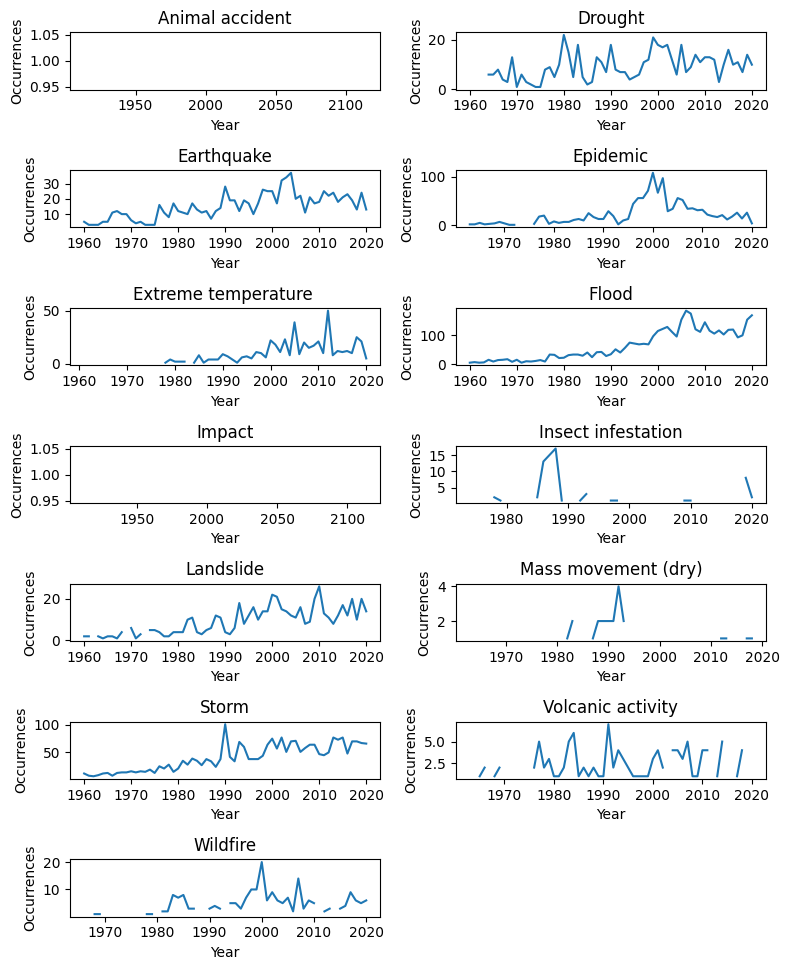

In [4]:
# Number of columns in the DataFrame
n_cols = grouped_emdat.shape[1]

# Calculate number of rows based on the number of columns
n_rows = -(-n_cols // 2)  # Ceiling division

# Create a n_rows x 2 grid of subplots
fig, axes = plt.subplots(n_rows, 2, figsize=(8, 1.4 * n_rows))

# Flatten the 2D array of axes to simplify looping
# This works regardless of whether n_cols is odd or even
axes_flattened = axes.ravel()

for ax, column in zip(axes_flattened, grouped_emdat.columns):
    ax.plot(grouped_emdat.index, grouped_emdat[column], marker='', label=column)
    ax.set_title(column)
    ax.set_xlabel('Year')
    ax.set_ylabel('Occurrences')

# If there's an odd number of plots, remove the last (unused) axis
if n_cols % 2 == 1:
    fig.delaxes(axes_flattened[-1])

plt.tight_layout()
plt.show()


Based on the graphs above, we remove some of the more exotic disasters that do not show trends, or have a lack of datapoints

In [5]:
#We remove some of the more exotic

grouped_emdat = grouped_emdat.drop(["Epidemic", "Insect infestation", "Animal accident", "Impact", "Volcanic activity", "Wildfire", "Mass movement (dry)", "Landslide", "Earthquake"], axis=1)

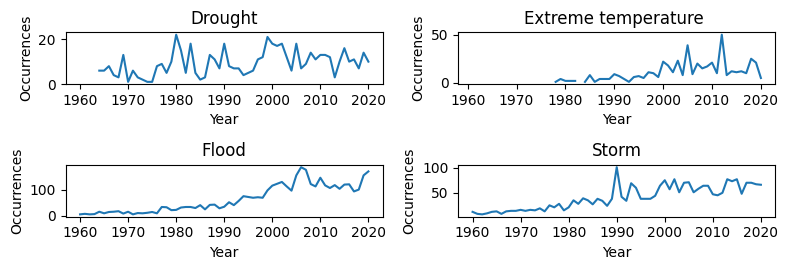

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Number of columns in the DataFrame
n_cols = grouped_emdat.shape[1]

# Calculate number of rows based on the number of columns
n_rows = -(-n_cols // 2)  # Ceiling division

# Create a n_rows x 2 grid of subplots
fig, axes = plt.subplots(n_rows, 2, figsize=(8, 1.4 * n_rows))

# Flatten the 2D array of axes to simplify looping
# This works regardless of whether n_cols is odd or even
axes_flattened = axes.ravel()

for ax, column in zip(axes_flattened, grouped_emdat.columns):
    ax.plot(grouped_emdat.index, grouped_emdat[column], marker='', label=column)
    ax.set_title(column)
    ax.set_xlabel('Year')
    ax.set_ylabel('Occurrences')

# If there's an odd number of plots, remove the last (unused) axis
if n_cols % 2 == 1:
    fig.delaxes(axes_flattened[-1])

plt.tight_layout()
plt.show()


For extreme temperature we have a lack of data on the cause to displacement - it seems to be not so prevalent

In [7]:
emdat[emdat["Disaster Type"] == "Extreme temperature "]["No Homeless"].sort_values()

1042       1340.0
7593     233000.0
15            NaN
21            NaN
51            NaN
           ...   
10306         NaN
10373         NaN
10377         NaN
10458         NaN
10731         NaN
Name: No Homeless, Length: 473, dtype: float64

In [8]:
disaster_types = ["Flood", "Storm", "Drought"]
emdat = emdat[emdat["Disaster Type"].isin(disaster_types)]

Let's see if we have some correlation between the temperature and the number of disasters

In [9]:
#########################
# LOAD GLOBAL TEMPERATURE ANOMALY DATA
#########################

temp = pd.read_csv("data/env_params/SSP119/global_params.csv")
temp = temp.drop("co2_emissions", axis=1)
temp.rename(columns={"time":"Year"},inplace=True)

In [10]:
grouped_emdat = emdat.groupby(['Year', 'Disaster Type']).size().reset_index(name='Occurrences')
# Pivot the table
grouped_emdat = grouped_emdat.pivot(index='Year', columns='Disaster Type', values='Occurrences')

disaster_temp = pd.merge(temp,grouped_emdat, on="Year", how="inner")
disaster_temp = disaster_temp.fillna(0)
disaster_temp.set_index("Year",inplace=True)

<Axes: >

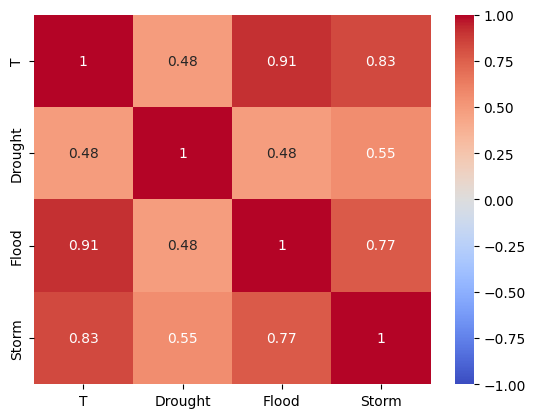

In [11]:
corrmat = disaster_temp.corr()
sns.heatmap(corrmat,annot=True, cmap="coolwarm", vmin=-1, vmax=1)

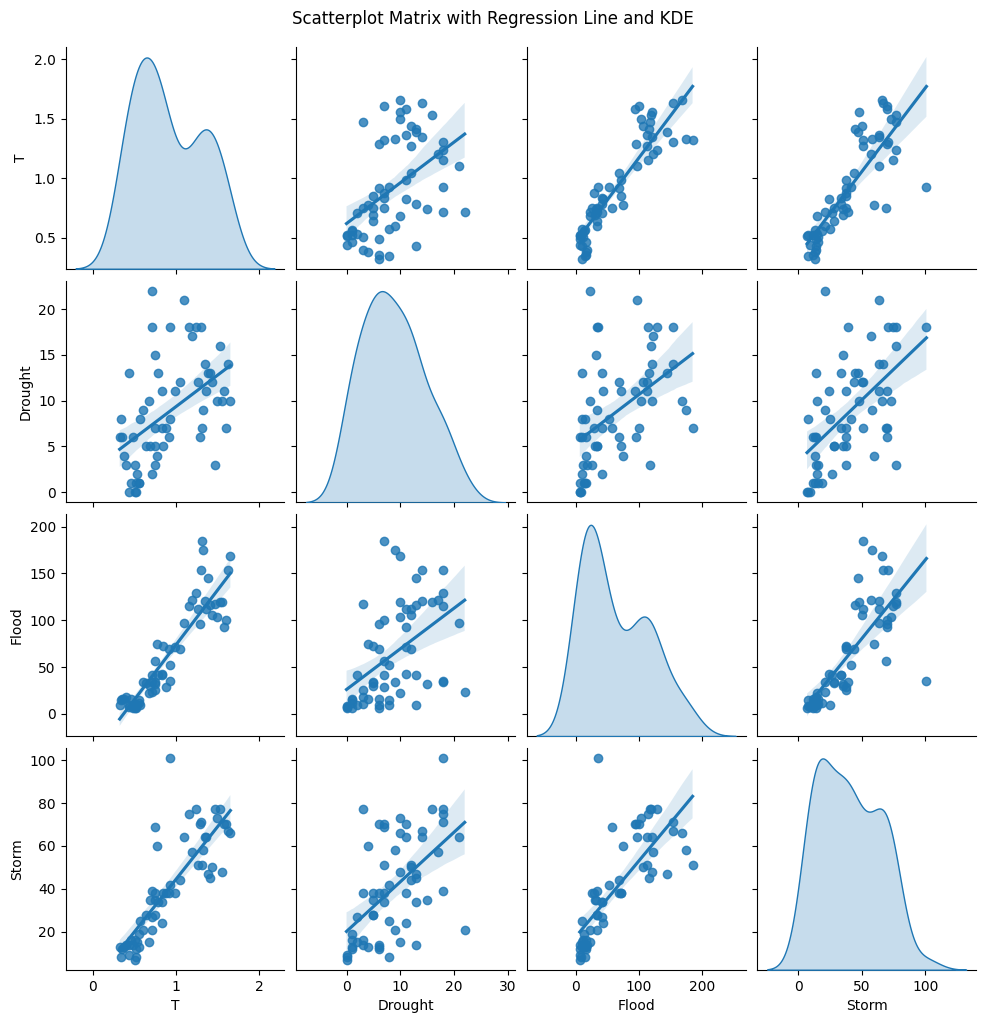

In [12]:
sns.pairplot(disaster_temp, kind='reg', diag_kind='kde')
plt.suptitle('Scatterplot Matrix with Regression Line and KDE', y=1.02)
plt.show()

We see a very high positive correlation in the data between global average temperature and the prevalence of storms and floods

## Magnitudes

We have two measures of magnitude. One is the scale by which the disasters are measured at, and the other is the duration of the disasters. Let's look at some averages over time

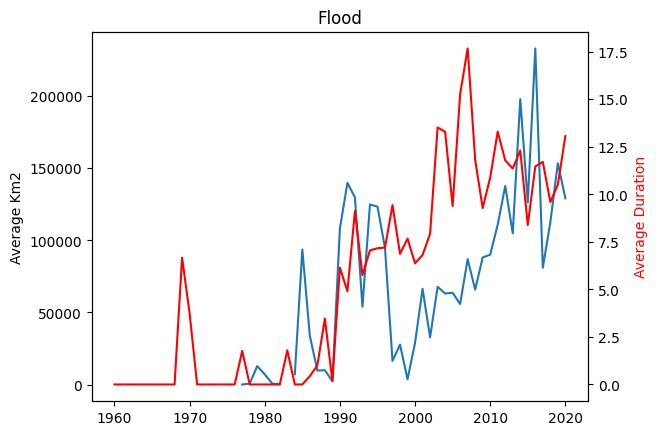

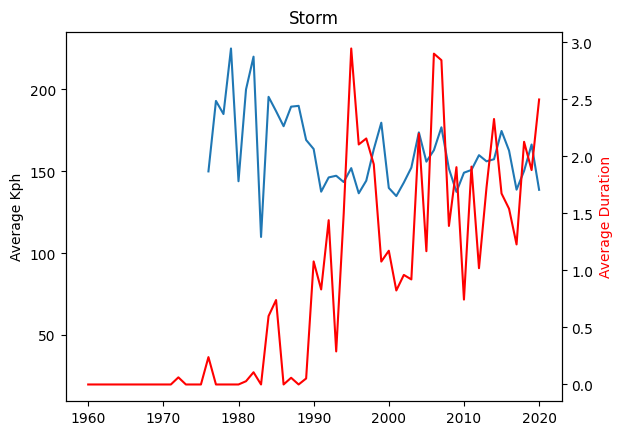

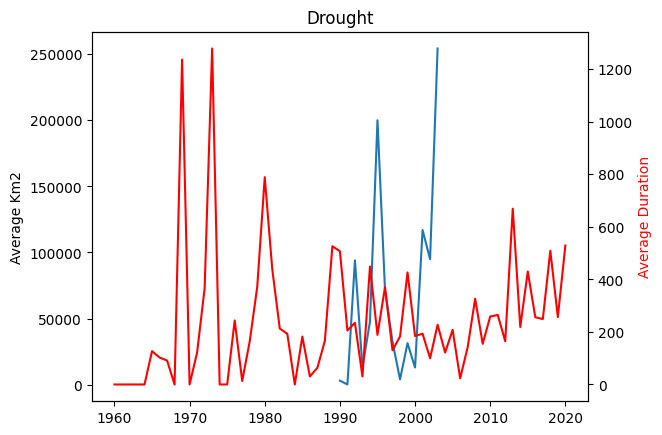

In [13]:
disaster_types = ["Flood", "Storm", "Drought"]
for d in disaster_types:
    df = emdat[emdat["Disaster Type"] == d]
    fig, ax = plt.subplots() 
    ax.set_title(d)
    ax.set_ylabel("Average " + df["Dis Mag Scale"].unique()[0])

    df = df.groupby("Year").mean(numeric_only=True).reset_index()
    ax.plot(df["Year"], df["Dis Mag Value"])

    ax2 = ax.twinx()
    ax2.set_ylabel('Average Duration', color='r')
    ax2.plot(df["Year"], df["Duration"], "r-")


Droughts have a very long duration, and can be determined by the lack of precipitation. It is more difficult to view them as discrete events, and they are more correctly interpreted as a long depression, so we remove them also

In [14]:
# Limit the data to only floods and storms
disaster_types = ["Flood", "Storm"]
emdat = emdat[emdat["Disaster Type"].isin(disaster_types)]

In [15]:
regions = emdat["Region"].unique()

region_groups = [["Southern Asia", "Eastern Asia", "South-Eastern Asia", "Central Asia", "Western Asia"],
                 ["Russian Federation", "Eastern Europe", "Western Europe", "Northern Europe", "Southern Europe"],
                 ["Northern Africa", "Eastern Africa", "Middle Africa", "Southern Africa", "Western Africa"]]

emdat_filter = emdat[["Year", "Dis Mag Value", "Duration", "Disaster Type", "Region", "Total Deaths", "No Homeless", "No Injured", "No Affected", "Total Affected", "Total Damages, Adjusted ('000 US$)"]]

Flood  in  ['Southern Asia', 'Eastern Asia', 'South-Eastern Asia', 'Central Asia', 'Western Asia']


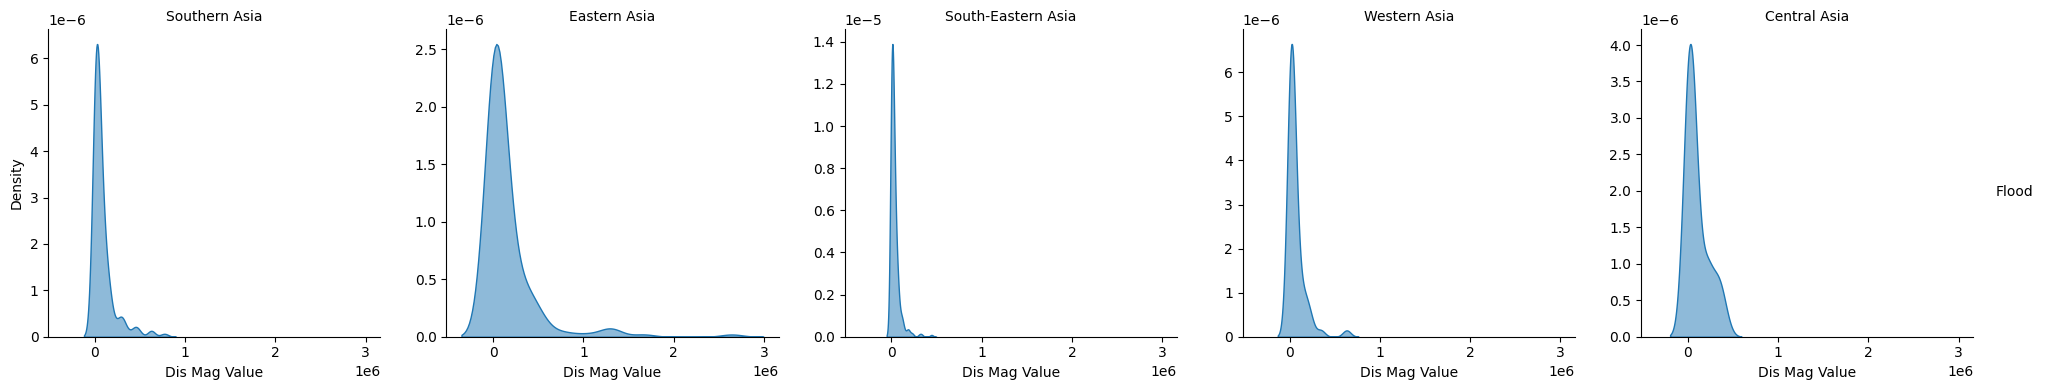

Flood  in  ['Russian Federation', 'Eastern Europe', 'Western Europe', 'Northern Europe', 'Southern Europe']


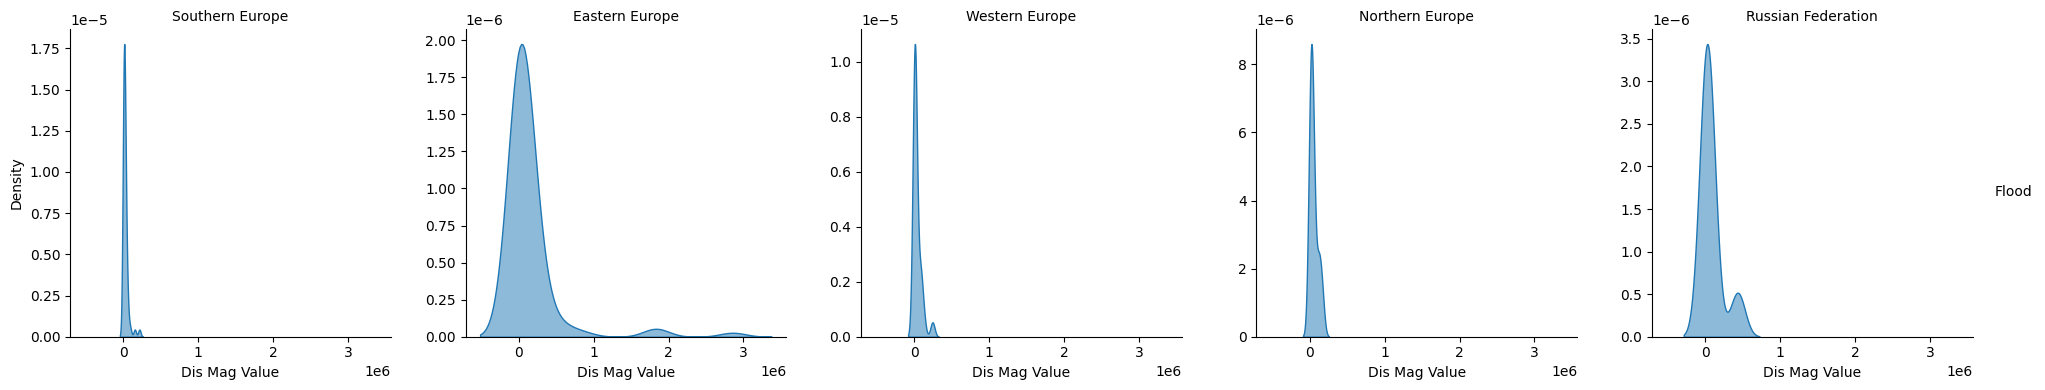

Flood  in  ['Northern Africa', 'Eastern Africa', 'Middle Africa', 'Southern Africa', 'Western Africa']


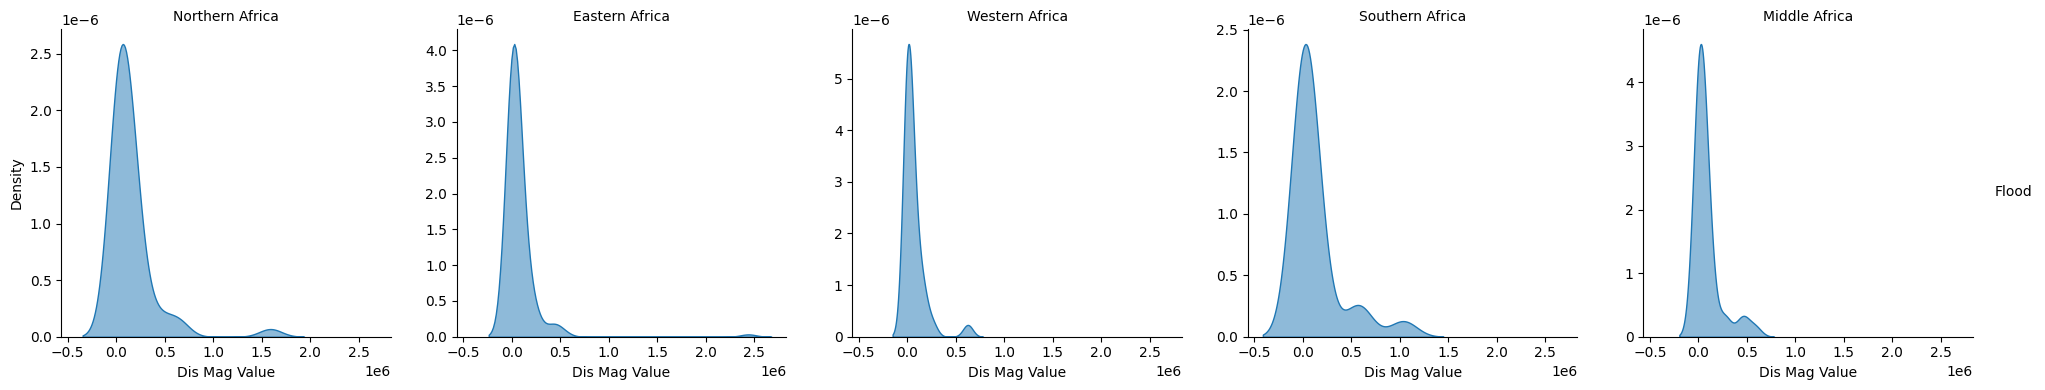

Storm  in  ['Southern Asia', 'Eastern Asia', 'South-Eastern Asia', 'Central Asia', 'Western Asia']


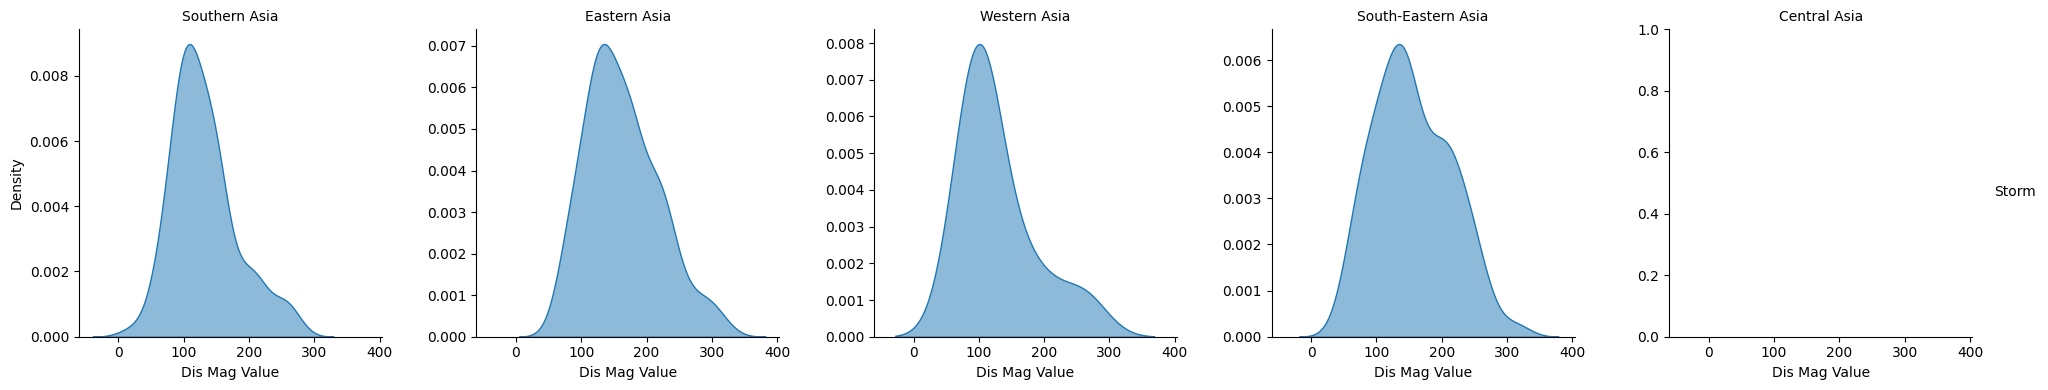

Storm  in  ['Russian Federation', 'Eastern Europe', 'Western Europe', 'Northern Europe', 'Southern Europe']


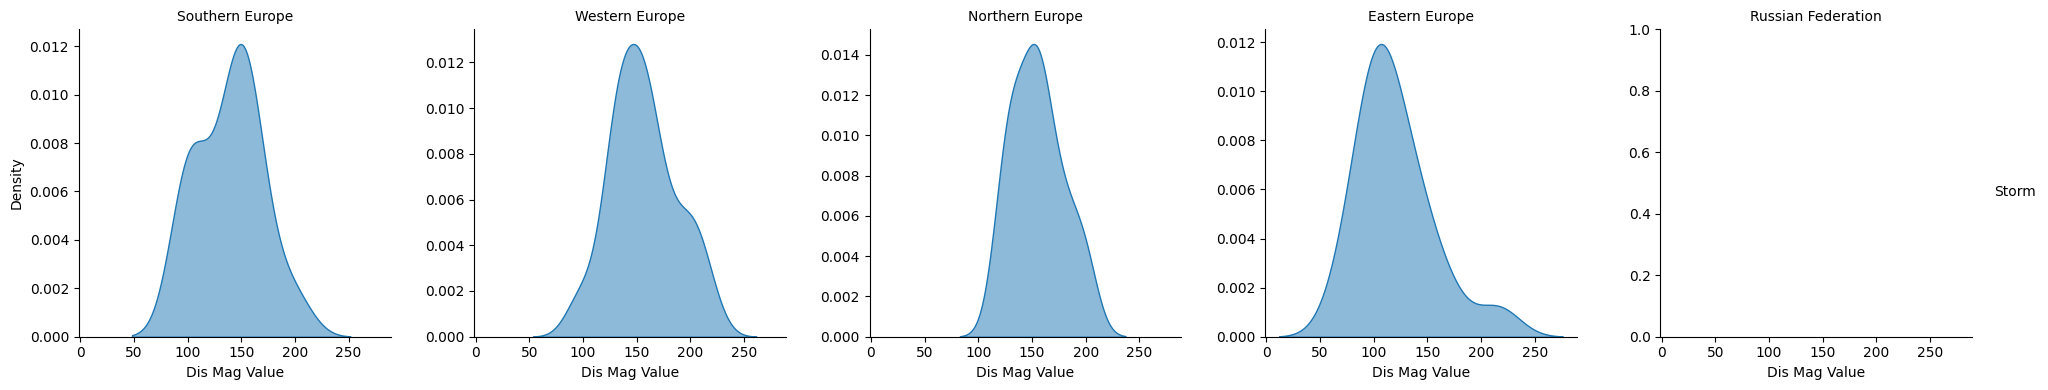

Storm  in  ['Northern Africa', 'Eastern Africa', 'Middle Africa', 'Southern Africa', 'Western Africa']


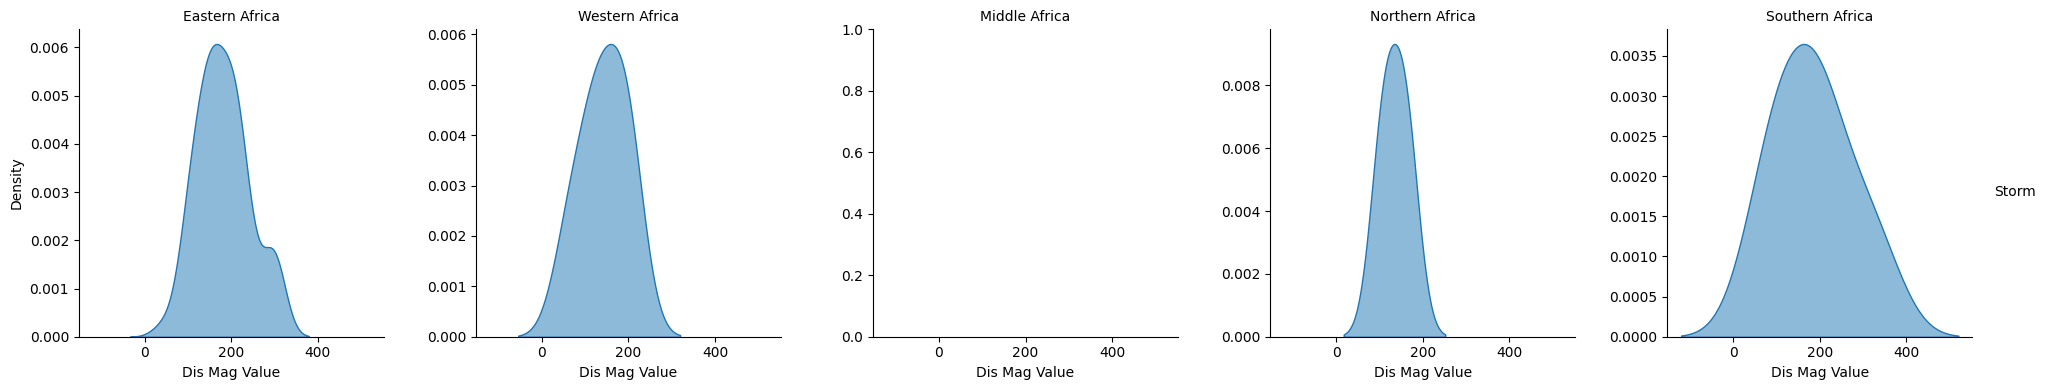

In [16]:
disaster_types = ["Flood", "Storm"]
# Plotting
for d in disaster_types:
    df = emdat_filter[emdat_filter["Disaster Type"] == d]
    for r in region_groups:
        print(d," in ",[x for x in r])
        dfr = df[df["Region"].isin(r)]
        g = sns.FacetGrid(dfr, col="Region", height=4, sharey=False)
        g.map_dataframe(sns.kdeplot, "Dis Mag Value", fill=True, common_norm=False, alpha=0.5, warn_singular=False)

        g.set_titles("{col_name}")
        g.set_axis_labels("Dis Mag Value", "Density")
        g.add_legend(title=d)
        plt.show()

For flood magnitudes we see right-skewed distributions for all regions. Let's look at durations.

Flood  in  ['Southern Asia', 'Eastern Asia', 'South-Eastern Asia', 'Central Asia', 'Western Asia']


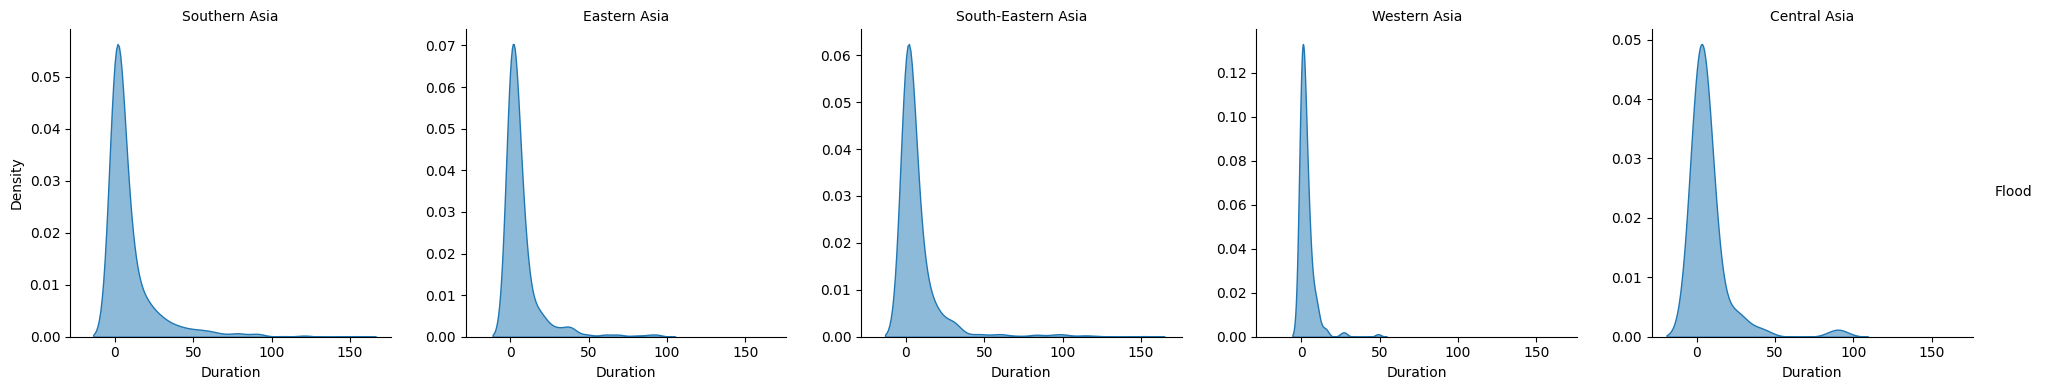

Flood  in  ['Russian Federation', 'Eastern Europe', 'Western Europe', 'Northern Europe', 'Southern Europe']


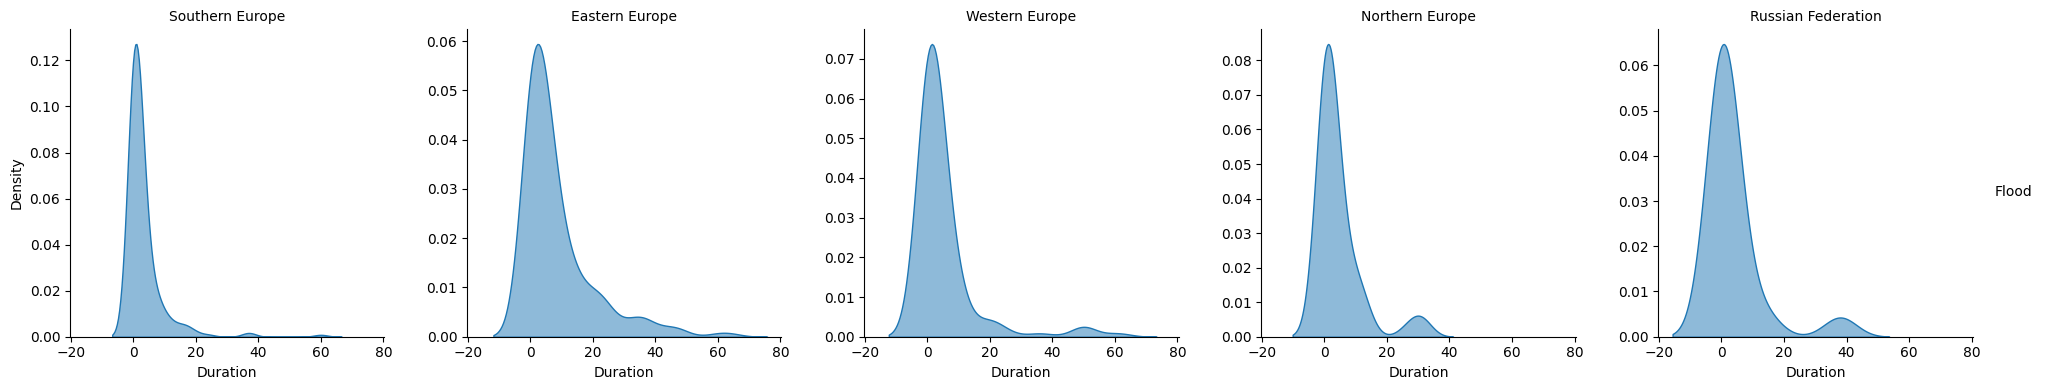

Flood  in  ['Northern Africa', 'Eastern Africa', 'Middle Africa', 'Southern Africa', 'Western Africa']


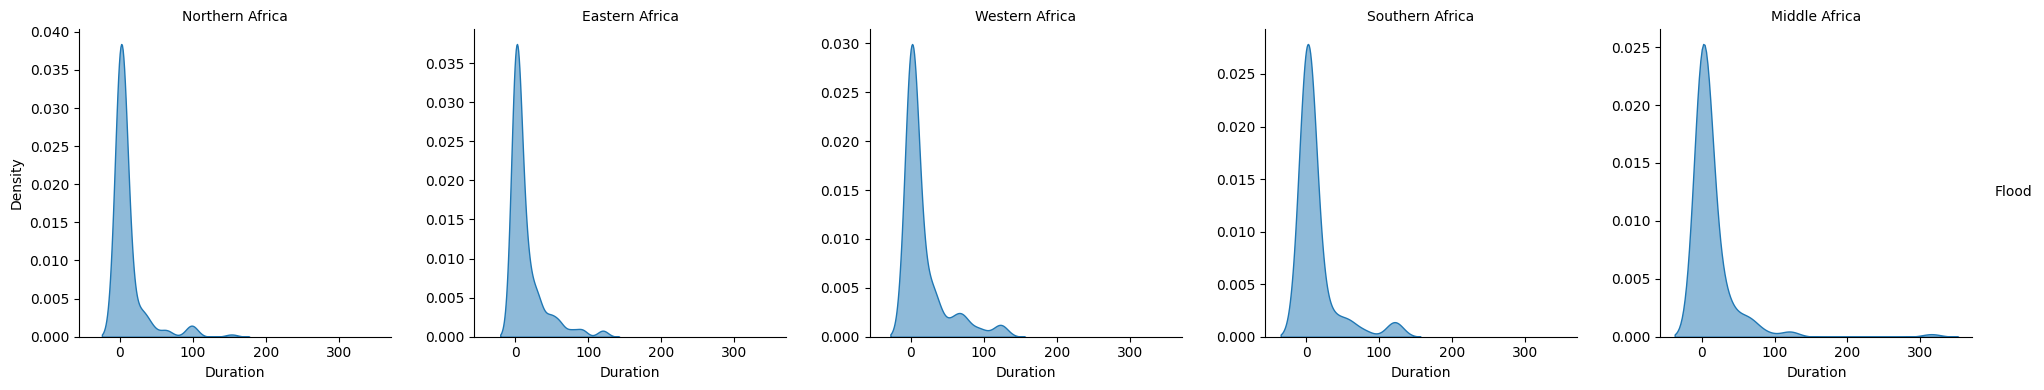

Storm  in  ['Southern Asia', 'Eastern Asia', 'South-Eastern Asia', 'Central Asia', 'Western Asia']


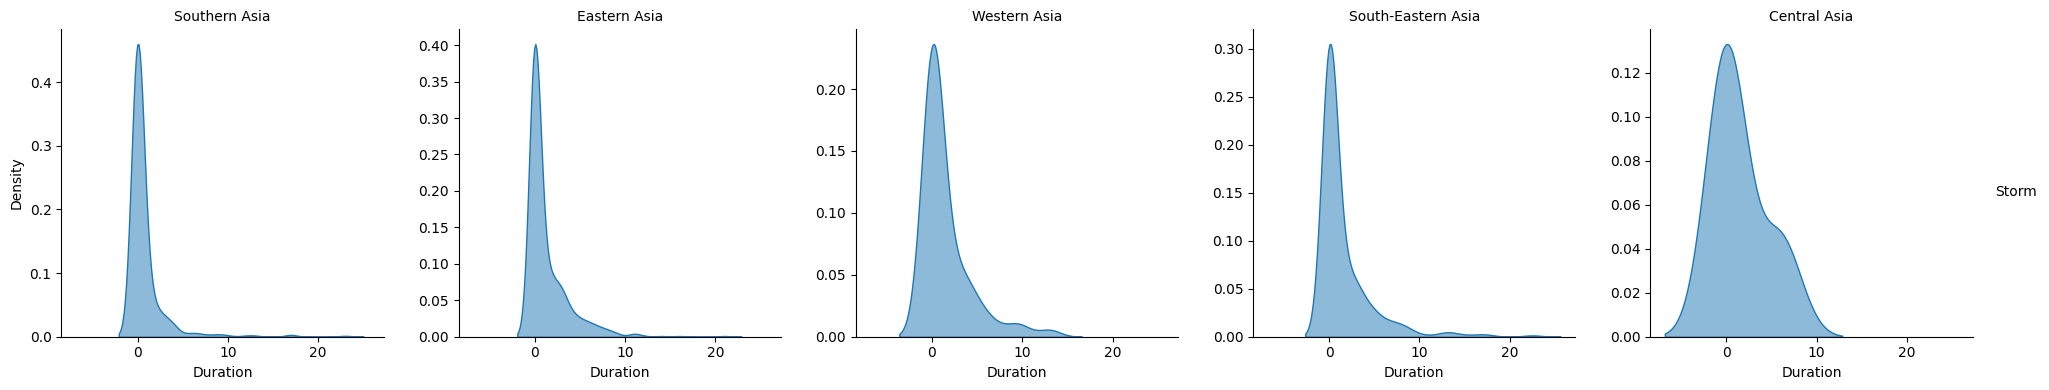

Storm  in  ['Russian Federation', 'Eastern Europe', 'Western Europe', 'Northern Europe', 'Southern Europe']


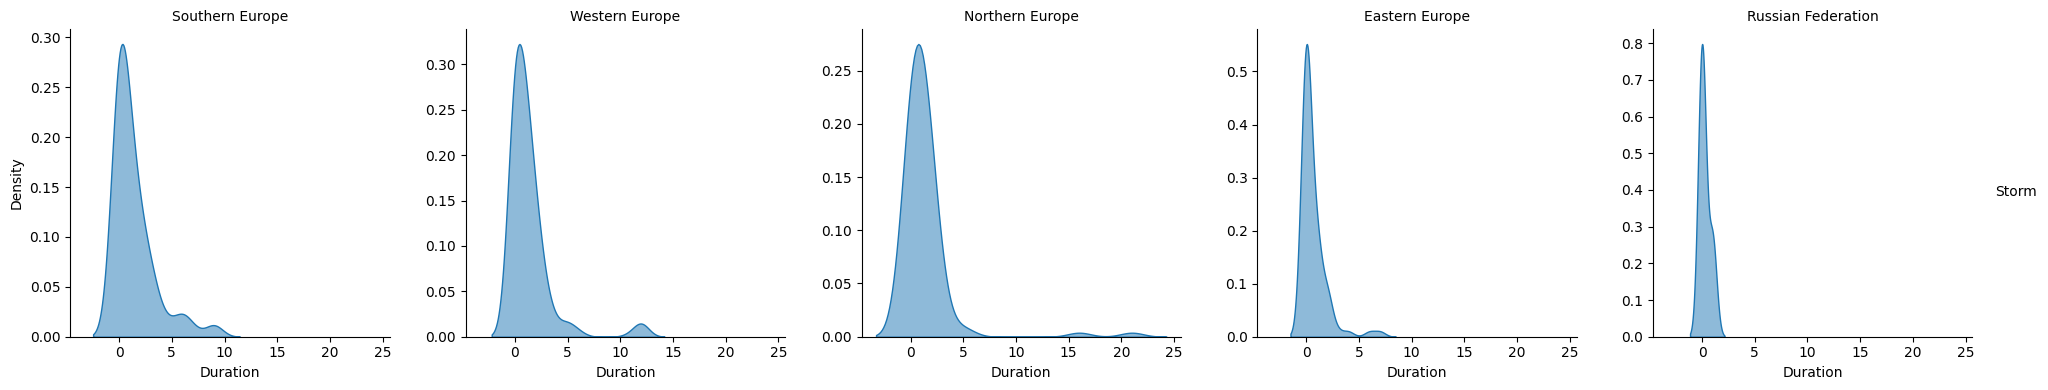

Storm  in  ['Northern Africa', 'Eastern Africa', 'Middle Africa', 'Southern Africa', 'Western Africa']


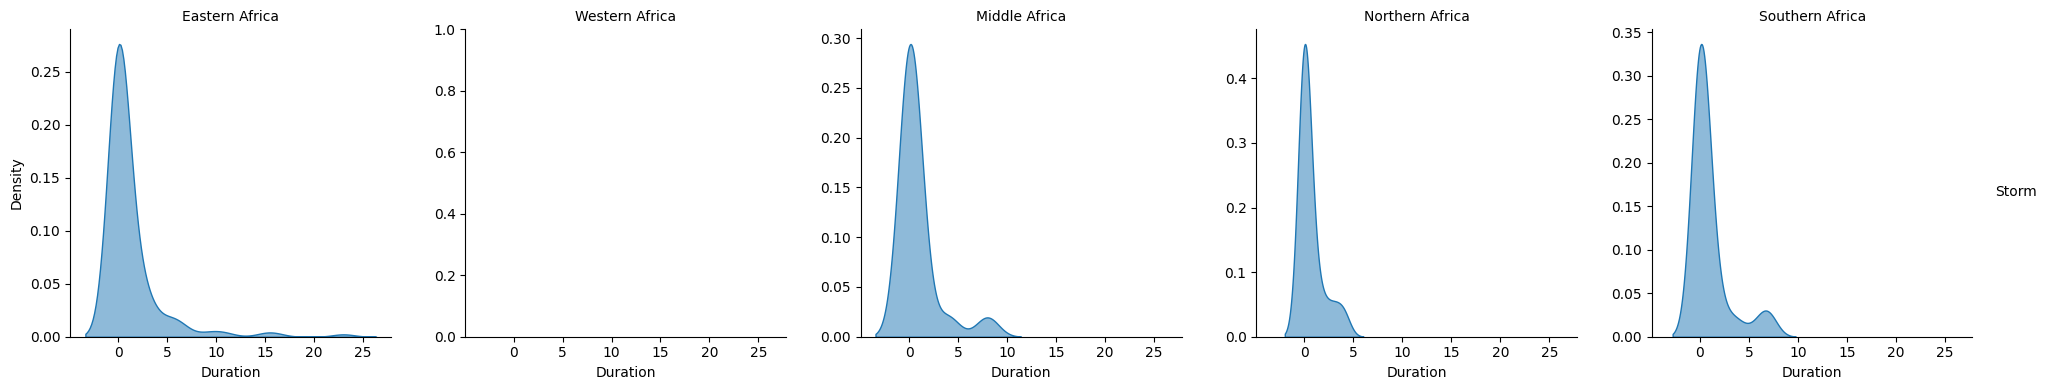

In [17]:
disaster_types = ["Flood", "Storm"]
# Plotting
for d in disaster_types:
    df = emdat_filter[emdat_filter["Disaster Type"] == d]
    for r in region_groups:
        print(d," in ",[x for x in r])
        dfr = df[df["Region"].isin(r)]
        g = sns.FacetGrid(dfr, col="Region", height=4, sharey=False)
        g.map_dataframe(sns.kdeplot, "Duration", fill=True, common_norm=False, alpha=0.5, warn_singular=False)

        g.set_titles("{col_name}")
        g.set_axis_labels("Duration", "Density")
        g.add_legend(title=d)
        plt.show()

Here we see a right-skewed distribution for almost all disasters. We definitely have some distribution of extreme outliers on storm and flood duration, and on flood magnitudes

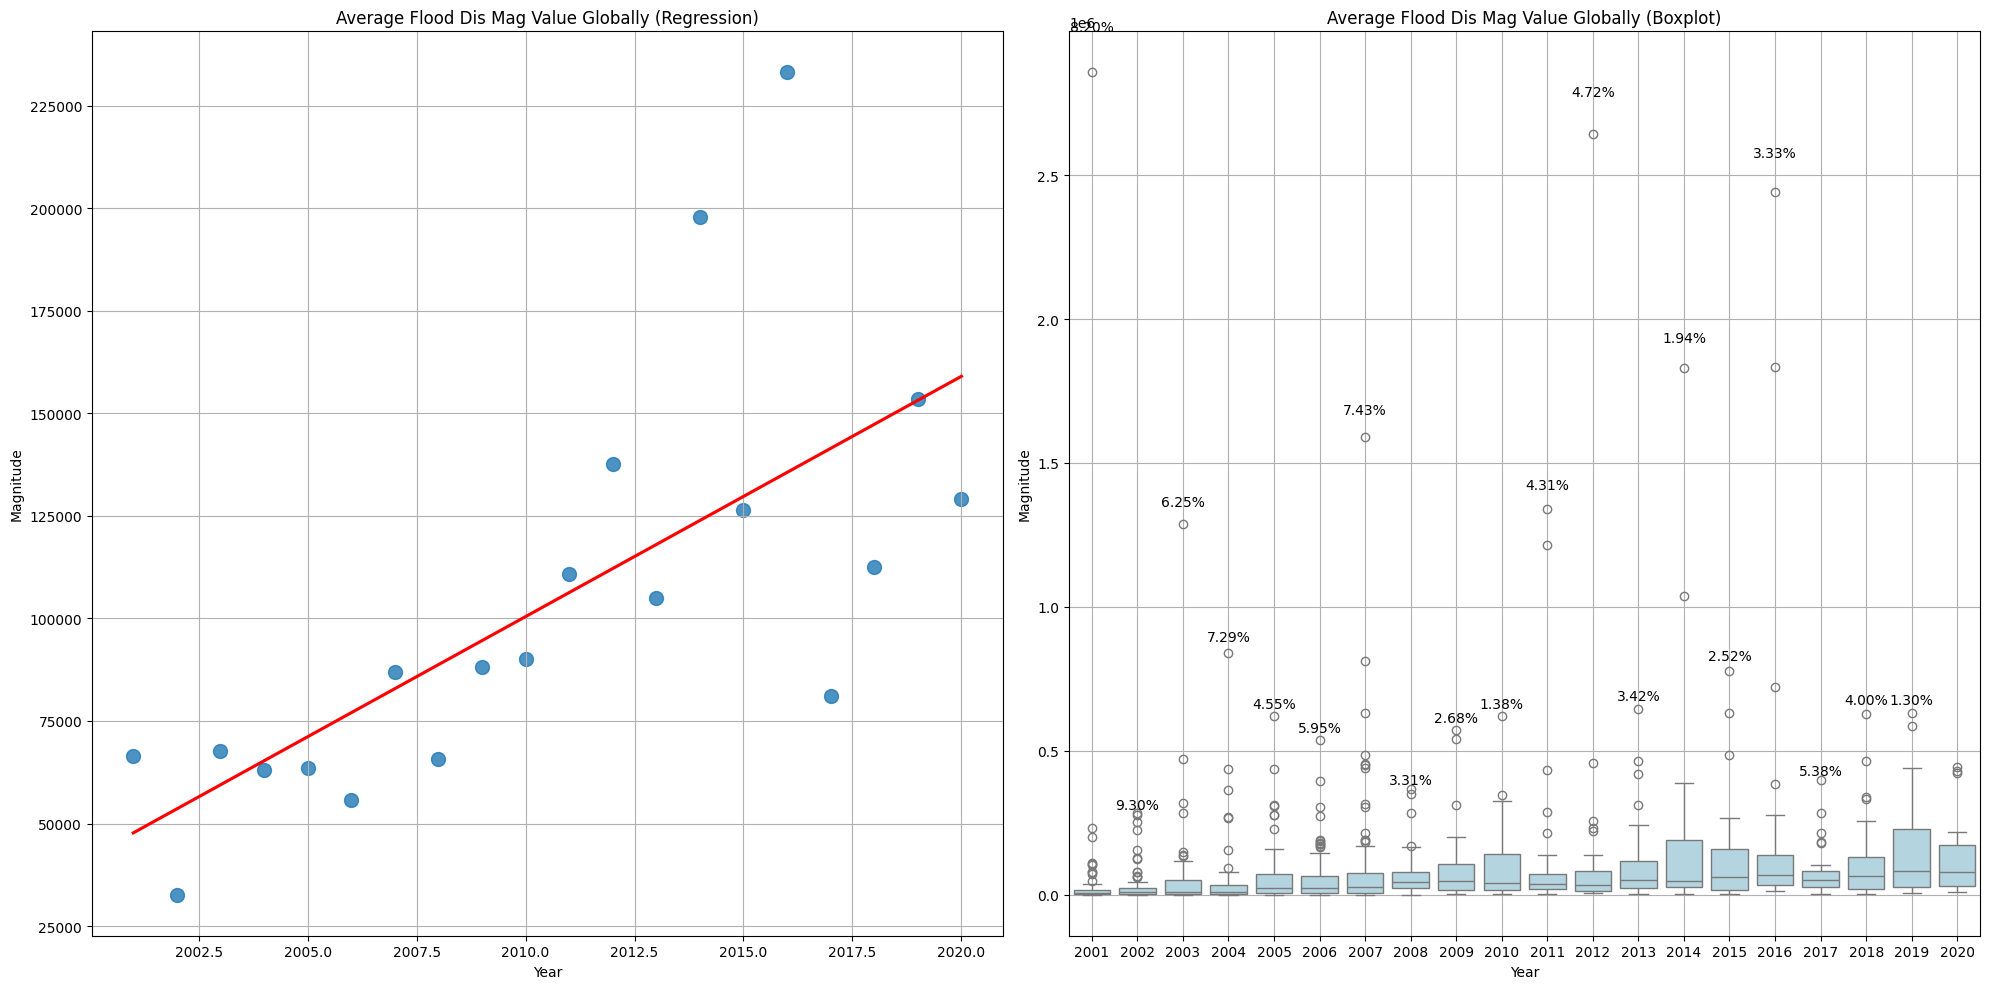

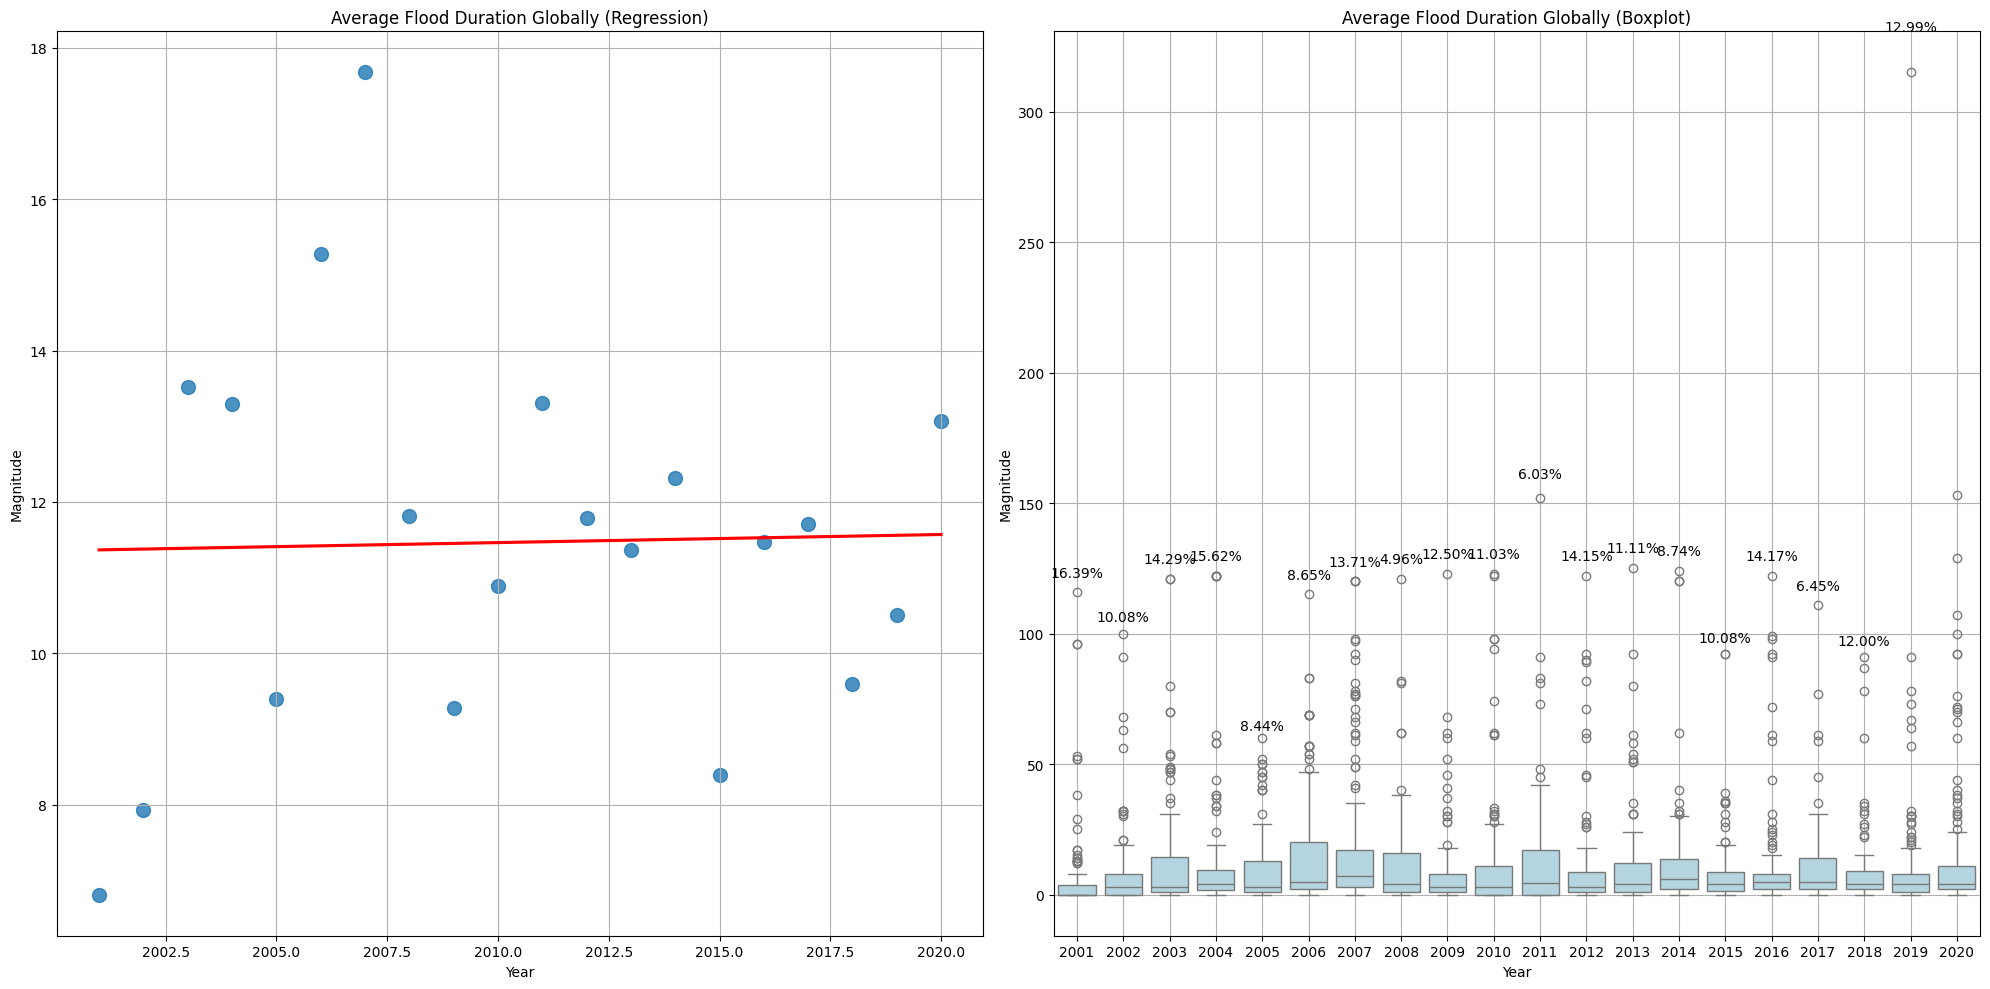

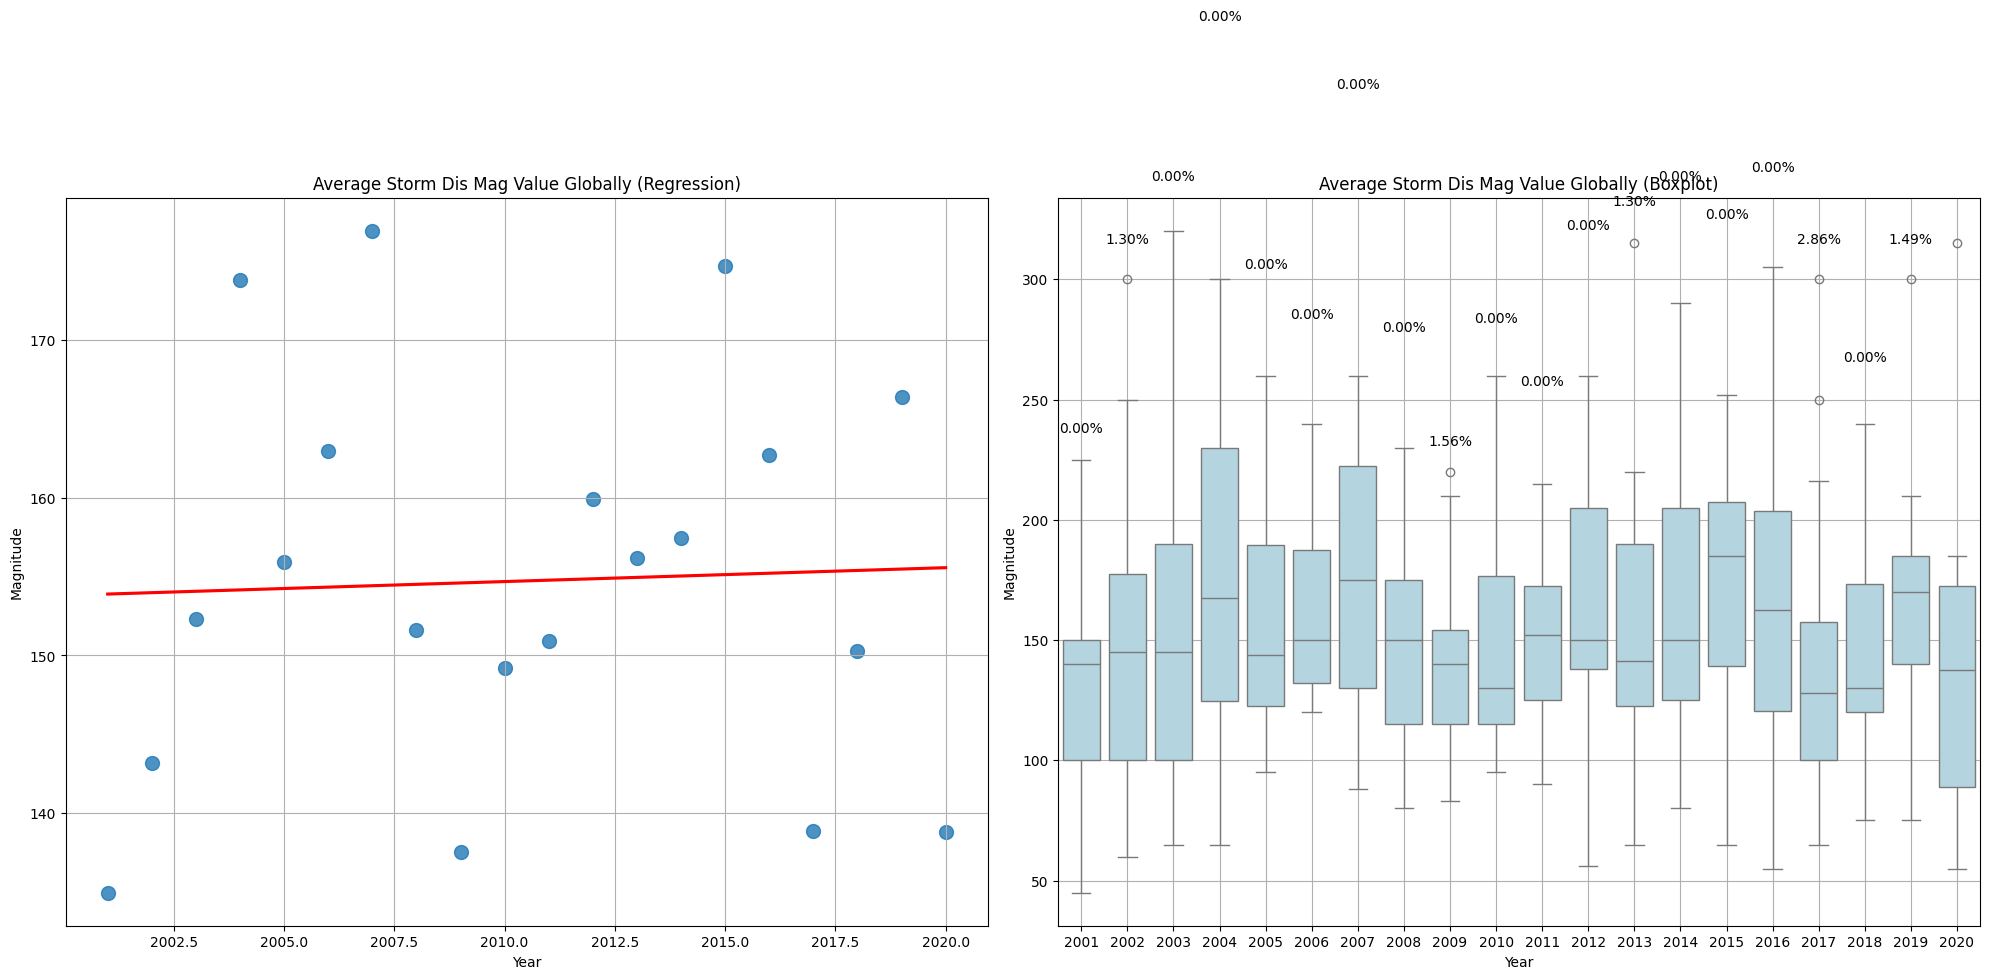

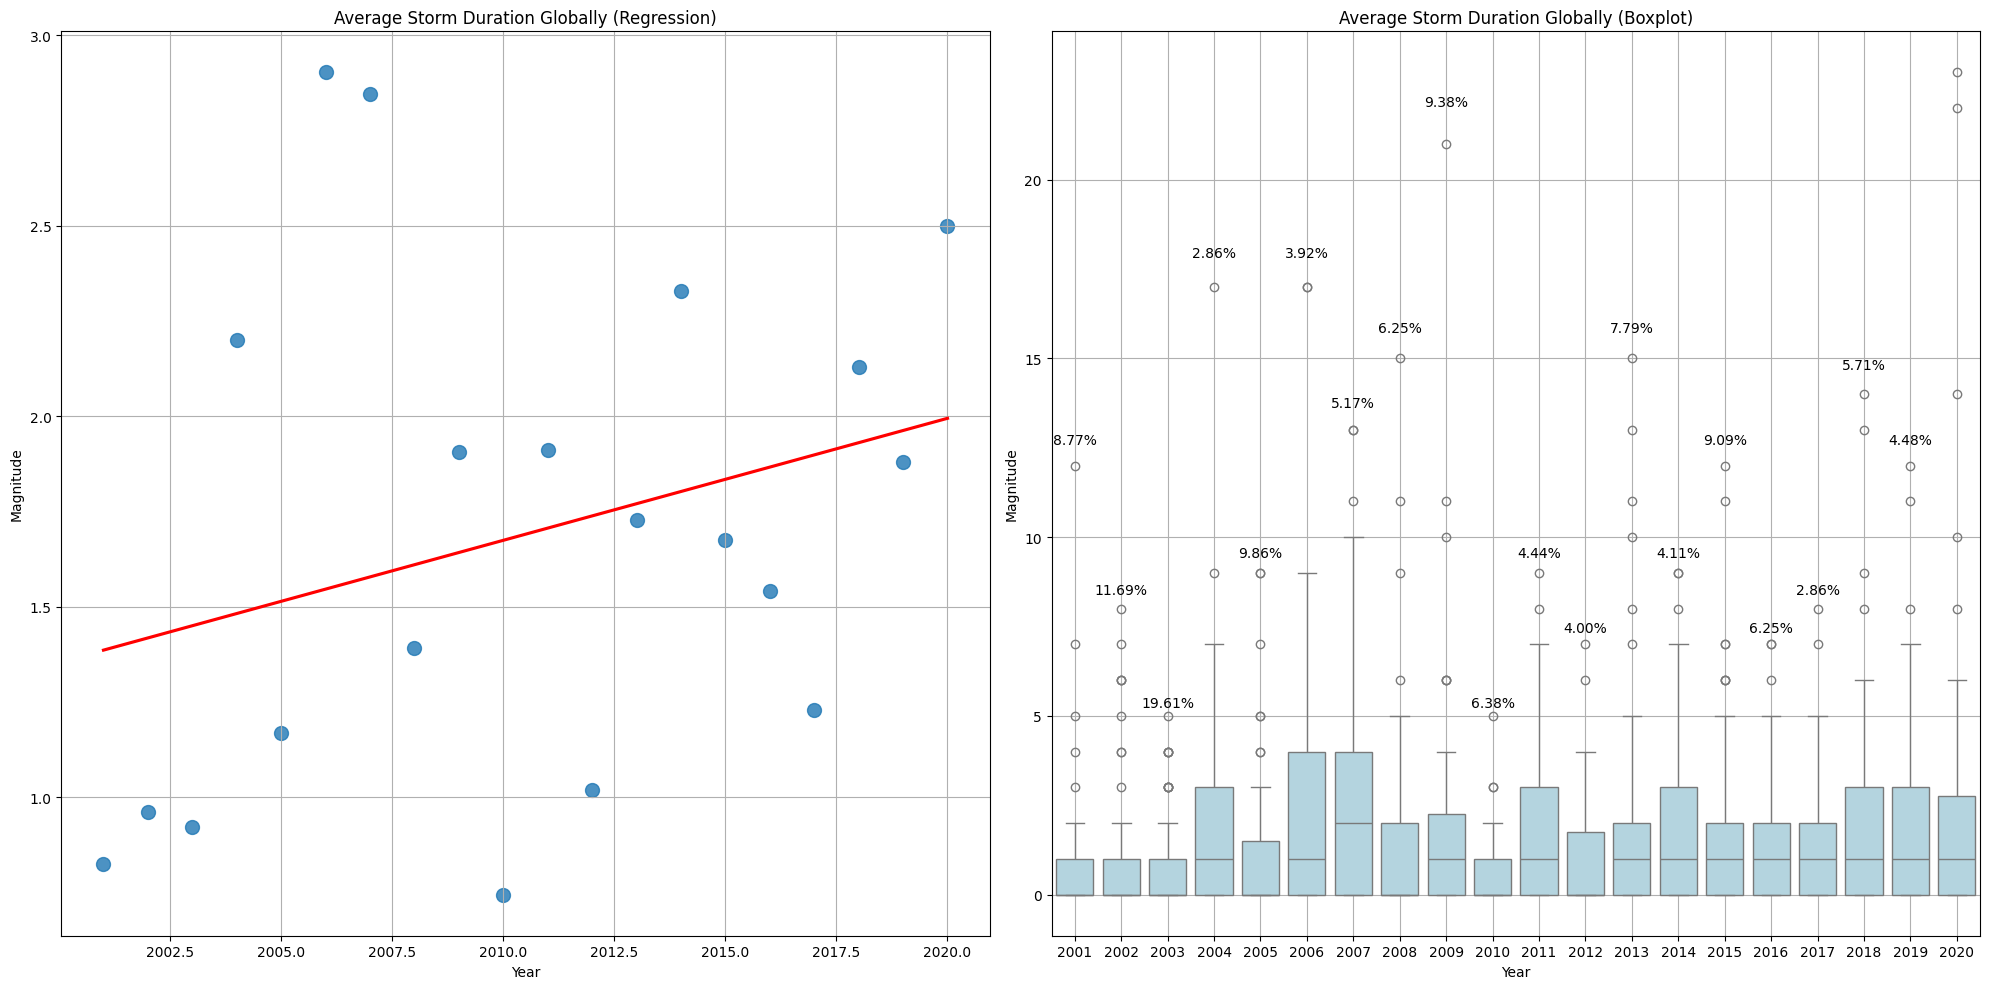

In [18]:
for d in disaster_types:
    for var in ["Dis Mag Value", "Duration"]:
        emdat_filter2 = emdat[emdat["Disaster Type"] == d]
        emdat_filter2 = emdat_filter2[["Year", "Dis Mag Value", "Duration"]]
        emdat_filter2 = emdat_filter2[emdat_filter2["Year"] > 2000]
        grouped_emdat = emdat_filter2.groupby(['Year']).mean().reset_index()

        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))  # Create a figure and a set of subplots with 1 row and 2 columns
        # First plot - Regression plot
        sns.regplot(x=grouped_emdat['Year'], y=grouped_emdat[var],

                    scatter_kws={'s': 100}, line_kws={'color': 'red'}, ci=None, ax=axs[0])
        axs[0].set_title(f"Average {d} {var} Globally (Regression)")
        axs[0].set_xlabel('Year')
        axs[0].set_ylabel('Magnitude')
        axs[0].grid(True)

        # Calculate Q1, Q3, and IQR for each year
        Q1 = emdat_filter2.groupby('Year')[var].quantile(0.25)
        Q3 = emdat_filter2.groupby('Year')[var].quantile(0.75)
        IQR = Q3 - Q1

        # Define bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Count outliers for each year
        outliers = emdat_filter2.apply(lambda x: (x[var] > upper_bound[x['Year']]), axis=1)
        outlier_counts = outliers.groupby(emdat_filter2['Year']).sum()

        # Count total observations for each year
        total_counts = emdat_filter2.groupby('Year').size()

        # Calculate the proportion of outliers for each year
        outlier_proportions = outlier_counts / total_counts

        # Second plot - Boxplot
        sns.boxplot(x='Year', y=var, data=emdat_filter2, color='lightblue', ax=axs[1])
        axs[1].set_title(f"Average {d} {var} Globally (Boxplot)")
        axs[1].set_xlabel('Year')
        axs[1].set_ylabel('Magnitude')
        axs[1].grid(True)

        for year in range(2001, 2020):

            # Calculate the y position for the annotation
            # Place the text 5% above the maximum value or upper bound, whichever is higher
            y_pos = max(emdat_filter2[emdat_filter2['Year'] == year][var].max(), upper_bound[year]) * 1.05

            # Proportion as a percentage
            prop_text = f"{outlier_proportions[year]:.2%}"

            # Place the text on the plot
            plt.text(year - 2001, y_pos, prop_text, ha='center')

        # Show the plots side by side
        plt.tight_layout()
        plt.show()


We see some trending, but the proportion of outliers seems somewhat consistent.

Let's look at the distribution of outliers vs nonoutliers

In [19]:
def outlier_seperation(df, type, var):
    emdat_filter = df[df["Disaster Type"] == type]
    emdat_filter = emdat_filter[emdat_filter["Year"] > 1961]
    # Calculate Q1, Q3, and IQR for each year
    Q1 = emdat_filter.groupby('Year')[var].quantile(0.25)
    Q3 = emdat_filter.groupby('Year')[var].quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count outliers for each year
    outliers = emdat_filter.apply(lambda x: (x[var] > upper_bound[x['Year']]), axis=1)

    # Creating a DataFrame for outliers
    outliers_df = emdat_filter[outliers]

    # Creating a DataFrame for non-outliers
    non_outliers_df = emdat_filter[~outliers]

    return outliers_df, non_outliers_df

def plotTrend(emdat, type, var):
    emdat_filter2 = emdat[emdat["Disaster Type"] == type]
    emdat_filter2 = emdat_filter2[["Year", var]]
    emdat_filter2 = emdat_filter2[emdat_filter2["Year"] > 2000]
    grouped_emdat = emdat_filter2.groupby(['Year']).mean().reset_index()


    # Plotting side by side

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))  # Create a figure and a set of subplots with 1 row and 2 columns
    # First plot - Regression plot
    sns.regplot(x=grouped_emdat['Year'], y=grouped_emdat[var],

                scatter_kws={'s': 100}, line_kws={'color': 'red'}, ci=None, ax=axs[0])
    axs[0].set_title(f"Average {type} {var} Globally (Regression)")
    axs[0].set_xlabel('Year')
    axs[0].set_ylabel(var)
    axs[0].grid(True)

    # Second plot - Boxplot
    sns.boxplot(x='Year', y=var, data=emdat_filter2, color='lightblue', ax=axs[1])
    axs[1].set_title(f"Average {type} {var} Globally (Boxplot)")
    axs[1].set_xlabel('Year')
    axs[1].set_ylabel(var)
    axs[1].grid(True)

    # Show the plots side by side
    plt.tight_layout()
    plt.show()

Non Outliers


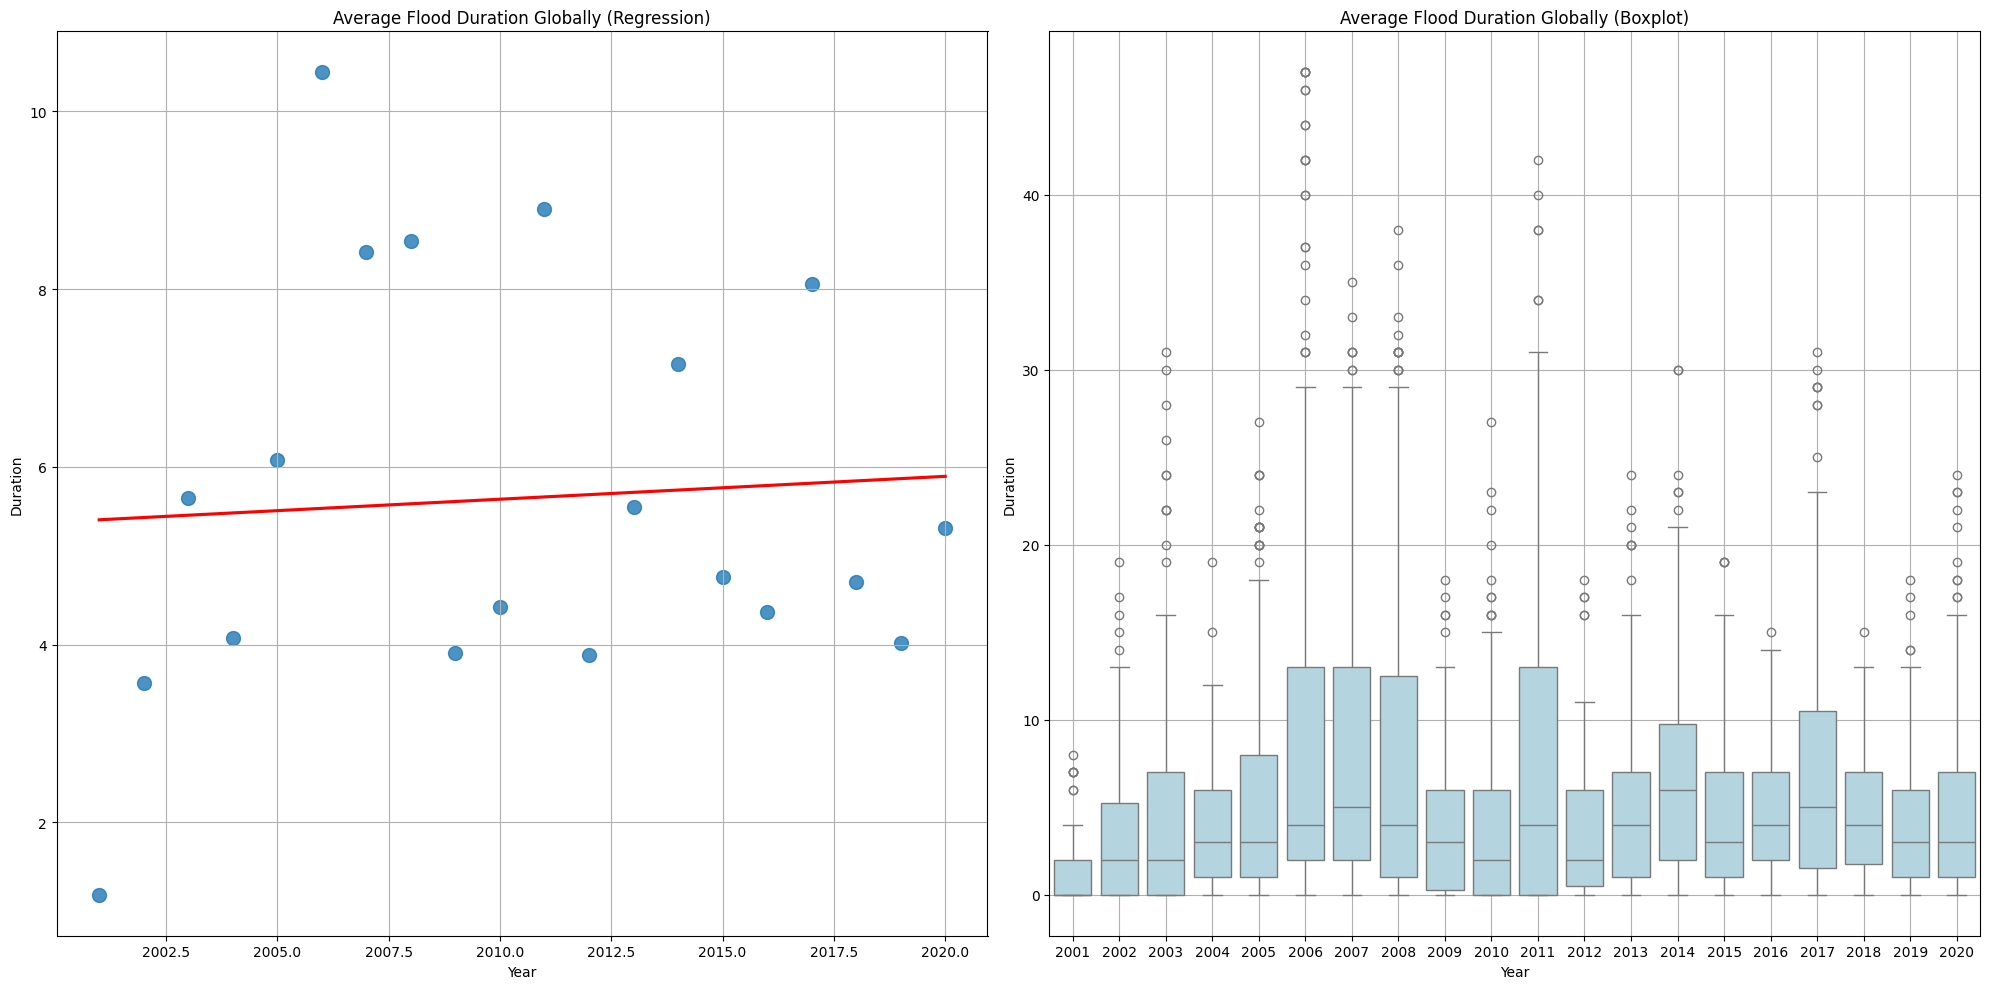

Outliers


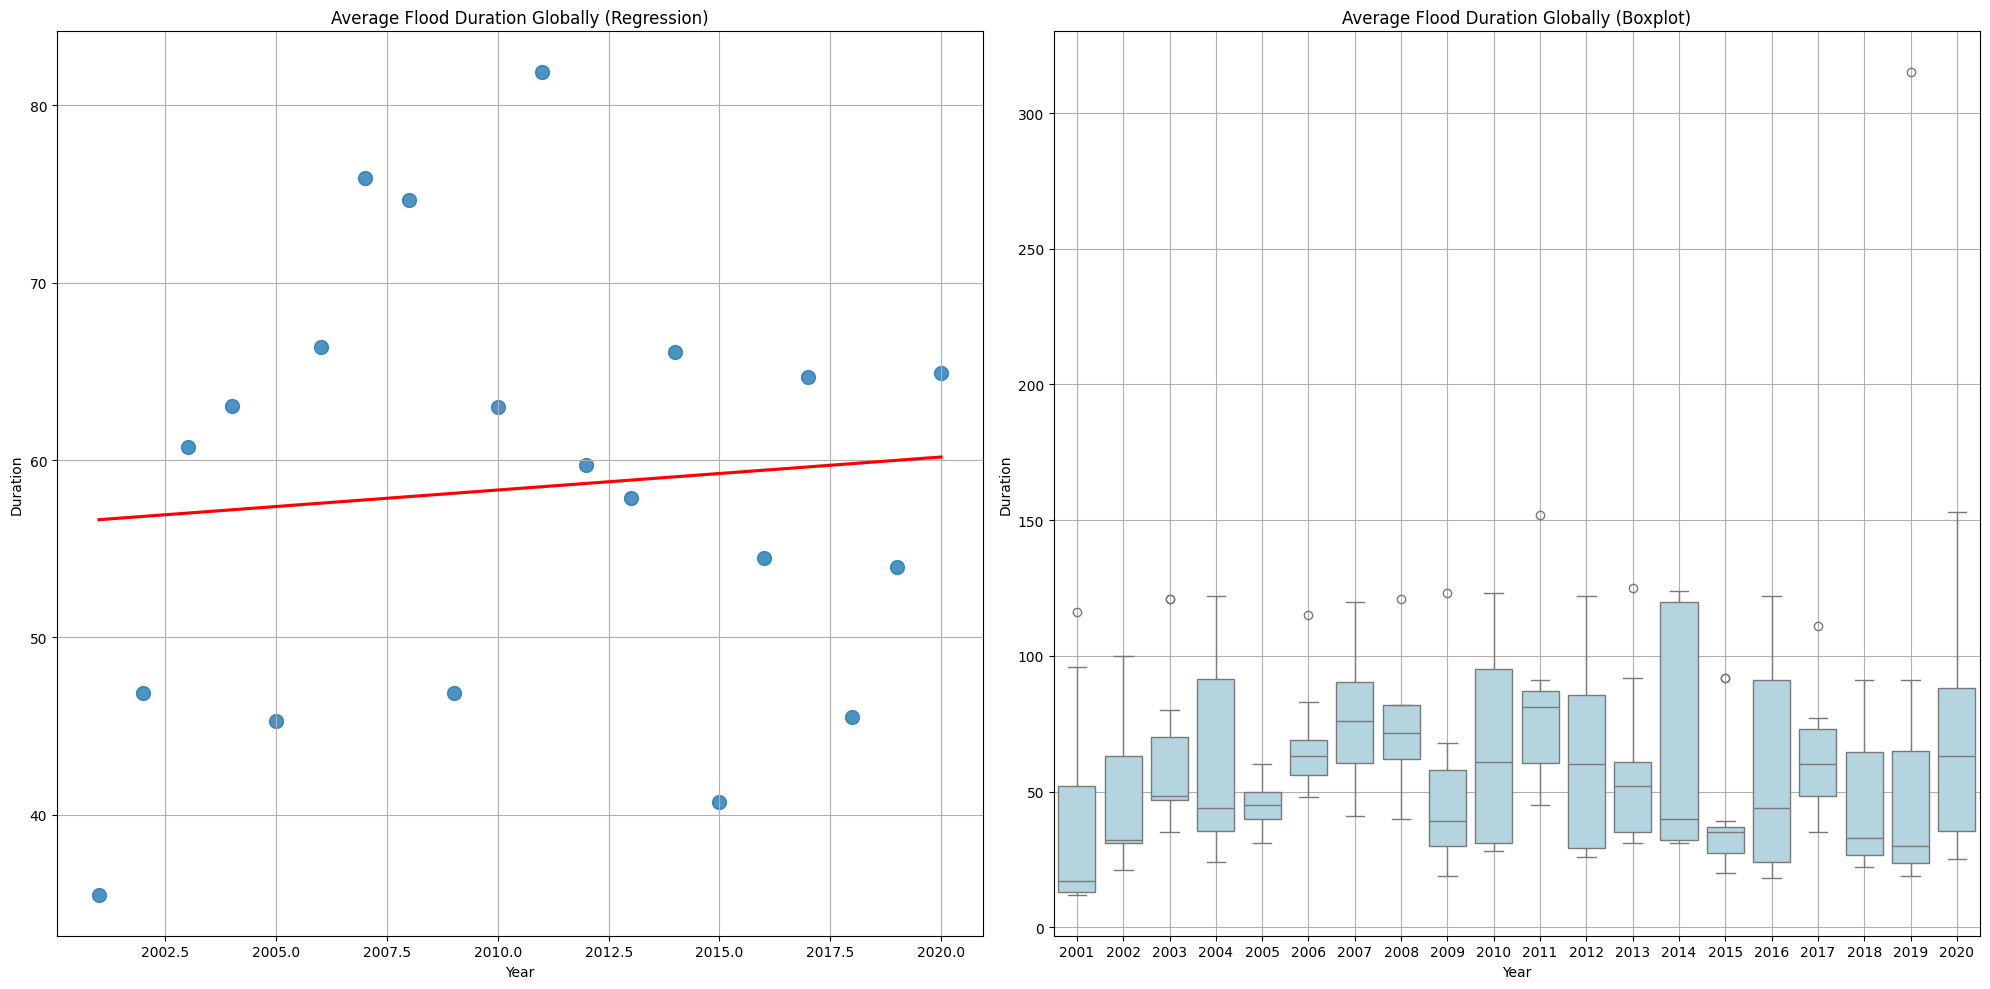

Non Outliers


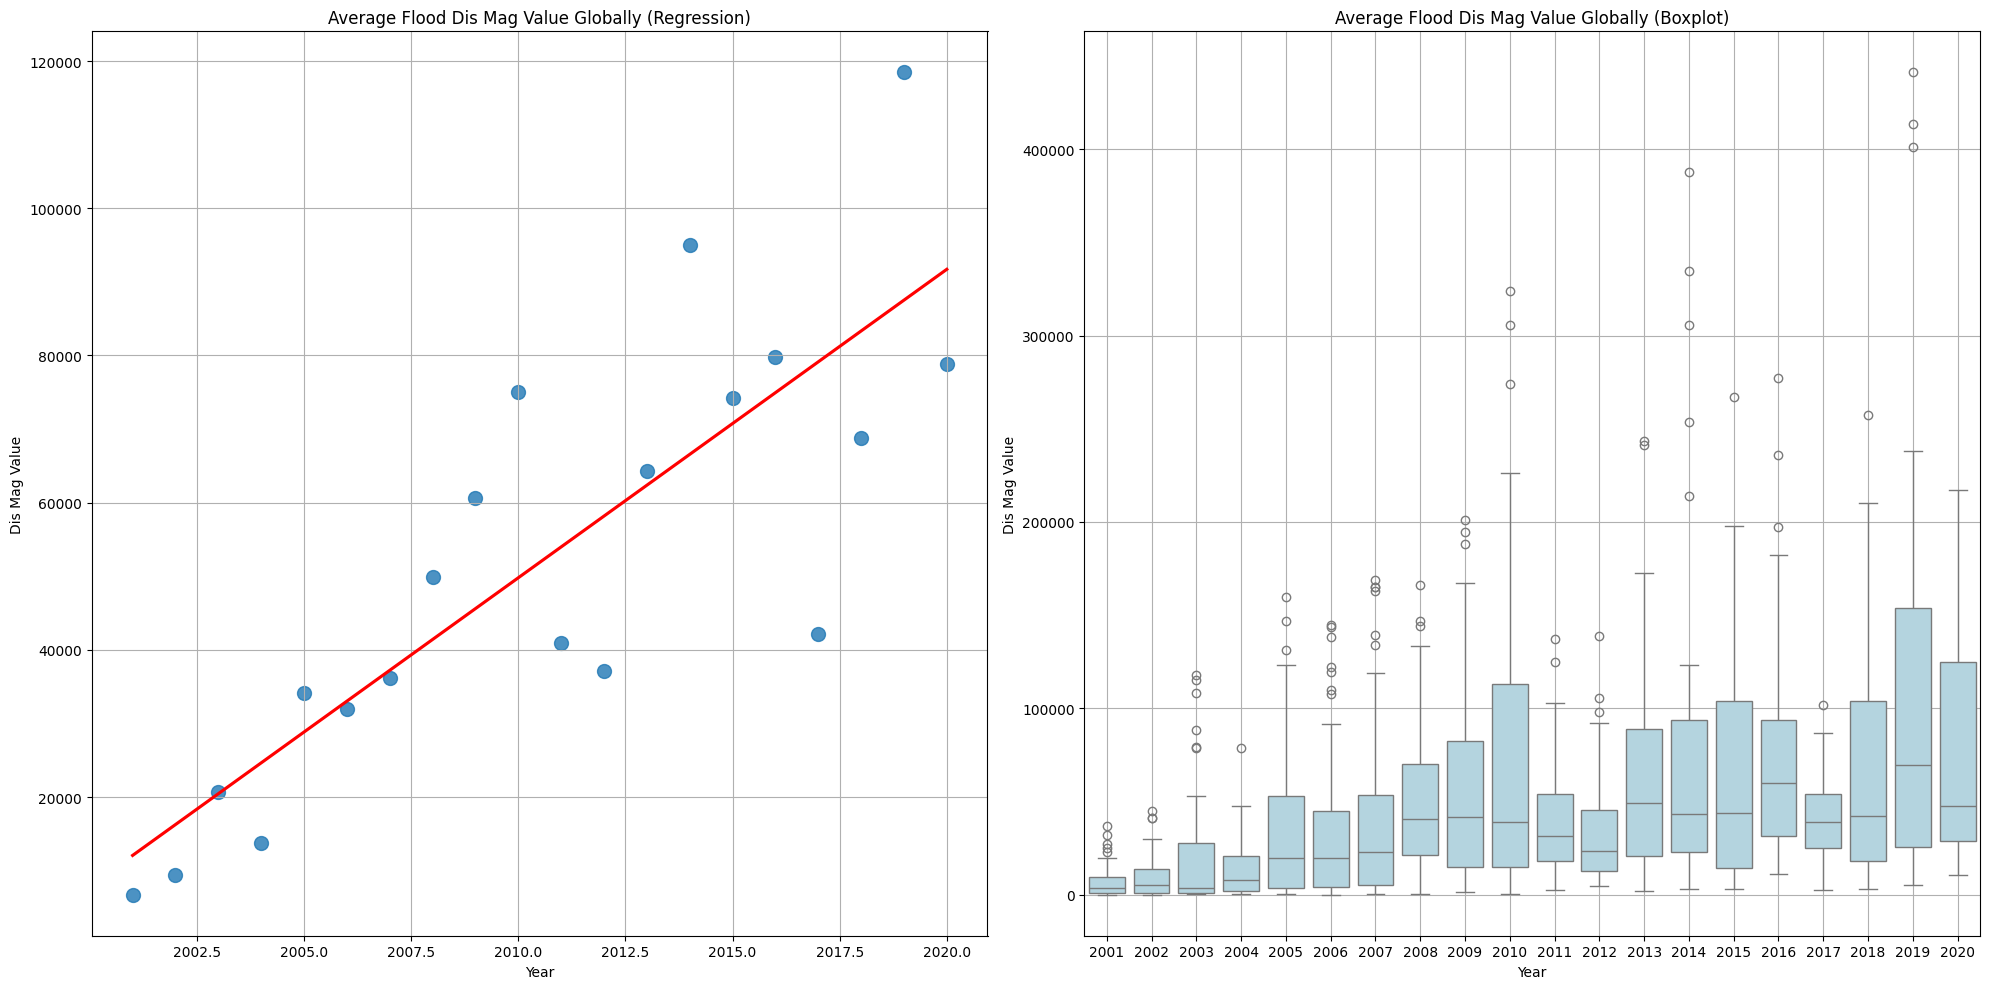

Outliers


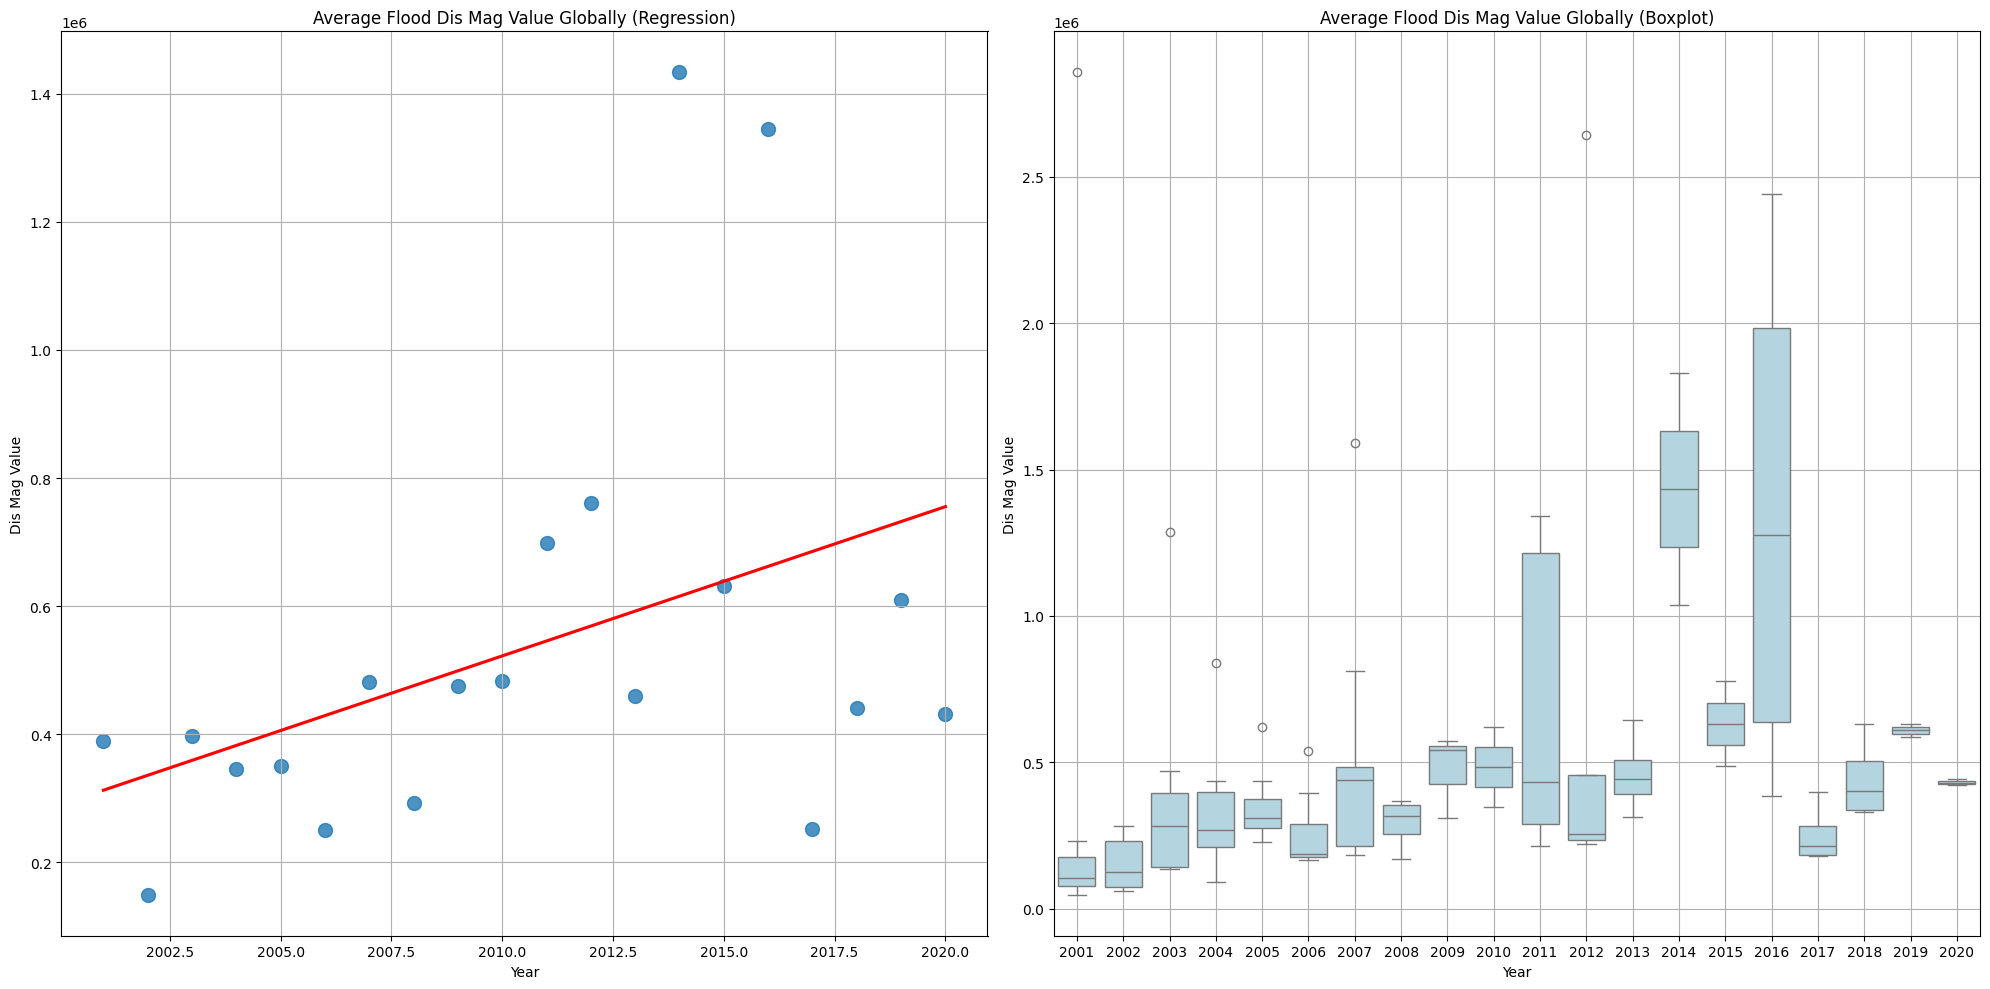

In [20]:
outliers_FloodMag, nonoutliers_FloodMag = outlier_seperation(emdat, "Flood", "Dis Mag Value")
outliers_FloodDuration, nonoutliers_FloodDuration = outlier_seperation(emdat, "Flood", "Duration")
outliers_StormDuration, nonoutliers_StormDuration = outlier_seperation(emdat, "Storm", "Duration")
outliers_StormMag, nonoutliers_StormMag = outlier_seperation(emdat, "Storm", "Dis Mag Value")

print("Non Outliers")
plotTrend(nonoutliers_FloodDuration, "Flood", "Duration")
print("Outliers")
plotTrend(outliers_FloodDuration, "Flood", "Duration")
print("Non Outliers")
plotTrend(nonoutliers_FloodMag, "Flood", "Dis Mag Value")
print("Outliers")
plotTrend(outliers_FloodMag, "Flood", "Dis Mag Value")

Non Outliers


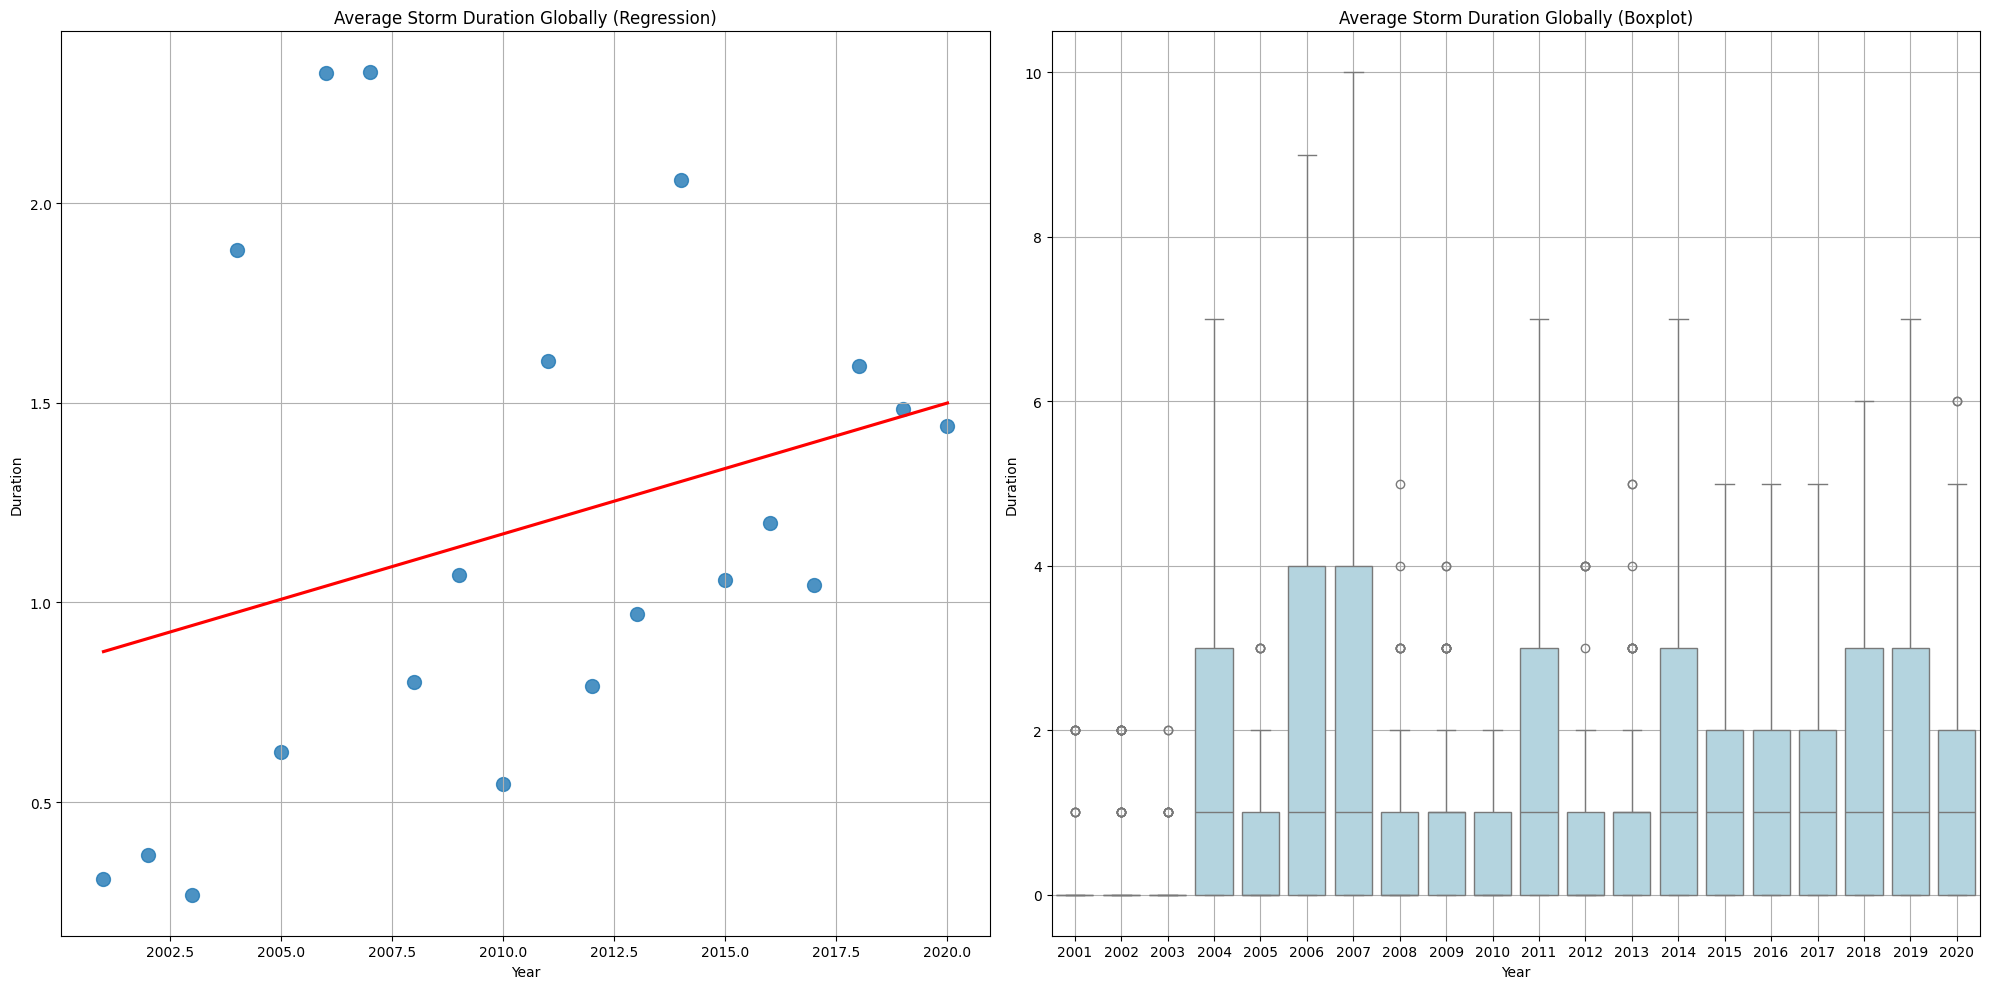

Outliers


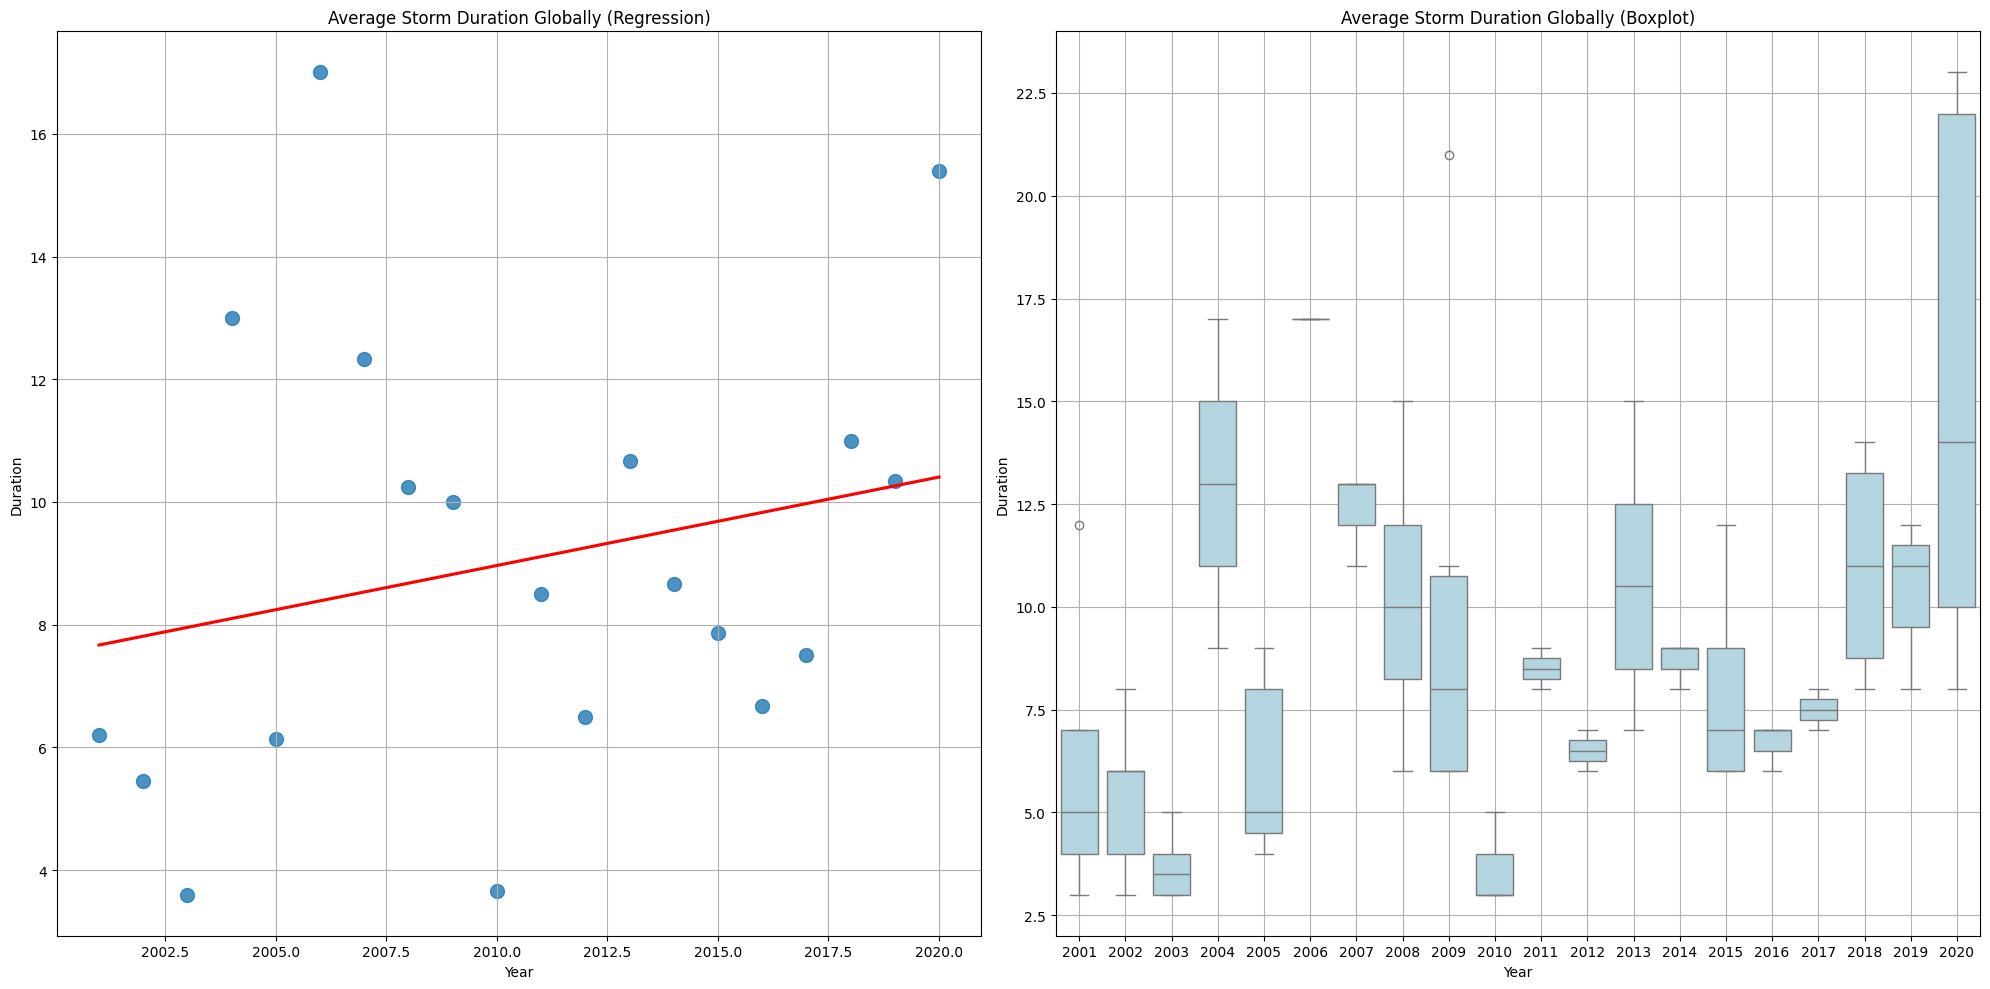

Non Outliers


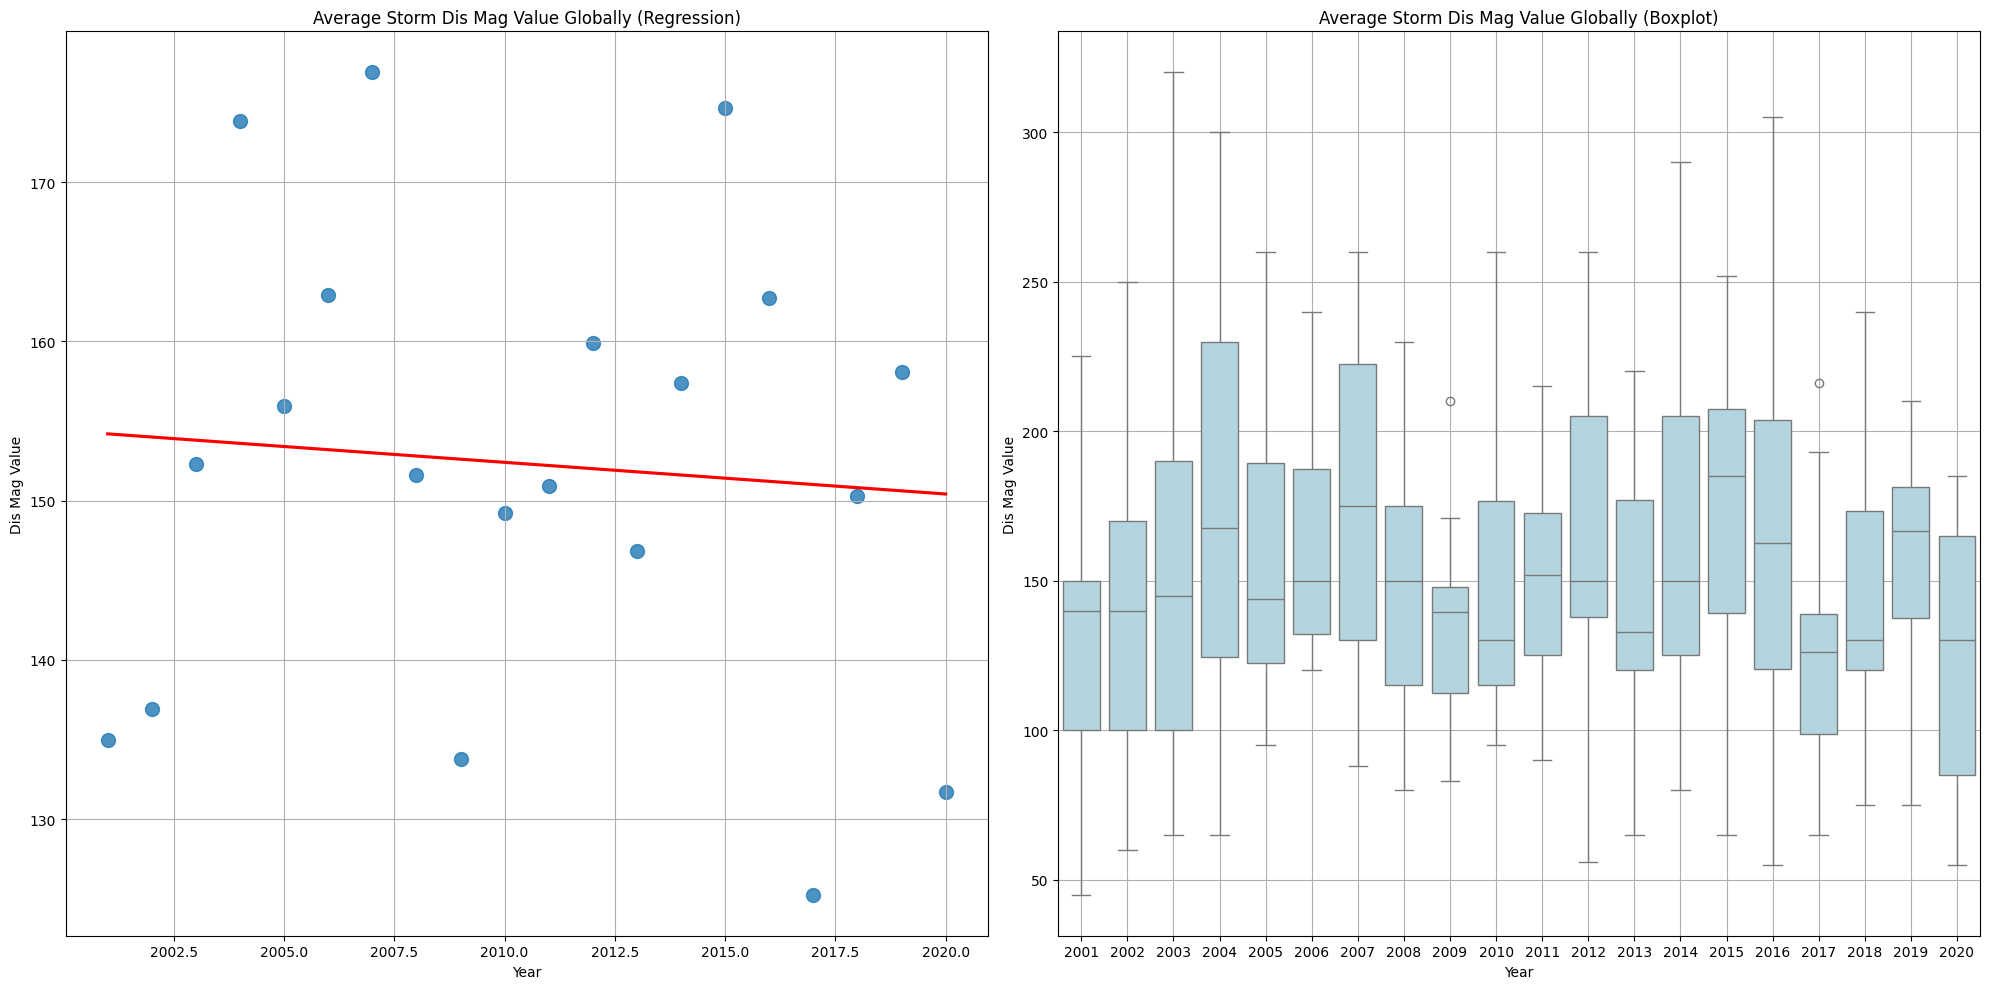

Outliers


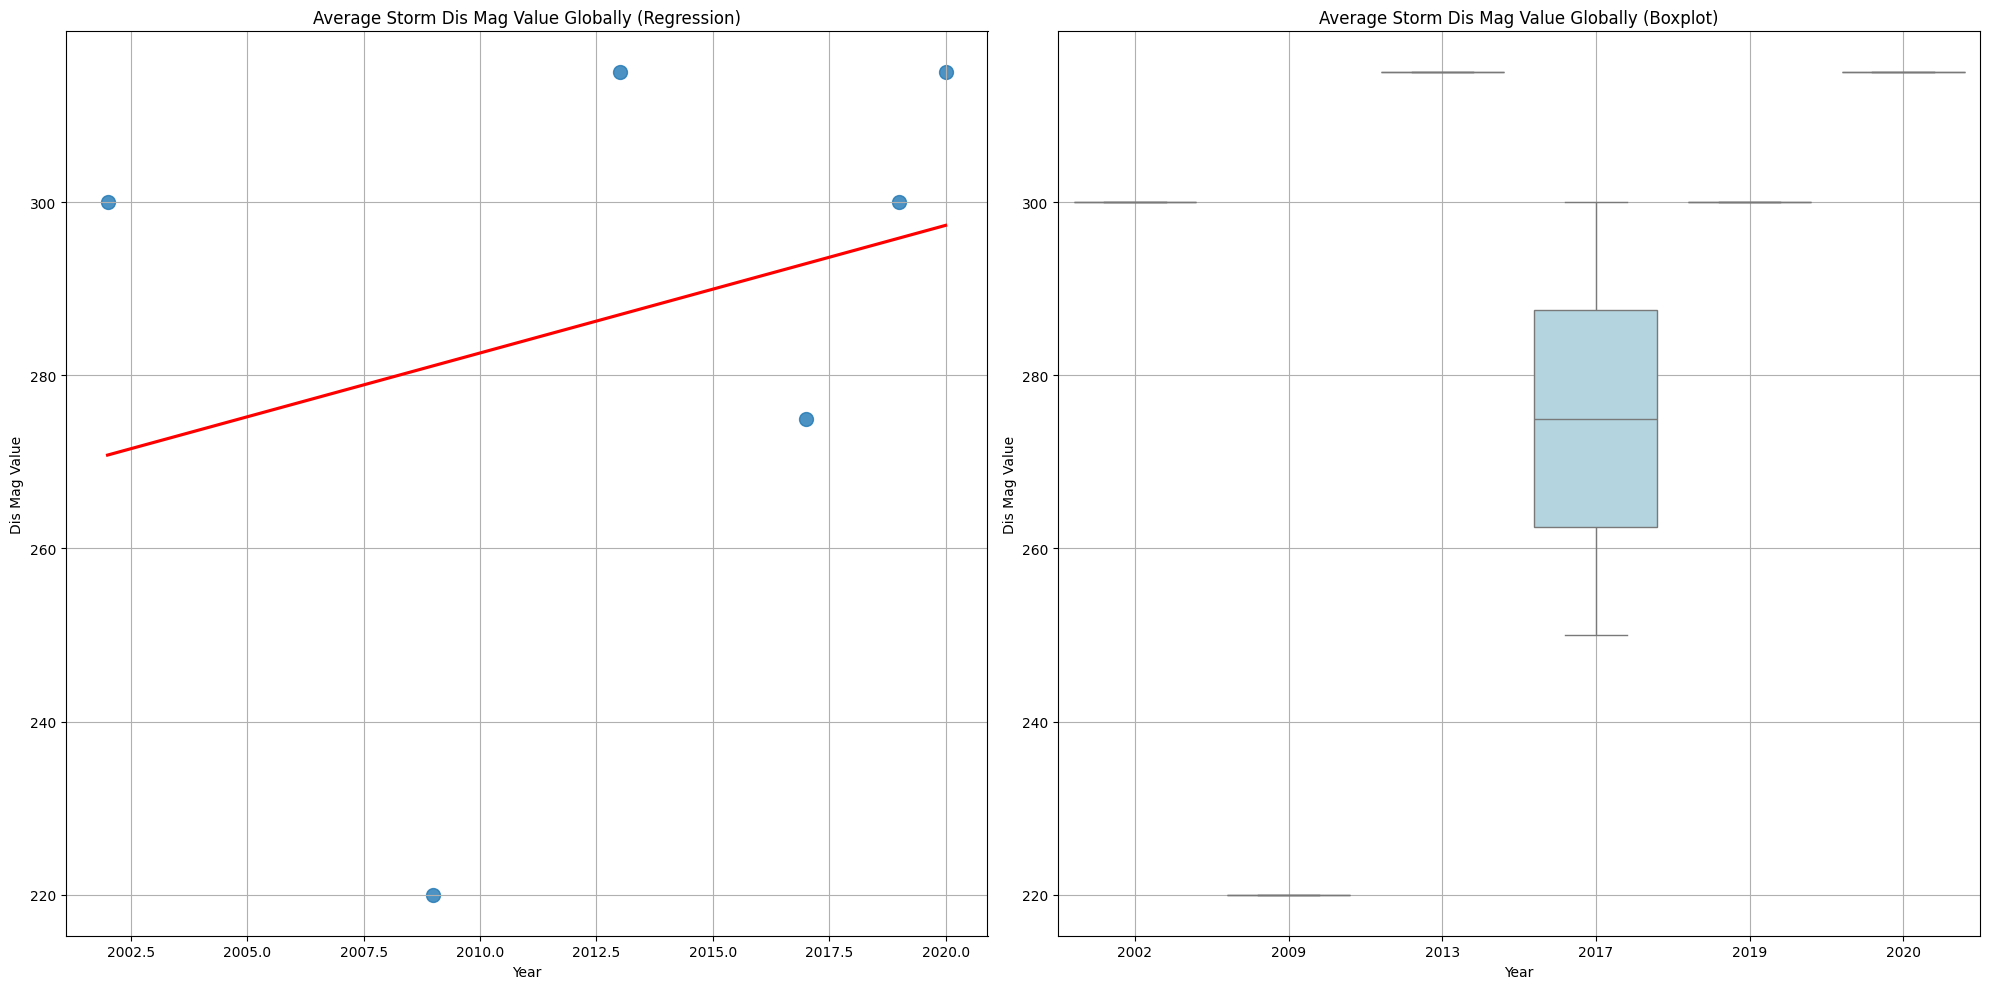

In [21]:
print("Non Outliers")
plotTrend(nonoutliers_StormDuration, "Storm", "Duration")
print("Outliers")
plotTrend(outliers_StormDuration, "Storm", "Duration")
print("Non Outliers")
plotTrend(nonoutliers_StormMag, "Storm", "Dis Mag Value")
print("Outliers")
plotTrend(outliers_StormMag, "Storm", "Dis Mag Value")

We see an increasing trend for flood magnitudes and storm durations. Could be a positive correlation with temperature.

## Effects on homelessness

Let's look at some effects of disasters on homelessness

Flood  in  ['Southern Asia', 'Eastern Asia', 'South-Eastern Asia', 'Central Asia', 'Western Asia']


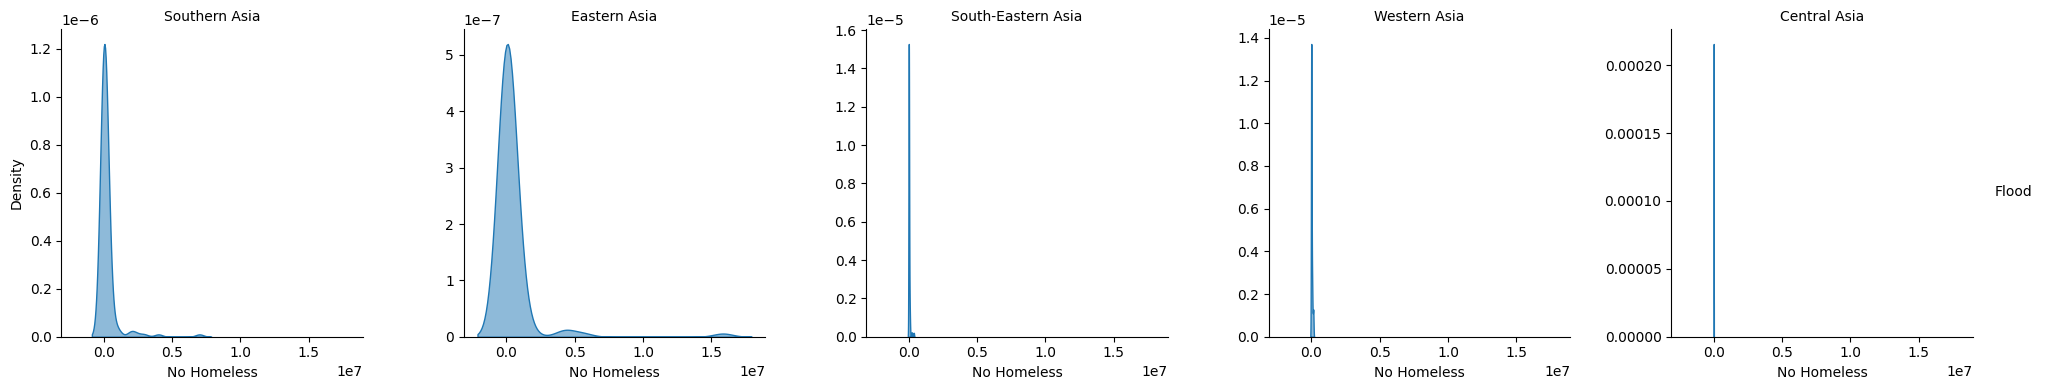

Flood  in  ['Russian Federation', 'Eastern Europe', 'Western Europe', 'Northern Europe', 'Southern Europe']


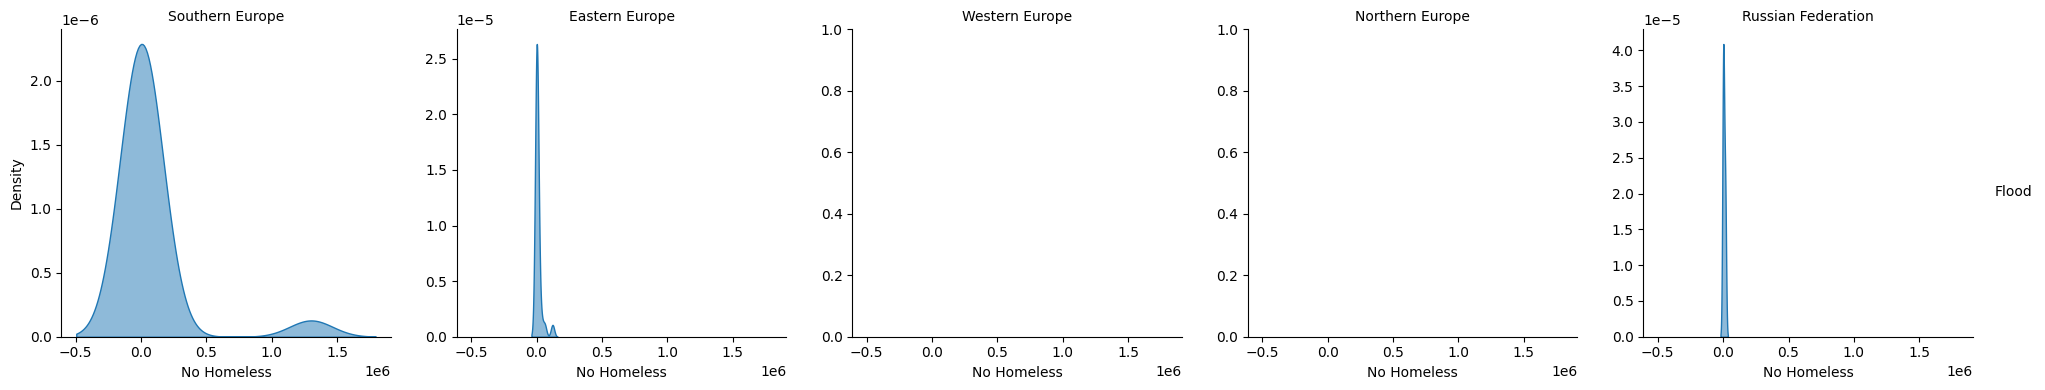

Flood  in  ['Northern Africa', 'Eastern Africa', 'Middle Africa', 'Southern Africa', 'Western Africa']


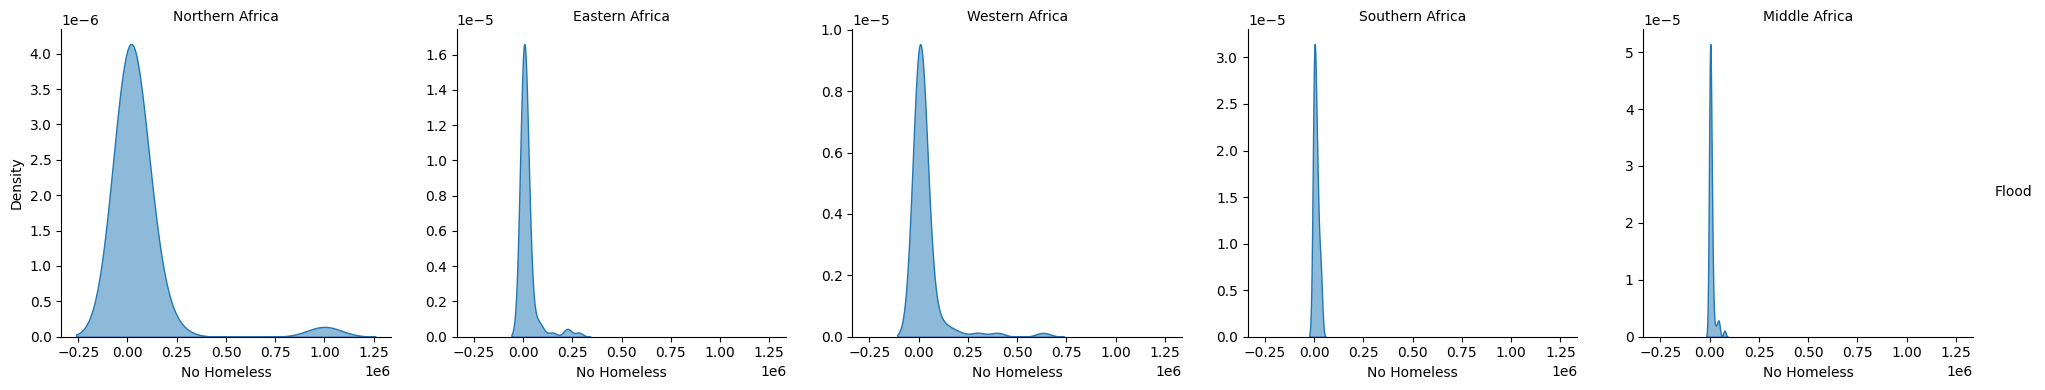

Storm  in  ['Southern Asia', 'Eastern Asia', 'South-Eastern Asia', 'Central Asia', 'Western Asia']


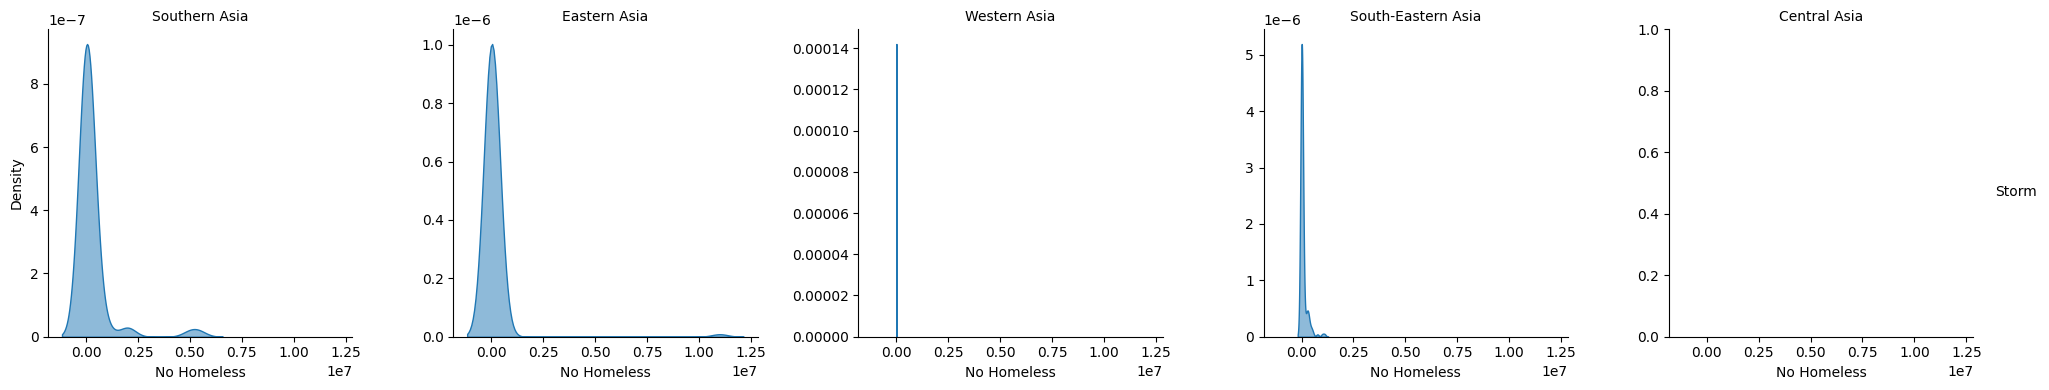

Storm  in  ['Russian Federation', 'Eastern Europe', 'Western Europe', 'Northern Europe', 'Southern Europe']


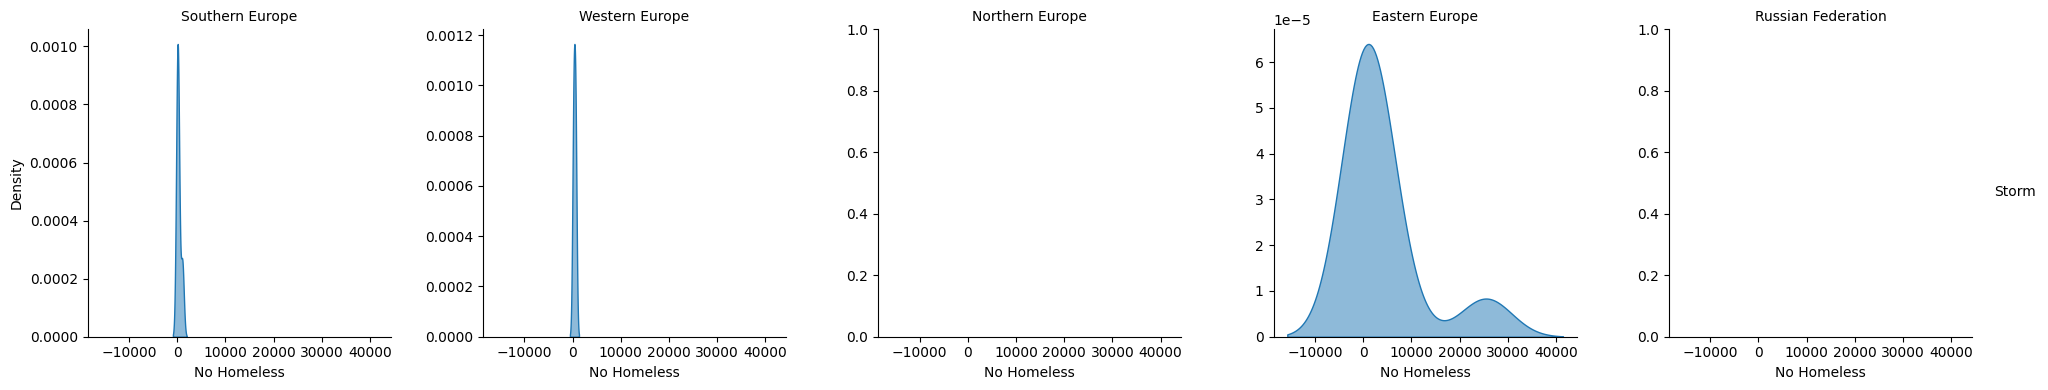

Storm  in  ['Northern Africa', 'Eastern Africa', 'Middle Africa', 'Southern Africa', 'Western Africa']


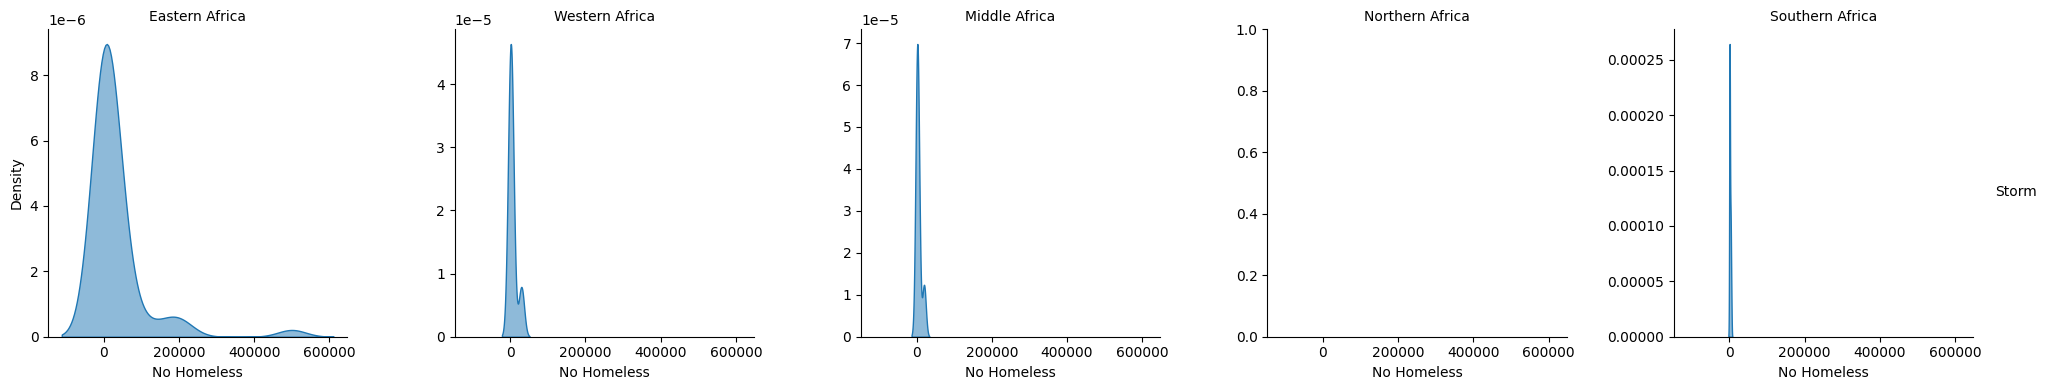

In [22]:
disaster_types = ["Flood", "Storm"]
# Plotting
for d in disaster_types:
    df = emdat_filter[emdat_filter["Disaster Type"] == d]
    for r in region_groups:
        print(d," in ",[x for x in r])
        dfr = df[df["Region"].isin(r)]
        g = sns.FacetGrid(dfr, col="Region", height=4, sharey=False)
        g.map_dataframe(sns.kdeplot, "No Homeless", fill=True, common_norm=False, alpha=0.5, warn_singular=False)

        g.set_titles("{col_name}")
        g.set_axis_labels("No Homeless", "Density")
        g.add_legend(title=d)
        plt.show()

For many regions we see multiple peaks in the KDEplots - it could seem that we might have multiple distributions, one for "normal disasters" and one for extreme disasters.

Let's look at the histograms of homelessness caused by the disasters

/tmp/ipykernel_9249/163729393.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emdat_filter["No Homeless"] = emdat_filter["No Homeless"].fillna(0)


<Axes: xlabel='No Homeless', ylabel='Count'>

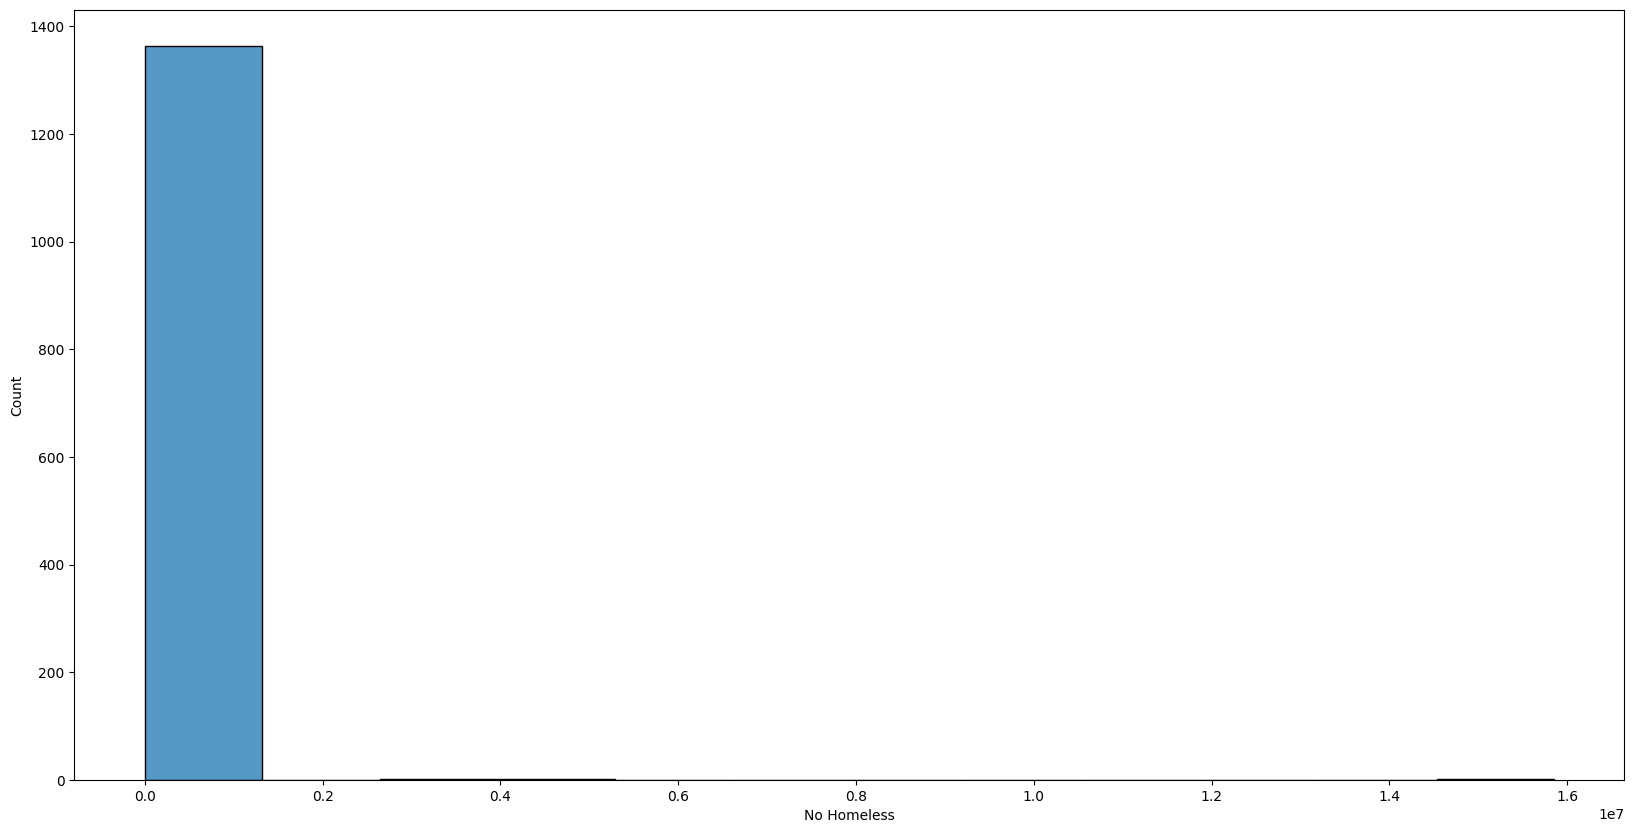

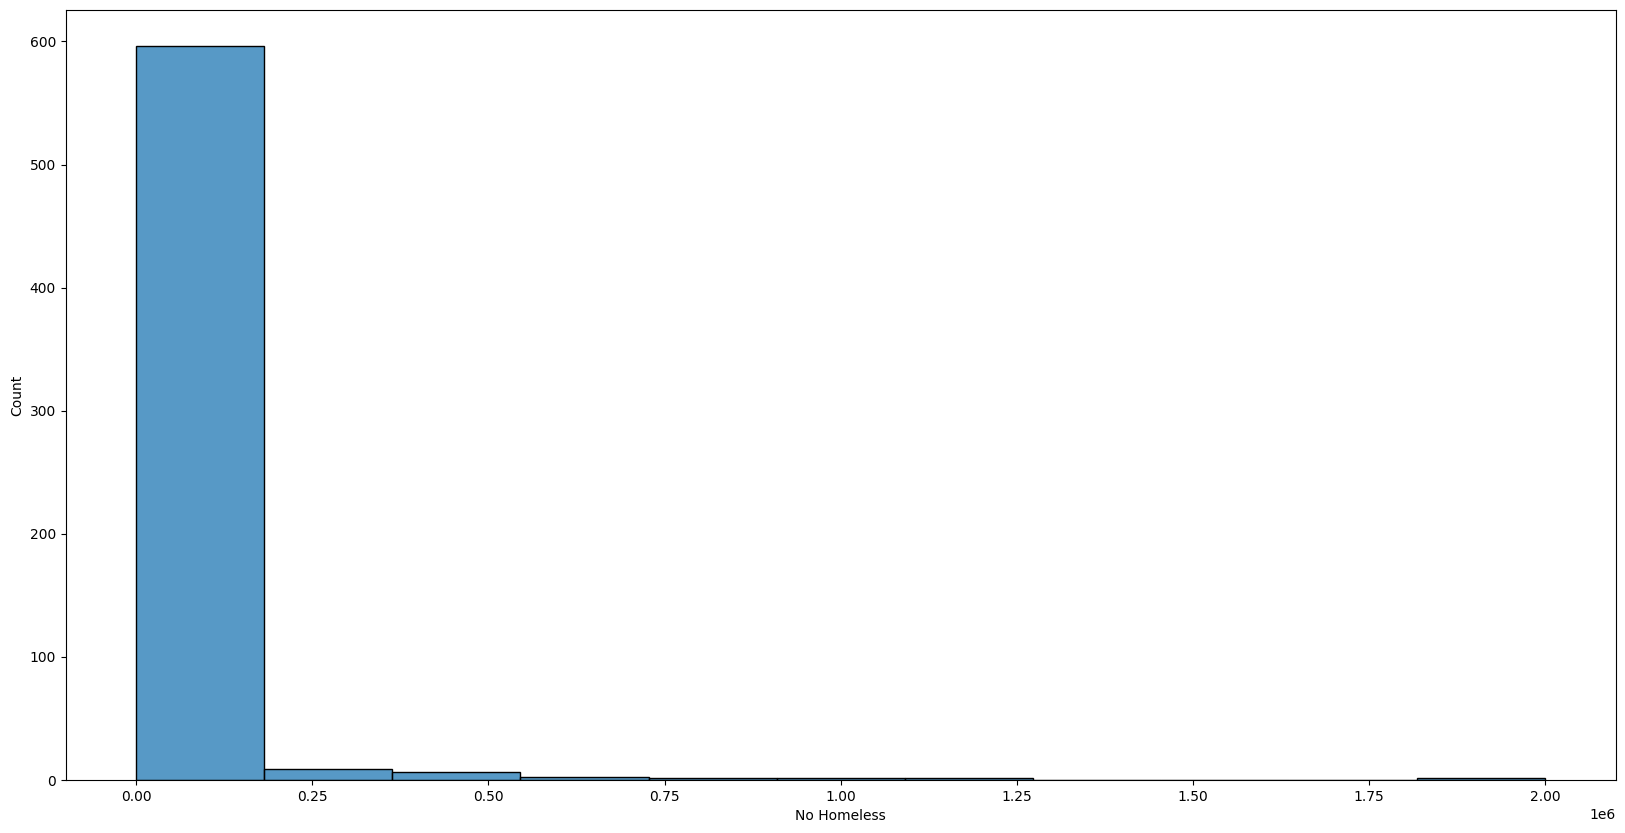

In [23]:
emdat_filter = emdat[emdat["Dis Mag Value"] > 0]
emdat_filter["No Homeless"] = emdat_filter["No Homeless"].fillna(0)

plt.figure(figsize=(20,10))
sns.histplot(emdat_filter[(emdat_filter["Disaster Type"] == "Flood")]["No Homeless"])

plt.figure(figsize=(20,10))
sns.histplot(emdat_filter[(emdat_filter["Disaster Type"] == "Storm")]["No Homeless"])

We have a lot of disasters which did not cause homelessness. Let's only look at the ones that caused homelessness

<Axes: xlabel='No Homeless', ylabel='Count'>

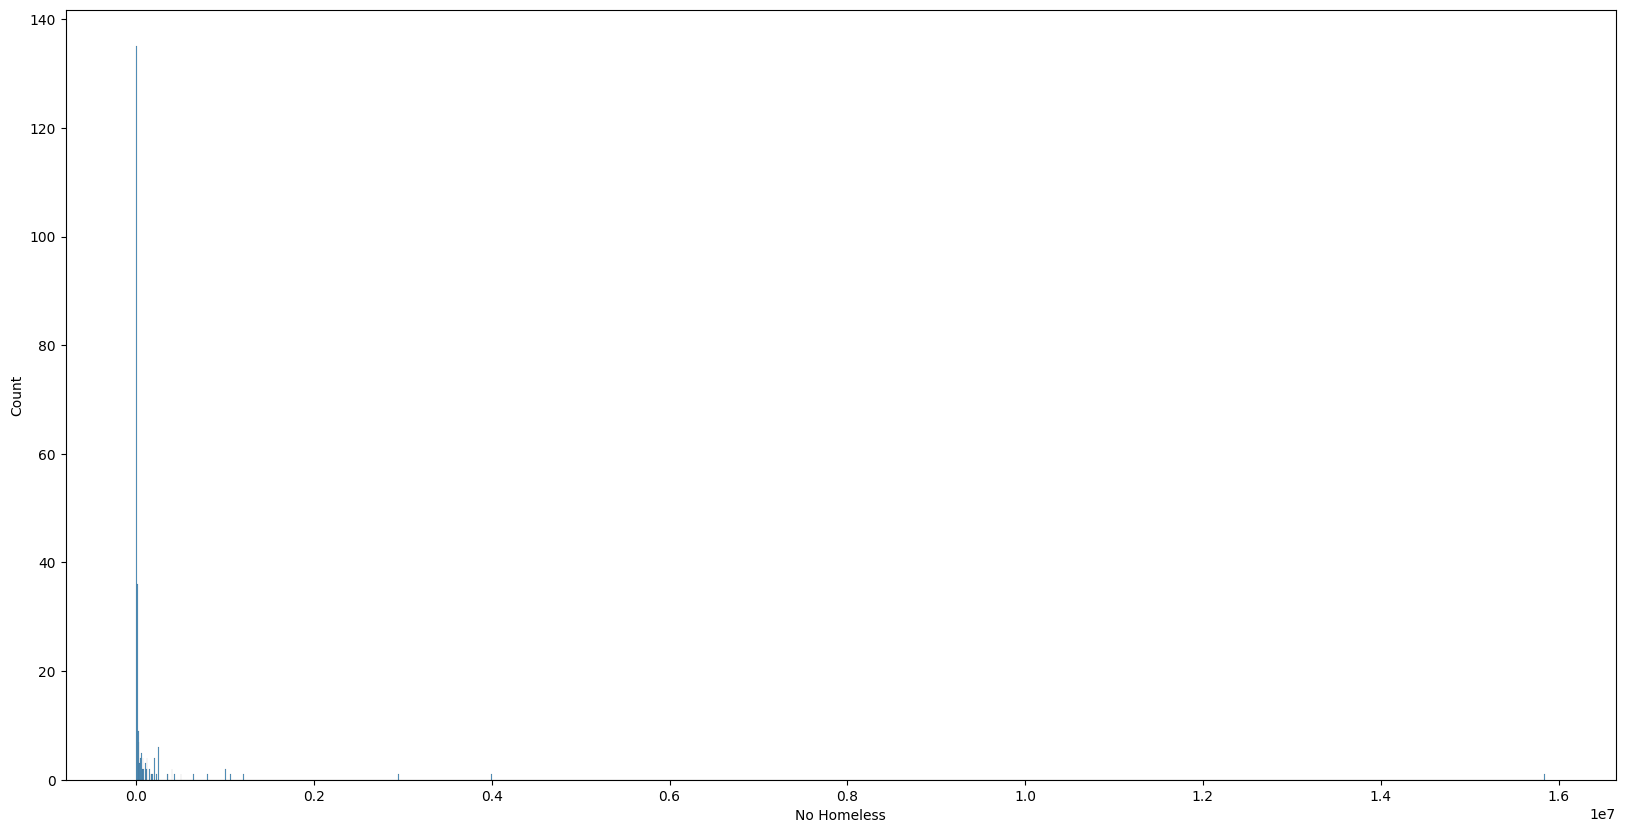

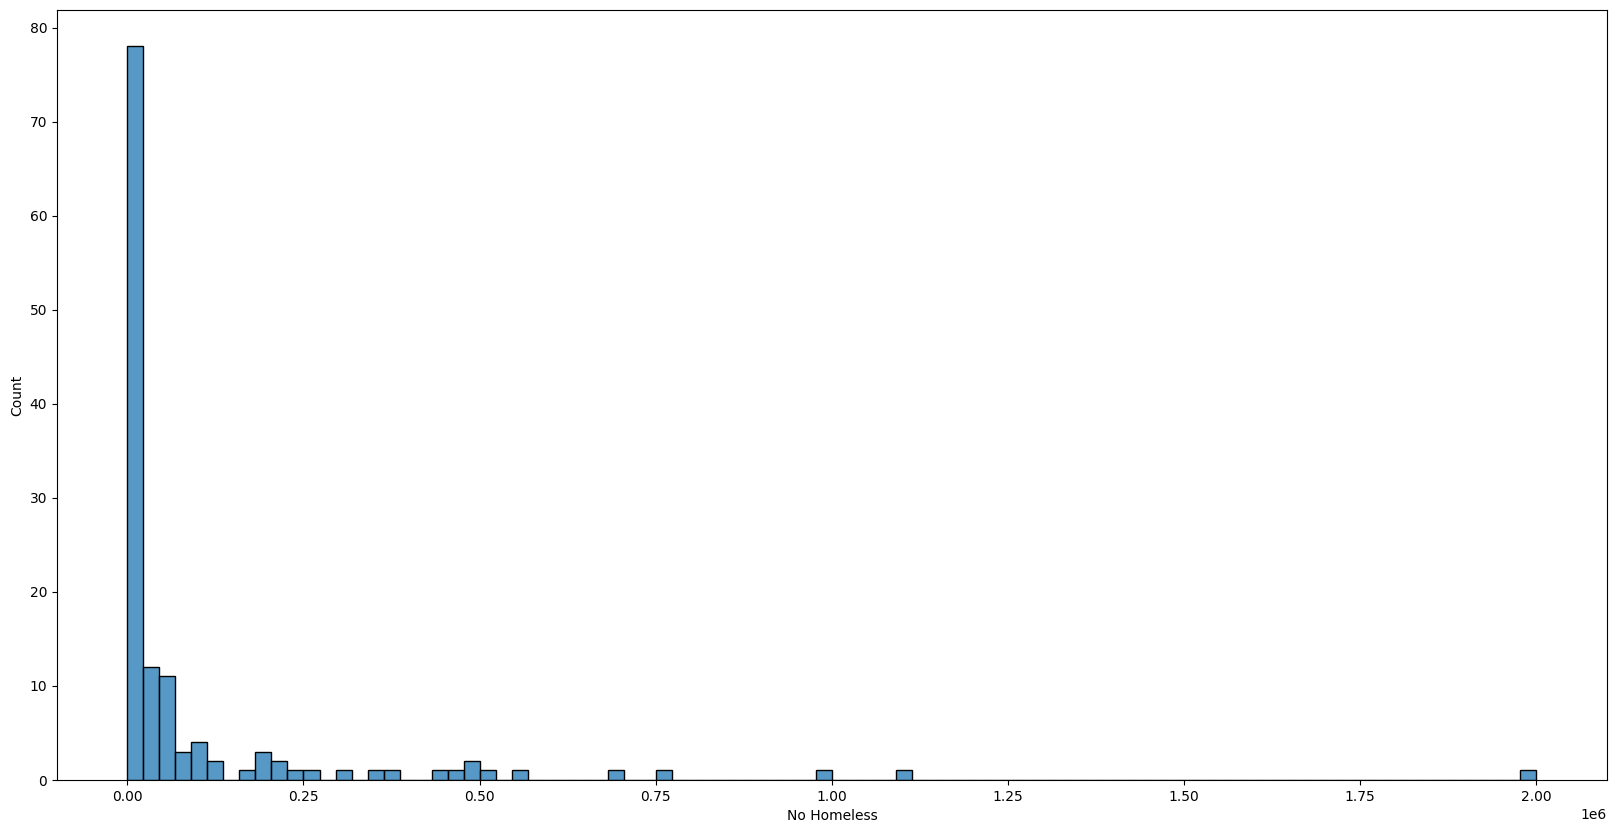

In [24]:
# Only disasters that caused homelessness
plt.figure(figsize=(20,10))
sns.histplot(emdat_filter[(emdat_filter["No Homeless"] > 0) & (emdat_filter["Disaster Type"] == "Flood")]["No Homeless"])

# Only disasters that caused homelessness
plt.figure(figsize=(20,10))
sns.histplot(emdat_filter[(emdat_filter["No Homeless"] > 0) & (emdat_filter["Disaster Type"] == "Storm")]["No Homeless"])

Let's realign the scales from absolute numbers to percentage of homelessness

In [25]:
#########################
# LOAD POPULATION DENSITY DATA
#########################

pop = pd.read_csv("data/country_pop.csv")
pop = pop.drop(["Country Name", "Indicator Name", "Indicator Code"],axis=1)
pop = pd.melt(pop, id_vars=['Country Code'], var_name='Year', value_name='Value')
pop.rename(columns={"Country Code":"ISO", "Value":"Pop"} ,inplace=True)
pop = pop.dropna()
size = pd.read_csv("data/country_size.csv")
size = size.drop(["Country Name", "Indicator Name", "Indicator Code"],axis=1)
size = pd.melt(size, id_vars=['Country Code'], var_name='Year', value_name='Value')
size.rename(columns={"Country Code":"ISO", "Value":"Size"},inplace=True)
size = size.dropna()
popsize = pd.merge(size,pop, on=["ISO","Year"],how="left")
popsize["Year"] = popsize["Year"].astype(int)
popsize["Popdens"] = popsize["Pop"]/popsize["Size"]

In [26]:
emdat_filter = emdat_filter[emdat_filter["Year"] >= 2000]
emdat_filter = emdat_filter[emdat_filter["Year"] <= 2022]
emdat_filter["Duration"] = emdat_filter["Duration"].clip(lower=1)
emdat_filter["Dis Mag Value"] = emdat_filter["Dis Mag Value"].clip(lower=0)
emdat_filter['Disp'] = emdat_filter['No Homeless'].apply(lambda x: 1 if x > 0 else 0).astype(int)
emdat_filter['Disp'] = emdat_filter['No Homeless'].apply(lambda x: 1 if x > 0 else 0).astype(int)
regions = emdat_filter["Region"].unique()

In [27]:
X_s = pd.merge(emdat_filter,popsize, on=["Year","ISO"],how="left")
X_s["Homeless_pct"] = X_s["No Homeless"] / X_s["Pop"]
y_s = X_s["Disp"]
X_s = X_s.drop("Disp",axis=1)
X_s["Year"] = X_s["Year"] - 2000
#X = pd.get_dummies(X, columns=['Region'])
# Convert all boolean columns in the DataFrame to integers (0 or 1)
bool_columns = X_s.select_dtypes(include=['bool']).columns
X_s[bool_columns] = X_s[bool_columns].astype(int)

Let's see the distribution of percentage of homelessness

<Axes: xlabel='Homeless_pct', ylabel='Count'>

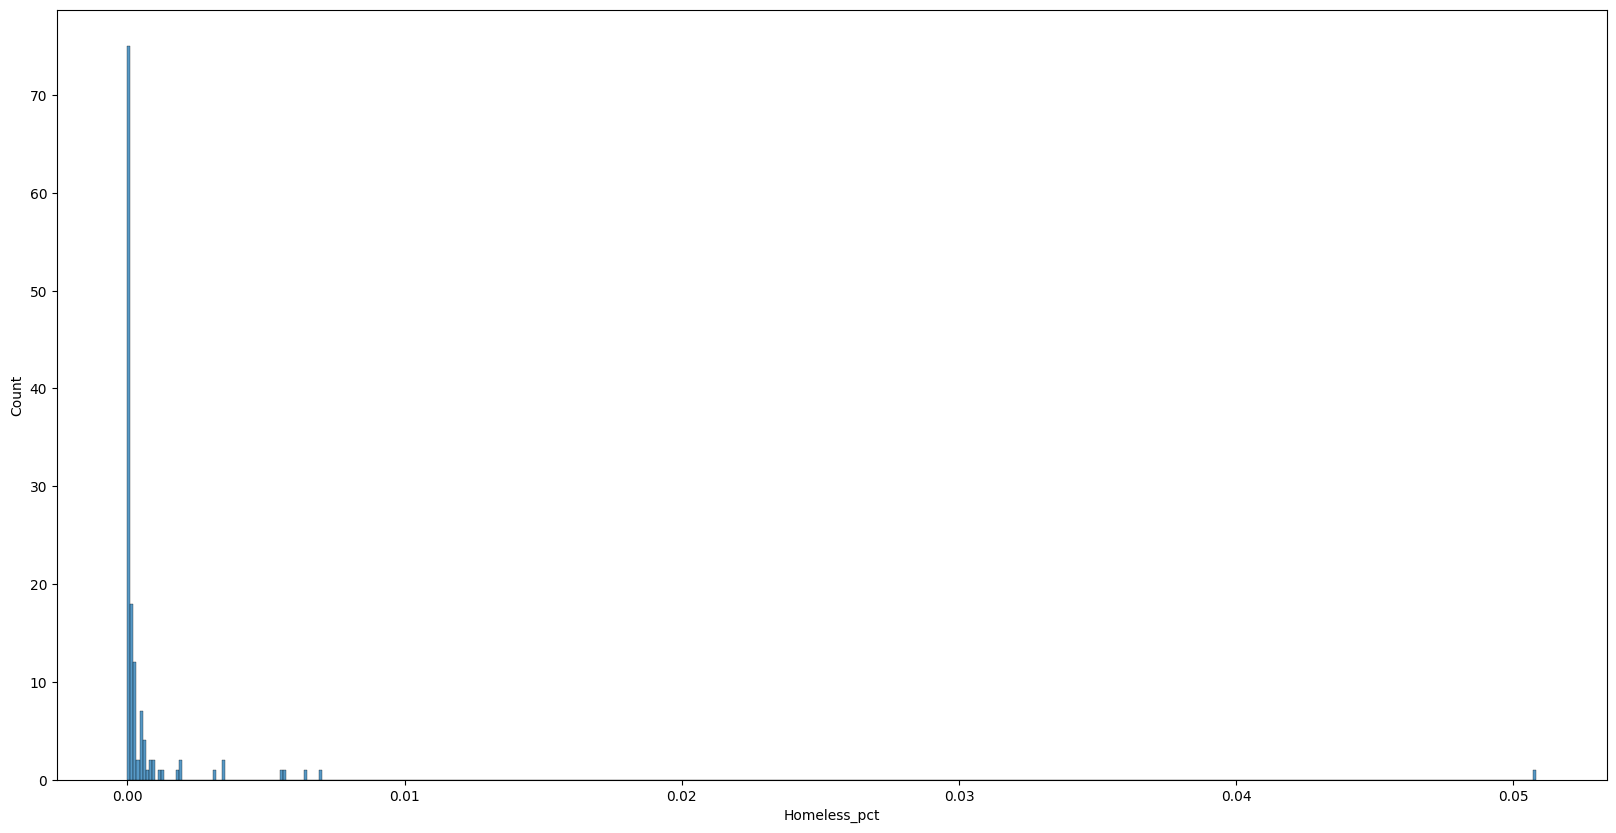

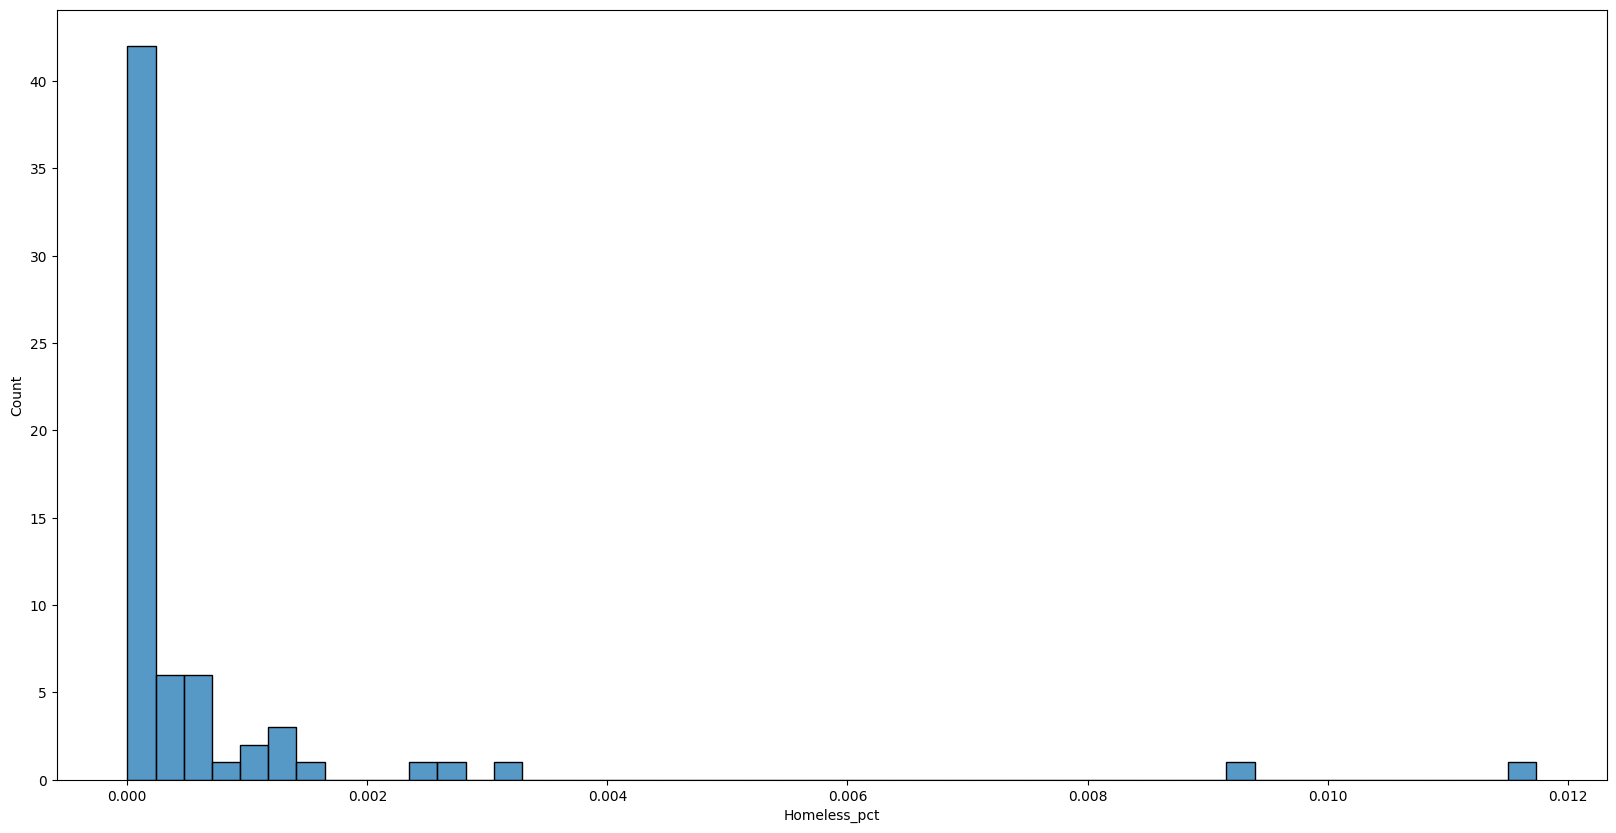

In [28]:
plt.figure(figsize=(20,10))
sns.histplot(X_s[(X_s["Homeless_pct"] > 0) & (X_s["Disaster Type"] == "Flood")]["Homeless_pct"])

plt.figure(figsize=(20,10))
sns.histplot(X_s[(X_s["Homeless_pct"] > 0) & (X_s["Disaster Type"] == "Storm")]["Homeless_pct"])

# World Risk Index (WRI)

Time to see if we can predict which disasters cause homelessness

In [29]:
#########################
# LOAD WORLD RISK INDEX DATA
#########################

wri = pd.read_excel("data/WRI_FullData_Time-series-2000-2022.xlsx", sheet_name=None)
del wri["Codes"]

data = []
for k,v in wri.items():
    year = k.split()[-1]
    vals = v.copy()
    #Removing all composite KPI's
    vals = vals.drop(["W","E","V","EI_01","EI_02","EI_03","EI_04","EI_05","EI_06","EI_07",
                              "S","S_01","S_02","S_03","S_04","S_05",
                              "SI_01","SI_02","SI_03","SI_04","SI_05","SI_06","SI_07","SI_08","SI_09","SI_10","SI_11","SI_12","SI_13","SI_14",
                               "C","C_01","C_02","C_03",
                               "CI_01","CI_02","CI_03","CI_04","CI_05","CI_06","CI_07",
                               "A","A_01","A_02","A_03",
                               "AI_01","AI_02","AI_03","AI_04",
                               #Remove KPI's related to conflict
                               "SI_14a", "SI_14b", "CI_02a", "CI_02b"],axis=1)
    vals["Year"] = year

    data.append(vals)
    #wri_df = wri_df.merge(v, on="Country", how="inner")
wri_df = pd.concat(data, ignore_index=True)
wri_df["Year"] = wri_df["Year"].astype(int)
wri_df.rename(columns={"Code":"ISO"},inplace=True)

In [30]:
dis_df_f = emdat_filter[emdat_filter["Disaster Type"] == "Flood"]
dis_df_s = emdat_filter[emdat_filter["Disaster Type"] == "Storm"]

## Principal Component Analysis (PCA)

Let's run some Principal Component Analysis on the WRI dataset and see how this dataset segments disasters that cause displacement

In [31]:
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

### Storms

In [32]:
X_s = pd.merge(dis_df_s, wri_df, on=["ISO", "Year"],how="left")
X_s = pd.merge(X_s,popsize, on=["Year","ISO"],how="left")
X_s = pd.merge(X_s,temp, on="Year", how="left")
X_s["Homeless_pct"] = X_s["No Homeless"] / X_s["Pop"]
X_s["Year"] = X_s["Year"] - 2000
#X = pd.get_dummies(X, columns=['Region'])
# Convert all boolean columns in the DataFrame to integers (0 or 1)
bool_columns = X_s.select_dtypes(include=['bool']).columns
X_s[bool_columns] = X_s[bool_columns].astype(int)

# REMOVE REDUNDANT VARIABLES
# We remove all indicators that are in numbers and stick to the ones in percentages, as they are otherwise the same
X_s = X_s.drop(["Disaster Type", "Dis Mag Scale","Country_y", "ISO", "Region", "Country_x","No Affected","No Homeless", "Start Date", "End Date", "Size", "Pop",
                "Dis No", "Seq", "Glide", "Disaster Group", "Disaster Subgroup", "Disaster Subtype", "Disaster Subsubtype", "Event Name", "Continent",
                "Location", "Origin", "Associated Dis", "Associated Dis2", "OFDA Response", "Appeal", "Declaration", "AID Contribution ('000 US$)",
                "River Basin", "Start Year", "Start Month", "Start Day", "End Year", "End Month", "End Day", "Latitude", "Longitude", "Local Time",
                "Total Deaths", "No Injured", "Total Affected", "Reconstruction Costs ('000 US$)", "Reconstruction Costs, Adjusted ('000 US$)",
                "Insured Damages ('000 US$)", "Insured Damages, Adjusted ('000 US$)", "Total Damages ('000 US$)", "Total Damages, Adjusted ('000 US$)",
                "CPI", "Adm Level", "Admin1 Code", "Admin2 Code", "Geo Locations"],axis=1)
X_s = X_s.drop("Homeless_pct", axis=1)
X_s=X_s.dropna()
y_s = X_s["Disp"]
X_s = X_s.drop("Disp",axis=1)

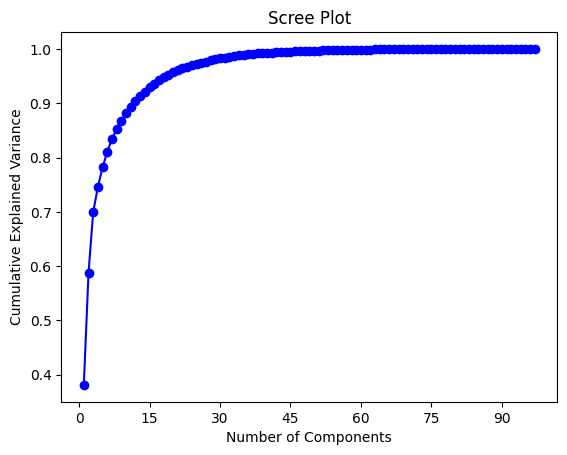

In [33]:
# Perform PCA
# Scale the data

X_scaled = X_s
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_scaled)
pca = PCA().fit(X_scaled)

# Generate the Scree Plot
plt.figure()
plt.plot(np.arange(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_), 'bo-')  # round dots on points

# Hide non-integer xticks
ax = plt.gca()
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Adding labels and title
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')

# Display the scree plot
plt.show()

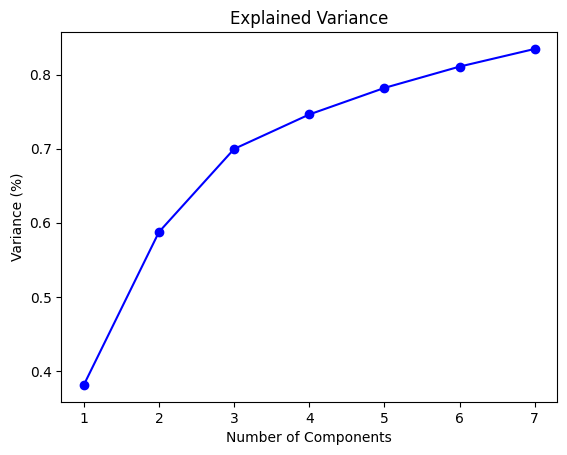

In [34]:
# Assuming X is your standardized data matrix
pca = PCA().fit(X_scaled)
n_comp = [i for i in pca.explained_variance_ratio_ if i > 0.02]
plt.figure()
plt.plot(np.arange(1, len(n_comp) + 1),
         np.cumsum(n_comp), 'bo-')

# Hide non-integer xticks
ax = plt.gca()
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')  # for each component
plt.title('Explained Variance')
plt.show()


In [35]:
pca = PCA(n_components=3).fit(X_scaled)
# Calculate loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Normalize loadings
normalized_loadings = loadings / np.linalg.norm(loadings, axis=0)

# Project the standardized data onto the principal components
X_pca = pca.transform(X_scaled)

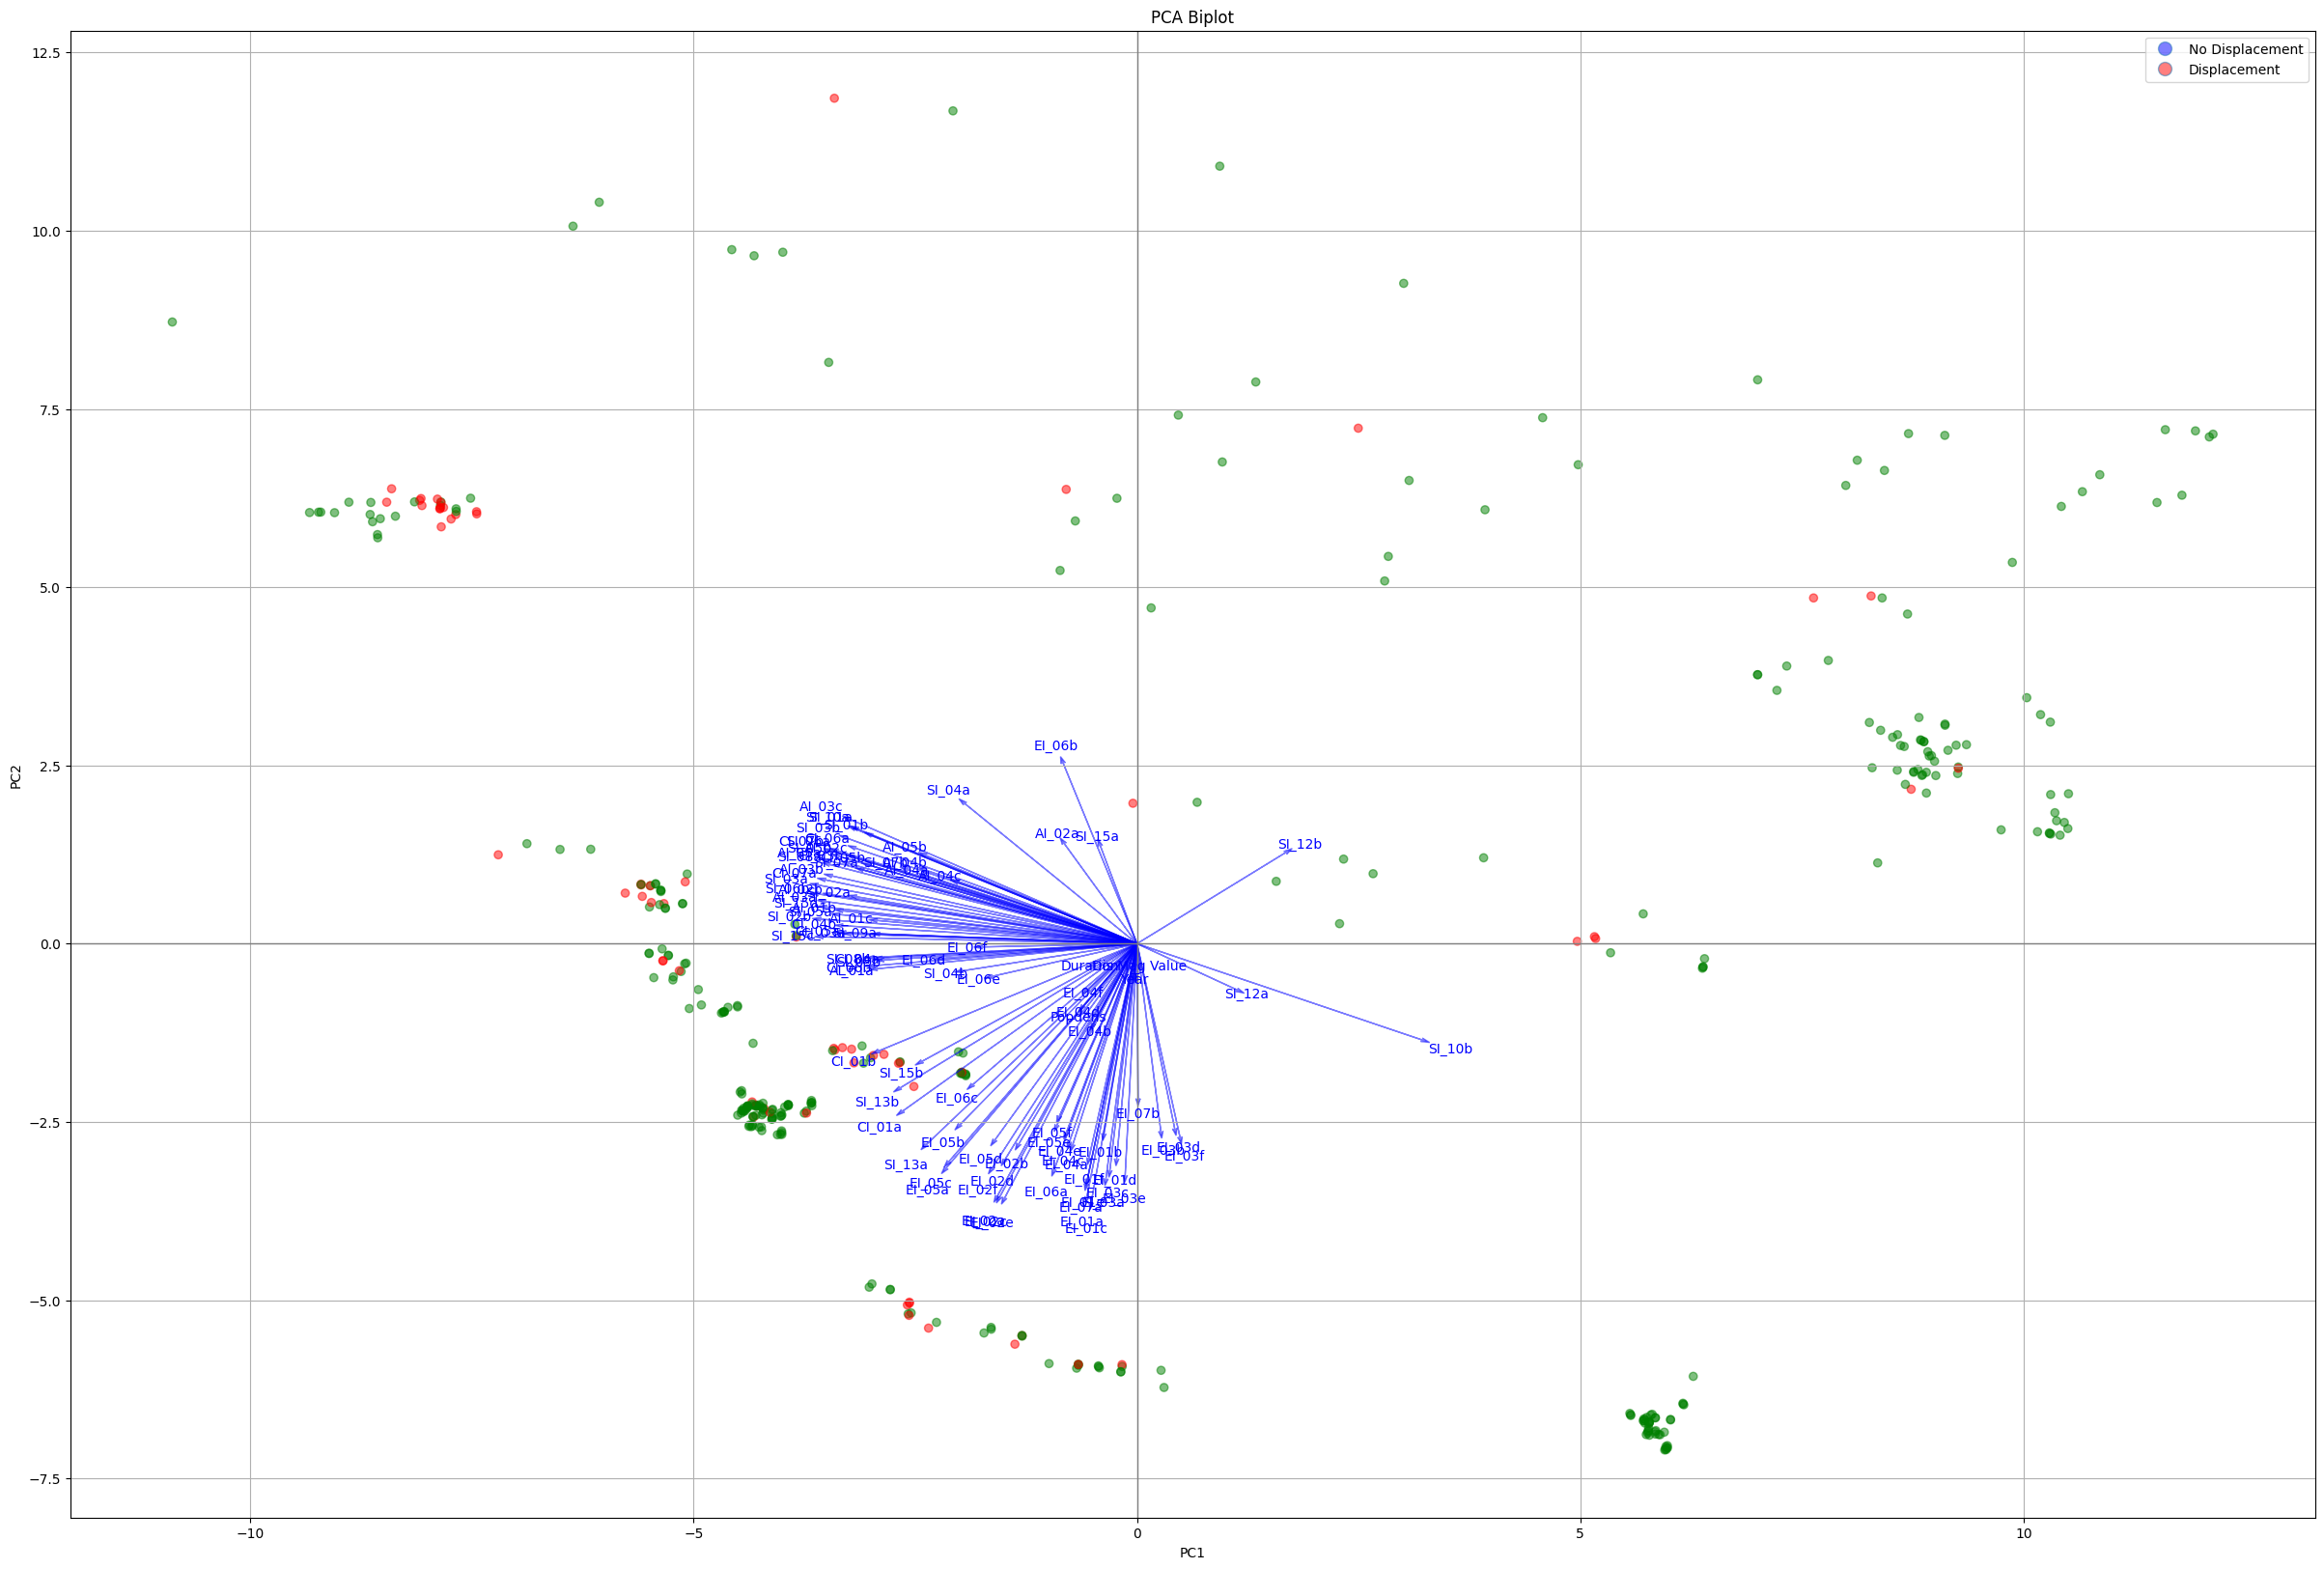

In [36]:
# Calculate the range for the scores
score_range = np.ptp(X_pca, axis=0)  # peak to peak (max - min) for each component

# Rescale the loadings by the score range
rescaled_loadings = normalized_loadings * score_range

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(30, 20))

# Define colors for each class: for example, class 0 as blue and class 1 as red
colors = ['green', 'red']
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5, c=[colors[int(target)] for target in y_s], label='Scores')

# Create a legend for the two classes
class_0 = plt.Line2D([0], [0], linestyle="none", marker='o', alpha=0.5, markersize=10, markerfacecolor='blue')
class_1 = plt.Line2D([0], [0], linestyle="none", marker='o', alpha=0.5, markersize=10, markerfacecolor='red')
ax.legend([class_0, class_1], ['No Displacement', 'Displacement'])

# Add the variable vectors
for i, var in enumerate(X_s.columns):  # Replace 'features' with your actual features list
    plt.arrow(0, 0, rescaled_loadings[i, 0], rescaled_loadings[i, 1], color='blue', alpha=0.5, head_width=0.05, head_length=0.1, overhang=0.5)
    plt.text(rescaled_loadings[i, 0]*1.10, rescaled_loadings[i, 1]*1.10, var, color='blue', ha='center', va='center')

# Set limits and labels
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Biplot')
plt.grid(True)
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.show()

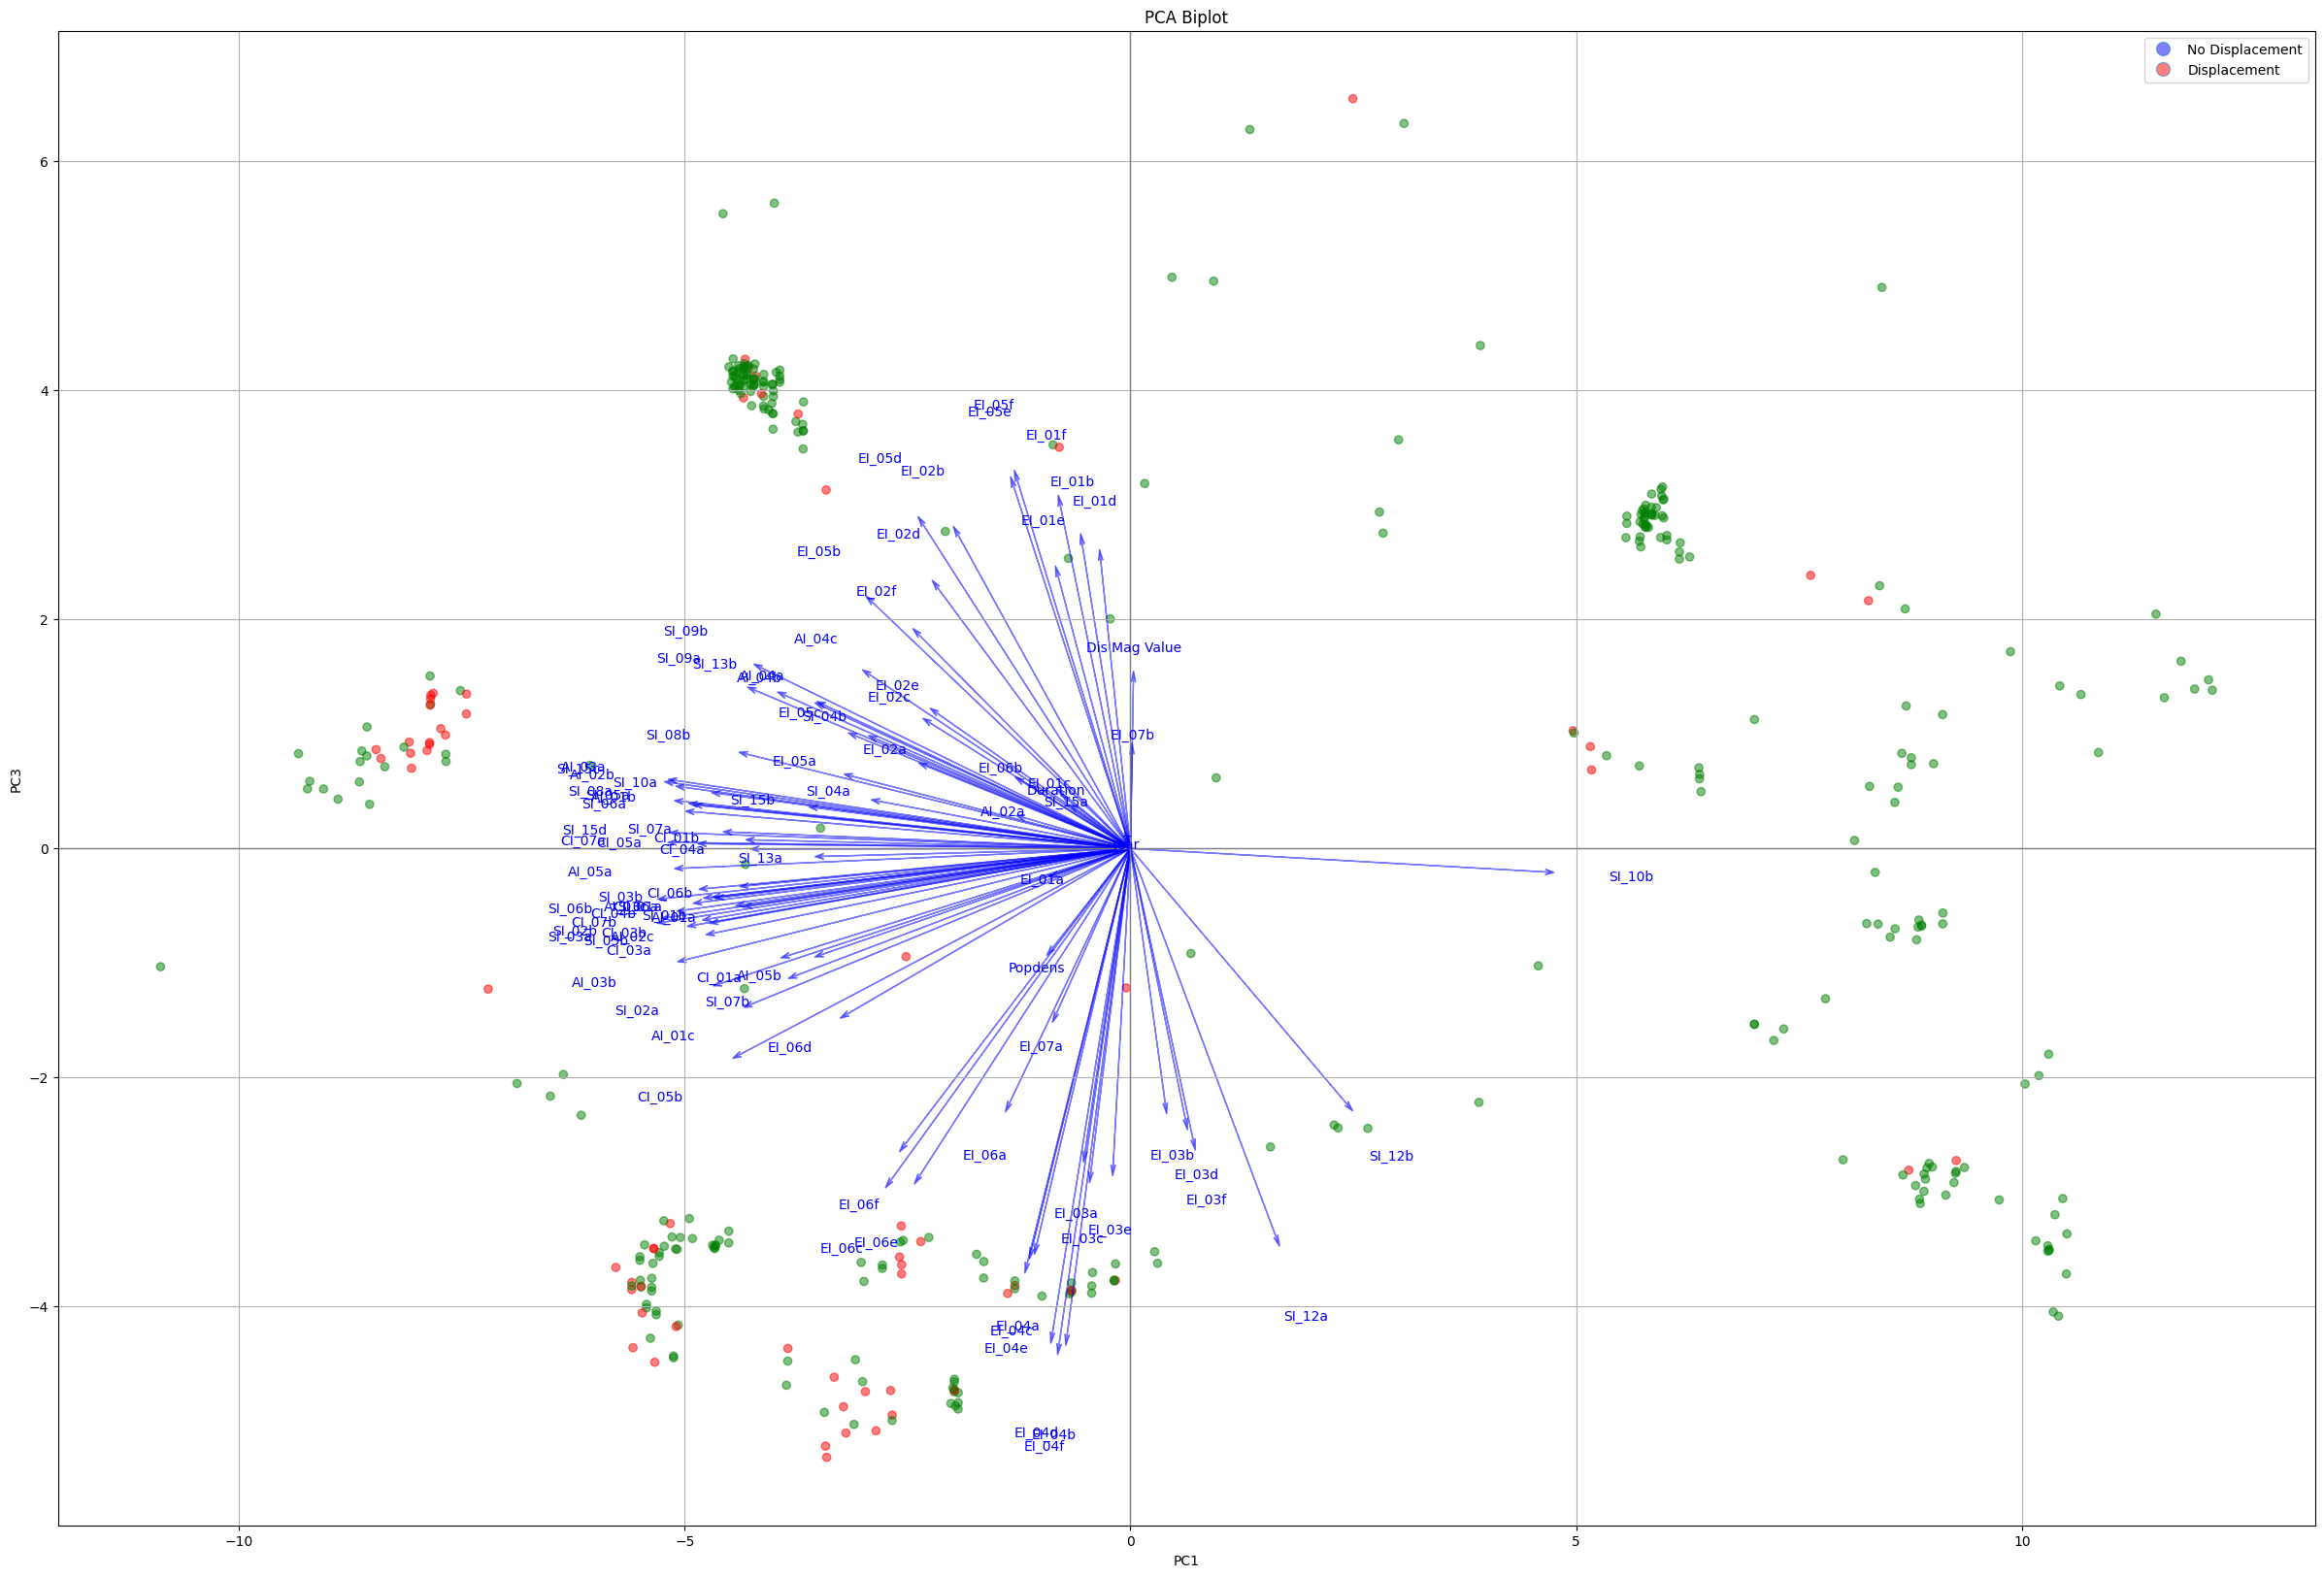

In [37]:
# Calculate the range for the scores
score_range = np.ptp(X_pca, axis=0)  # peak to peak (max - min) for each component

# Rescale the loadings by the score range
rescaled_loadings = normalized_loadings * score_range

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(30, 20))

# Define colors for each class: for example, class 0 as blue and class 1 as red
colors = ['green', 'red']
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 2], alpha=0.5, c=[colors[int(target)] for target in y_s], label='Scores')

# Create a legend for the two classes
class_0 = plt.Line2D([0], [0], linestyle="none", marker='o', alpha=0.5, markersize=10, markerfacecolor='blue')
class_1 = plt.Line2D([0], [0], linestyle="none", marker='o', alpha=0.5, markersize=10, markerfacecolor='red')
ax.legend([class_0, class_1], ['No Displacement', 'Displacement'])

# Add the variable vectors
for i, var in enumerate(X_s.columns):
    plt.arrow(0, 0, rescaled_loadings[i, 0]*1.45, rescaled_loadings[i, 2]*1.45, color='blue', alpha=0.5, head_width=0.05, head_length=0.1, overhang=0.5)
    plt.text(rescaled_loadings[i, 0]*1.75, rescaled_loadings[i, 2]*1.75, var, color='blue', ha='center', va='center')

# Set limits and labels
plt.xlabel('PC1')
plt.ylabel('PC3')
plt.title('PCA Biplot')
plt.grid(True)
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.show()

### Floods

In [38]:
X_s = pd.merge(dis_df_f, wri_df, on=["ISO", "Year"],how="left")
X_s = pd.merge(X_s,popsize, on=["Year","ISO"],how="left")
X_s = pd.merge(X_s,temp, on="Year", how="left")
X_s["Homeless_pct"] = X_s["No Homeless"] / X_s["Pop"]
X_s["Year"] = X_s["Year"] - 2000
#X = pd.get_dummies(X, columns=['Region'])
# Convert all boolean columns in the DataFrame to integers (0 or 1)
bool_columns = X_s.select_dtypes(include=['bool']).columns
X_s[bool_columns] = X_s[bool_columns].astype(int)

# REMOVE REDUNDANT VARIABLES
# We remove all indicators that are in numbers and stick to the ones in percentages, as they are otherwise the same
X_s = X_s.drop(["Disaster Type", "Dis Mag Scale","Country_y", "ISO", "Region", "Country_x","No Affected","No Homeless", "Start Date", "End Date", "Size", "Pop",
                "Dis No", "Seq", "Glide", "Disaster Group", "Disaster Subgroup", "Disaster Subtype", "Disaster Subsubtype", "Event Name", "Continent",
                "Location", "Origin", "Associated Dis", "Associated Dis2", "OFDA Response", "Appeal", "Declaration", "AID Contribution ('000 US$)",
                "River Basin", "Start Year", "Start Month", "Start Day", "End Year", "End Month", "End Day", "Latitude", "Longitude", "Local Time",
                "Total Deaths", "No Injured", "Total Affected", "Reconstruction Costs ('000 US$)", "Reconstruction Costs, Adjusted ('000 US$)",
                "Insured Damages ('000 US$)", "Insured Damages, Adjusted ('000 US$)", "Total Damages ('000 US$)", "Total Damages, Adjusted ('000 US$)",
                "CPI", "Adm Level", "Admin1 Code", "Admin2 Code", "Geo Locations"],axis=1)
X_s = X_s.drop("Homeless_pct", axis=1)
X_s=X_s.dropna()
y_s = X_s["Disp"]
X_s = X_s.drop("Disp",axis=1)

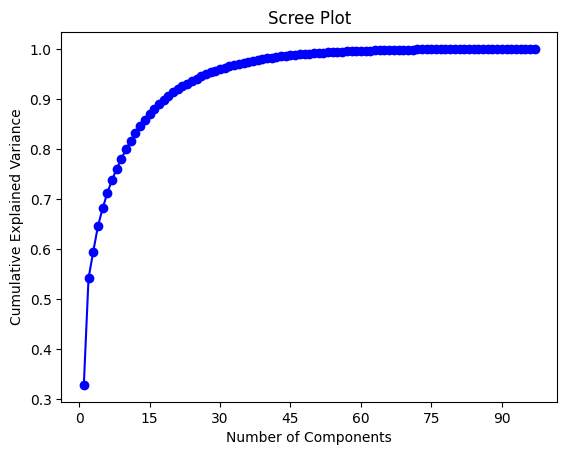

In [39]:
# Perform PCA
# Scale the data

X_scaled = X_s
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_scaled)
pca = PCA().fit(X_scaled)

# Generate the Scree Plot
plt.figure()
plt.plot(np.arange(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_), 'bo-')  # round dots on points

# Hide non-integer xticks
ax = plt.gca()
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Adding labels and title
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')

# Display the scree plot
plt.show()

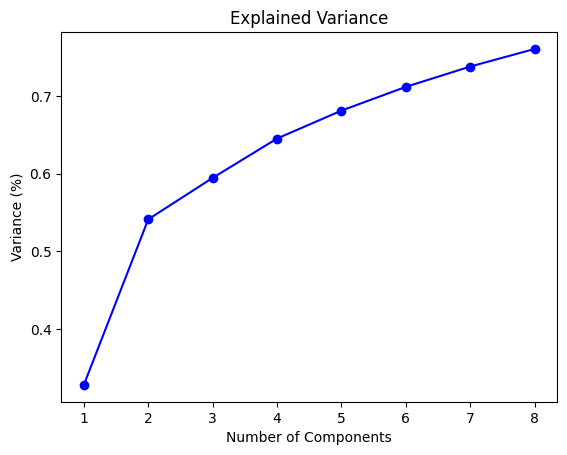

In [40]:
# Assuming X is your standardized data matrix
pca = PCA().fit(X_scaled)
n_comp = [i for i in pca.explained_variance_ratio_ if i > 0.02]
plt.figure()
plt.plot(np.arange(1, len(n_comp) + 1),
         np.cumsum(n_comp), 'bo-')

# Hide non-integer xticks
ax = plt.gca()
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')  # for each component
plt.title('Explained Variance')
plt.show()


In [41]:
pca = PCA(n_components=3).fit(X_scaled)
# Calculate loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Normalize loadings
normalized_loadings = loadings / np.linalg.norm(loadings, axis=0)

# Project the standardized data onto the principal components
X_pca = pca.transform(X_scaled)

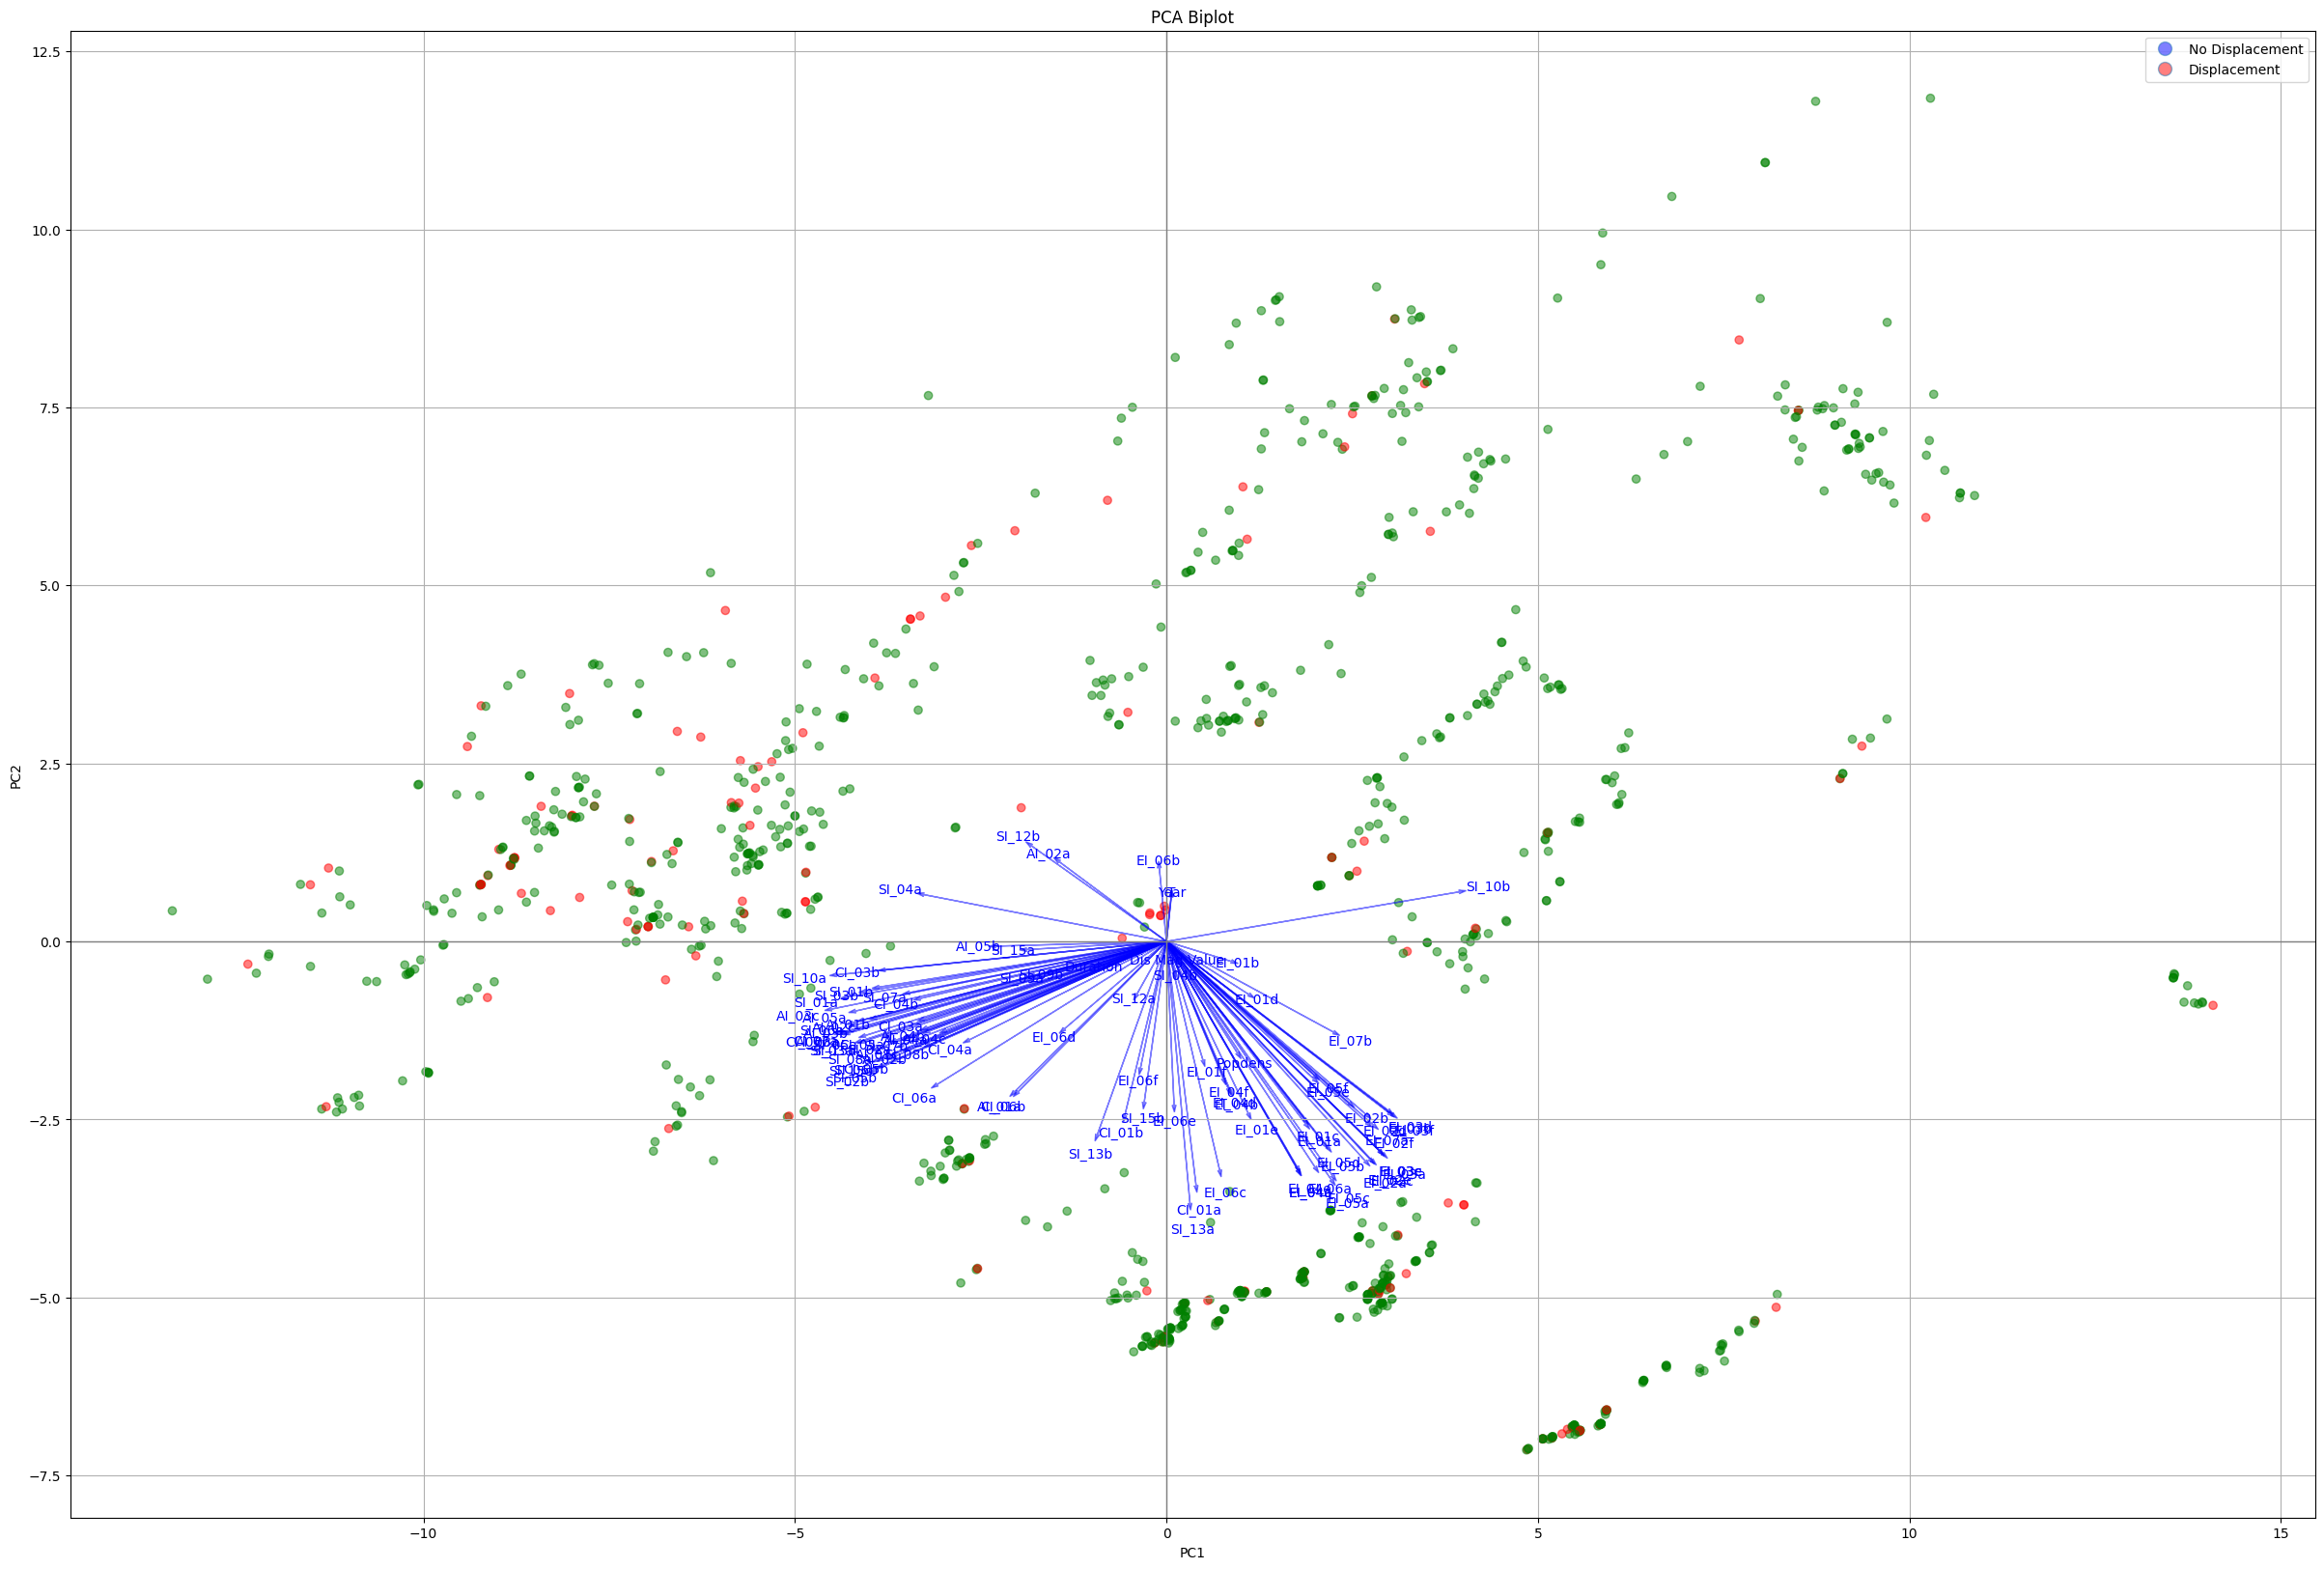

In [42]:
# Calculate the range for the scores
score_range = np.ptp(X_pca, axis=0)  # peak to peak (max - min) for each component

# Rescale the loadings by the score range
rescaled_loadings = normalized_loadings * score_range

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(30, 20))

# Define colors for each class: for example, class 0 as blue and class 1 as red
colors = ['green', 'red']
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5, c=[colors[int(target)] for target in y_s], label='Scores')

# Create a legend for the two classes
class_0 = plt.Line2D([0], [0], linestyle="none", marker='o', alpha=0.5, markersize=10, markerfacecolor='blue')
class_1 = plt.Line2D([0], [0], linestyle="none", marker='o', alpha=0.5, markersize=10, markerfacecolor='red')
ax.legend([class_0, class_1], ['No Displacement', 'Displacement'])

# Add the variable vectors
for i, var in enumerate(X_s.columns):  # Replace 'features' with your actual features list
    plt.arrow(0, 0, rescaled_loadings[i, 0], rescaled_loadings[i, 1], color='blue', alpha=0.5, head_width=0.05, head_length=0.1, overhang=0.5)
    plt.text(rescaled_loadings[i, 0]*1.10, rescaled_loadings[i, 1]*1.10, var, color='blue', ha='center', va='center')

# Set limits and labels
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Biplot')
plt.grid(True)
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.show()

## Factor Analysis

The principal components 1 and 2 shows that we have one principal component related to socioeconomic indicators and lack of adaptive/coping capabilities and PC2 is related to exposure. We also see many correlated variables. Let's remove some variables and see if we can find the underlying factors

In [43]:
from factor_analyzer import FactorAnalyzer

In [44]:
#########################
# LOAD WORLD RISK INDEX DATA
#########################

wri = pd.read_excel("data/WRI_FullData_Time-series-2000-2022.xlsx", sheet_name=None)
del wri["Codes"]

data = []
for k,v in wri.items():
    year = k.split()[-1]
    vals = v.copy()
    #Removing all composite KPI's
    vals = vals[["Country", "Code",
                 "EI_02b", "EI_02d", "EI_02f", "EI_03b", "EI_03d", "EI_03f", "EI_05b", "EI_05d", "EI_05f", "EI_07b",
                 "SI_01a", "SI_02b", "SI_02a", "SI_03a", "SI_05a", "SI_08a", "SI_12b", "SI_13b", 
                 "CI_01b", "CI_05b", 
                 "AI_01a", "AI_02a"]]
    vals["Year"] = year

    data.append(vals)
    #wri_df = wri_df.merge(v, on="Country", how="inner")
wri_df = pd.concat(data, ignore_index=True)
wri_df["Year"] = wri_df["Year"].astype(int)
wri_df.rename(columns={"Code":"ISO"},inplace=True)

### Storms

In [45]:
X_s = pd.merge(dis_df_s, wri_df, on=["ISO", "Year"],how="left")
X_s = pd.merge(X_s,popsize, on=["Year","ISO"],how="left")
X_s = pd.merge(X_s,temp, on="Year", how="left")
X_s["Homeless_pct"] = X_s["No Homeless"] / X_s["Pop"]
X_s["Year"] = X_s["Year"] - 2000
#X = pd.get_dummies(X, columns=['Region'])
# Convert all boolean columns in the DataFrame to integers (0 or 1)
bool_columns = X_s.select_dtypes(include=['bool']).columns
X_s[bool_columns] = X_s[bool_columns].astype(int)

# REMOVE REDUNDANT VARIABLES
# We remove all indicators that are in numbers and stick to the ones in percentages, as they are otherwise the same
X_s = X_s.drop(["Disaster Type", "Dis Mag Scale","Country_y", "ISO", "Region", "Country_x","No Affected","No Homeless", "Start Date", "End Date", "Size", "Pop",
                "Dis No", "Seq", "Glide", "Disaster Group", "Disaster Subgroup", "Disaster Subtype", "Disaster Subsubtype", "Event Name", "Continent",
                "Location", "Origin", "Associated Dis", "Associated Dis2", "OFDA Response", "Appeal", "Declaration", "AID Contribution ('000 US$)",
                "River Basin", "Start Year", "Start Month", "Start Day", "End Year", "End Month", "End Day", "Latitude", "Longitude", "Local Time",
                "Total Deaths", "No Injured", "Total Affected", "Reconstruction Costs ('000 US$)", "Reconstruction Costs, Adjusted ('000 US$)",
                "Insured Damages ('000 US$)", "Insured Damages, Adjusted ('000 US$)", "Total Damages ('000 US$)", "Total Damages, Adjusted ('000 US$)",
                "CPI", "Adm Level", "Admin1 Code", "Admin2 Code", "Geo Locations", "T"],axis=1)
X_s = X_s.drop("Homeless_pct", axis=1)
X_s=X_s.dropna()
y_s = X_s["Disp"]
X_s = X_s.drop("Disp",axis=1)

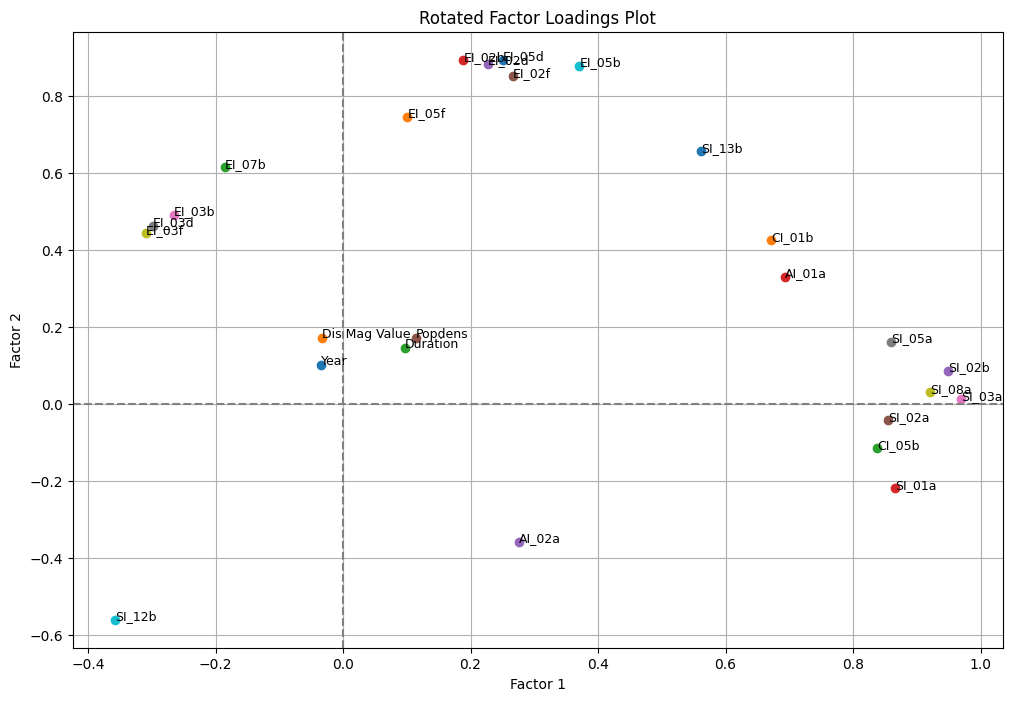

In [46]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_s)

# Step 2: Perform Factor Analysis
fa = FactorAnalyzer(n_factors=2, rotation='varimax')
fa.fit(X_scaled)

# Get the loadings (the rotated factor loadings matrix)
loadings = fa.loadings_

# Step 3: Create a Rotated Factor Loadings Plot
plt.figure(figsize=(12,8))
for i, (load1, load2) in enumerate(loadings):
    plt.scatter(load1, load2, label=X_s.columns[i])
    plt.text(load1, load2, X_s.columns[i], fontsize=9)

plt.title('Rotated Factor Loadings Plot')
plt.xlabel('Factor 1')
plt.ylabel('Factor 2')
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
plt.grid(True)
plt.show()

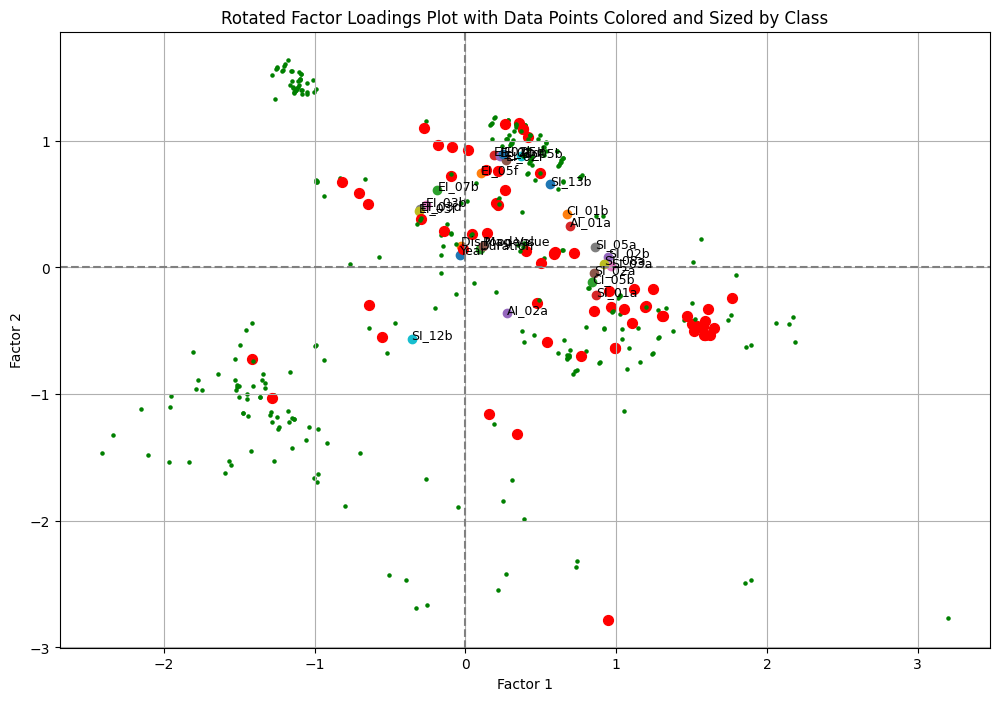

In [47]:
# Calculate factor scores
X_fa = fa.transform(X_scaled)

# Create a Rotated Factor Loadings Plot
plt.figure(figsize=(12,8))

# Plot the loadings
for i, (load1, load2) in enumerate(loadings):
    plt.scatter(load1, load2, label=X_s.columns[i], marker='o')
    plt.text(load1, load2, X_s.columns[i], fontsize=9)

# Plot the factor scores with color and size coding
colors = ['green', 'red']  # colors for classes 0 and 1
sizes = [5, 50]  # sizes for classes 0 and 1
for score, classification in zip(X_fa, y_s):
    plt.scatter(score[0], score[1], marker='o', color=colors[classification], s=sizes[classification])

plt.title('Rotated Factor Loadings Plot with Data Points Colored and Sized by Class')
plt.xlabel('Factor 1')
plt.ylabel('Factor 2')
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
plt.grid(True)
plt.show()


#### K-means Clustering

/home/jpoulsen/miniconda3/envs/abm/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


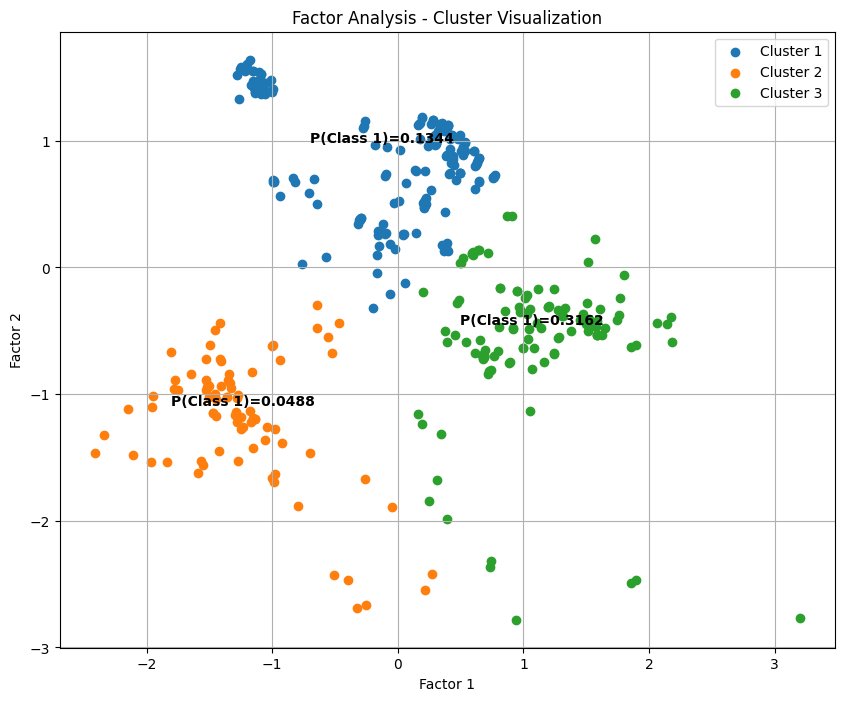

In [48]:
from sklearn.cluster import KMeans

num_clusters = 3

# Use a clustering algorithm to find clusters in the factor scores
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(X_fa)

# Calculate the probability of each label within each cluster
label_probs = np.zeros((num_clusters, 2))
for i in range(num_clusters):
    cluster_indices = np.where(clusters == i)[0]
    # Get the labels for each cluster using .iloc for correct indexing
    cluster_labels = y_s.iloc[cluster_indices]
    label_probs[i, 0] = np.mean(cluster_labels == 0)
    label_probs[i, 1] = np.mean(cluster_labels == 1)

# Now label_probs contains the probability of label 0 and 1 for each cluster

# If you wish to visualize the clusters with a scatter plot
plt.figure(figsize=(10, 8))
for i in range(num_clusters):
    plt.scatter(X_fa[clusters == i, 0], X_fa[clusters == i, 1], label=f'Cluster {i+1}')
    plt.annotate(f'P(Class 1)={label_probs[i, 1]:.4f}',
                 (kmeans.cluster_centers_[i, 0], kmeans.cluster_centers_[i, 1]),
                 textcoords="offset points",  # how to position the text
                 xytext=(0,10),  # distance from text to points (x,y)
                 ha='center',fontweight='bold')

plt.title('Factor Analysis - Cluster Visualization')
plt.xlabel('Factor 1')
plt.ylabel('Factor 2')
plt.legend()
plt.grid(True)
plt.show()

### Floods

In [49]:
X_s = pd.merge(dis_df_f, wri_df, on=["ISO", "Year"],how="left")
X_s = pd.merge(X_s,popsize, on=["Year","ISO"],how="left")
X_s = pd.merge(X_s,temp, on="Year", how="left")
X_s["Homeless_pct"] = X_s["No Homeless"] / X_s["Pop"]
X_s["Year"] = X_s["Year"] - 2000
#X = pd.get_dummies(X, columns=['Region'])
# Convert all boolean columns in the DataFrame to integers (0 or 1)
bool_columns = X_s.select_dtypes(include=['bool']).columns
X_s[bool_columns] = X_s[bool_columns].astype(int)

# REMOVE REDUNDANT VARIABLES
# We remove all indicators that are in numbers and stick to the ones in percentages, as they are otherwise the same
X_s = X_s.drop(["Disaster Type", "Dis Mag Scale","Country_y", "ISO", "Region", "Country_x","No Affected","No Homeless", "Start Date", "End Date", "Size", "Pop",
                "Dis No", "Seq", "Glide", "Disaster Group", "Disaster Subgroup", "Disaster Subtype", "Disaster Subsubtype", "Event Name", "Continent",
                "Location", "Origin", "Associated Dis", "Associated Dis2", "OFDA Response", "Appeal", "Declaration", "AID Contribution ('000 US$)",
                "River Basin", "Start Year", "Start Month", "Start Day", "End Year", "End Month", "End Day", "Latitude", "Longitude", "Local Time",
                "Total Deaths", "No Injured", "Total Affected", "Reconstruction Costs ('000 US$)", "Reconstruction Costs, Adjusted ('000 US$)",
                "Insured Damages ('000 US$)", "Insured Damages, Adjusted ('000 US$)", "Total Damages ('000 US$)", "Total Damages, Adjusted ('000 US$)",
                "CPI", "Adm Level", "Admin1 Code", "Admin2 Code", "Geo Locations", "T"],axis=1)
X_s = X_s.drop("Homeless_pct", axis=1)
X_s=X_s.dropna()
y_s = X_s["Disp"]
X_s = X_s.drop("Disp",axis=1)

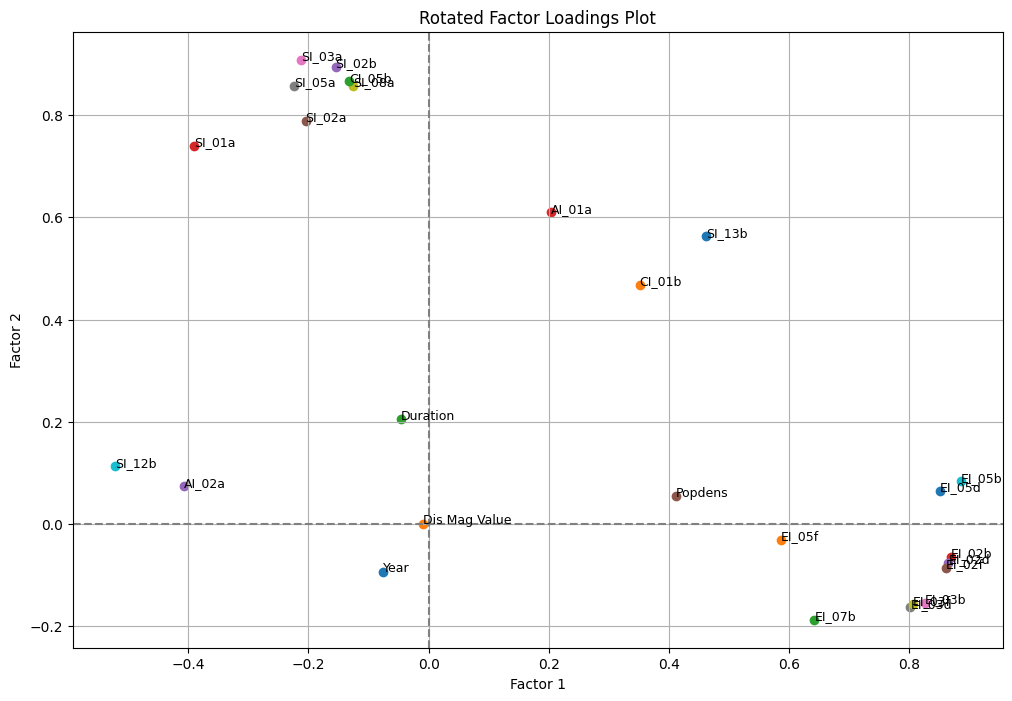

In [50]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_s)

# Step 2: Perform Factor Analysis
fa = FactorAnalyzer(n_factors=2, rotation='varimax')
fa.fit(X_scaled)

# Get the loadings (the rotated factor loadings matrix)
loadings = fa.loadings_

# Step 3: Create a Rotated Factor Loadings Plot
plt.figure(figsize=(12,8))
for i, (load1, load2) in enumerate(loadings):
    plt.scatter(load1, load2, label=X_s.columns[i])
    plt.text(load1, load2, X_s.columns[i], fontsize=9)

plt.title('Rotated Factor Loadings Plot')
plt.xlabel('Factor 1')
plt.ylabel('Factor 2')
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
plt.grid(True)
plt.show()

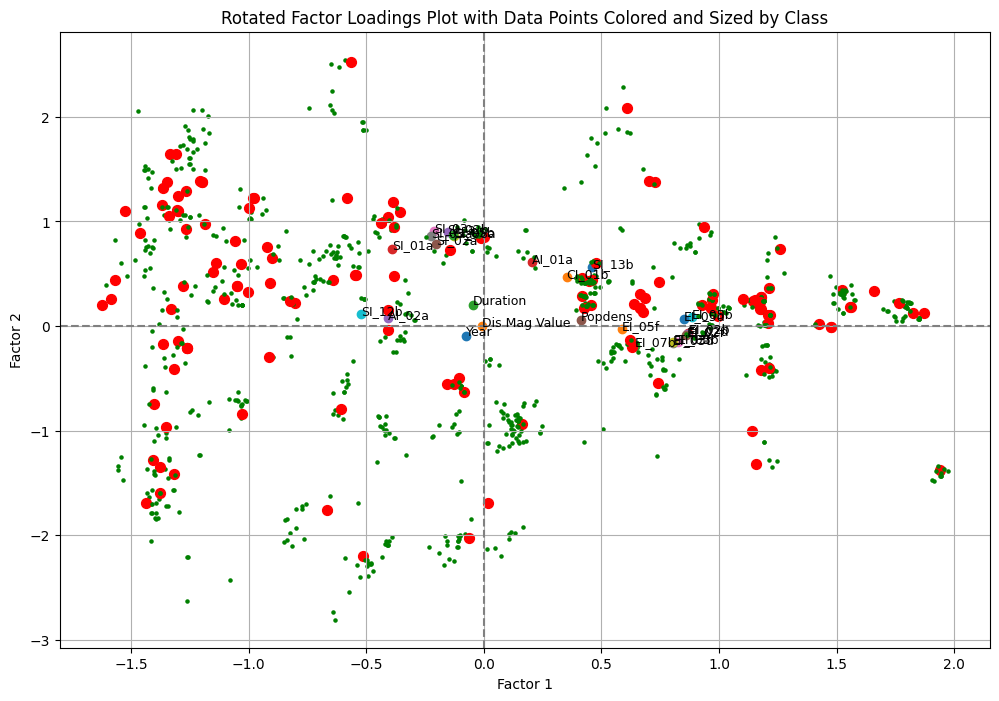

In [51]:
# Calculate factor scores
X_fa = fa.transform(X_scaled)

# Create a Rotated Factor Loadings Plot
plt.figure(figsize=(12,8))

# Plot the loadings
for i, (load1, load2) in enumerate(loadings):
    plt.scatter(load1, load2, label=X_s.columns[i], marker='o')
    plt.text(load1, load2, X_s.columns[i], fontsize=9)

# Plot the factor scores with color and size coding
colors = ['green', 'red']  # colors for classes 0 and 1
sizes = [5, 50]  # sizes for classes 0 and 1
for score, classification in zip(X_fa, y_s):
    plt.scatter(score[0], score[1], marker='o', color=colors[classification], s=sizes[classification])

plt.title('Rotated Factor Loadings Plot with Data Points Colored and Sized by Class')
plt.xlabel('Factor 1')
plt.ylabel('Factor 2')
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
plt.grid(True)
plt.show()


/home/jpoulsen/miniconda3/envs/abm/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


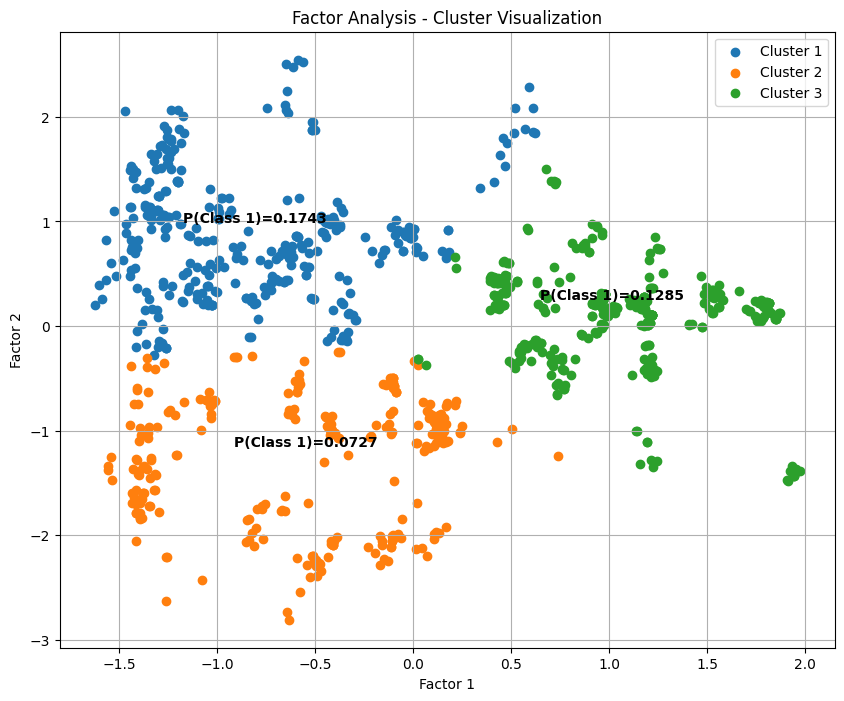

In [52]:
from sklearn.cluster import KMeans

num_clusters = 3

# Use a clustering algorithm to find clusters in the factor scores
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(X_fa)

# Calculate the probability of each label within each cluster
label_probs = np.zeros((num_clusters, 2))
for i in range(num_clusters):
    cluster_indices = np.where(clusters == i)[0]
    # Get the labels for each cluster using .iloc for correct indexing
    cluster_labels = y_s.iloc[cluster_indices]
    label_probs[i, 0] = np.mean(cluster_labels == 0)
    label_probs[i, 1] = np.mean(cluster_labels == 1)

# Now label_probs contains the probability of label 0 and 1 for each cluster

# If you wish to visualize the clusters with a scatter plot
plt.figure(figsize=(10, 8))
for i in range(num_clusters):
    plt.scatter(X_fa[clusters == i, 0], X_fa[clusters == i, 1], label=f'Cluster {i+1}')
    plt.annotate(f'P(Class 1)={label_probs[i, 1]:.4f}',
                 (kmeans.cluster_centers_[i, 0], kmeans.cluster_centers_[i, 1]),
                 textcoords="offset points",  # how to position the text
                 xytext=(0,10),  # distance from text to points (x,y)
                 ha='center',fontweight='bold')

plt.title('Factor Analysis - Cluster Visualization')
plt.xlabel('Factor 1')
plt.ylabel('Factor 2')
plt.legend()
plt.grid(True)
plt.show()